In [1490]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML



def dps_new_f():

    query = """

    with dps_data as (
    SELECT   smto.entity_id
            ,smto.country_code
            ,smto.city_id
            ,smto.city_name
            ,CONCAT(smto.city_name , "-", "post") city_name_var
            ,smto.created_date_local
            ,date_trunc(created_date_local, ISOWEEK) week
            ,date_trunc(created_date_local, MONTH) month
            ,smto.customer_account_id
            ,smto.customer_first_order_date
            ,smto.order_id
            ,smto.dps_delivery_fee_eur
            ,smto.delivery_fee_eur
            ,smto.delivery_fee_local
            ,smto.dps_travel_time_fee_eur
            ,dps_standard_fee_eur
            ,vendor_funding_amount_local
            ,dps_last_non_zero_df_eur
            ,delivery_fee_vat_eur
            ,delivery_fee_vat_local
            ,smto.delivery_fee_option
            ,smto.priority_fee_eur
            ,smto.saver_discount_eur
            ,smto.gfv_eur
            ,smto.gfv_local
            ,smto.gmv_eur
            ,smto.gmv_local
            ,smto.profit_eur
            ,smto.profit_local
            ,smto.revenue_eur
            ,smto.revenue_local
            ,smto.mov_customer_fee_eur
            ,smto.service_fee_eur
            ,smto.dps_service_fee_eur
            ,smto.delivery_distance
            ,smto.delivery_costs_eur
            ,smto.delivery_costs_local
            ,smto.joker_vendor_fee_eur
            ,smto.is_sent
            ,smto.is_own_delivery
            ,smto.vertical_type
            ,(case when is_sent = TRUE then 1 else 0 end) completed_orders
            ,fully_loaded_gross_profit_eur
            ,smto.commission_eur
            ,smto.platform_order_code
            ,smto.has_new_customer_condition
            ,smto.new_customer_condition_type
    FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
    WHERE smto.entity_id = 'OP_SE'
        AND smto.created_date_local BETWEEN '2024-08-06' AND DATE_ADD('2024-08-06', INTERVAL 30 DAY)
        and has_new_customer_condition is true
        and new_customer_condition_type = 'TOTAL'
        AND city_name in ('Uppsala','Vasteras','Helsinborg','Orebro')
        AND is_own_delivery = TRUE
    ),
    voucher_data as (
    SELECT   o.global_entity_id
            ,order_id
            ,o.customer_account_id
            ,vouchers[SAFE_OFFSET(0)].voucher_code voucher_code
            ,vouchers[SAFE_OFFSET(0)].amount_eur voucher_amount_eur
    FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` o
    where global_entity_id='OP_SE'
    AND partition_date_local BETWEEN '2024-08-06' AND DATE_ADD('2024-08-06', INTERVAL 30 DAY)
    AND (vouchers[SAFE_OFFSET(0)].voucher_code in ('nyburgare', 'mumsigt','megagott','mums150'))
    )
    select dd.*
           ,vd.voucher_code
           ,vd.voucher_amount_eur
    from dps_data dd 
    left join voucher_data vd on vd.global_entity_id = dd.entity_id and vd.order_id = dd.platform_order_code

    """

    return query



def dps_all_f():

    query = """
    with details as (
    SELECT  smto.entity_id
            ,smto.country_code
            ,smto.city_id
            ,smto.city_name
            ,CONCAT(smto.city_name , "-", "post") city_name_var
            ,smto.created_date_local
            ,date_trunc(created_date_local, ISOWEEK) week
            ,date_trunc(created_date_local, MONTH) month
            ,smto.customer_account_id
            ,smto.customer_first_order_date
            ,smto.order_id
            ,smto.dps_delivery_fee_eur
            ,smto.delivery_fee_eur
            ,smto.delivery_fee_local
            ,dps_travel_time_fee_eur
            ,dps_standard_fee_eur
            ,vendor_funding_amount_local
            ,dps_last_non_zero_df_eur
            ,delivery_fee_vat_eur
            ,delivery_fee_vat_local
            ,smto.delivery_fee_option
            ,smto.priority_fee_eur
            ,smto.saver_discount_eur
            ,smto.gfv_eur
            ,smto.gfv_local
            ,smto.gmv_eur
            ,smto.gmv_local
            ,smto.profit_eur
            ,smto.profit_local
            ,smto.revenue_eur
            ,smto.revenue_local
            ,smto.mov_customer_fee_eur
            ,smto.service_fee_eur
            ,smto.dps_service_fee_eur
            ,smto.delivery_distance
            ,smto.delivery_costs_eur
            ,smto.delivery_costs_local
            ,smto.joker_vendor_fee_eur
            ,smto.is_sent
            ,smto.is_own_delivery
            ,smto.vertical_type
            ,(case when is_sent = TRUE then 1 else 0 end) completed_orders
            ,fully_loaded_gross_profit_eur
            ,smto.commission_eur
            ,smto.platform_order_code
            ,smto.has_new_customer_condition
            ,smto.new_customer_condition_type
    FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
    join
    (   SELECT  o.customer_account_id
        FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` o
        WHERE o.entity_id = 'OP_SE'
            AND o.created_date_local BETWEEN '2024-08-06' AND DATE_ADD('2024-08-06', INTERVAL 30 DAY)
            and o.has_new_customer_condition is true
            and o.new_customer_condition_type = 'TOTAL'
            AND o.city_name in ('Uppsala','Vasteras','Helsinborg','Orebro')
            group by 1
    ) tm on tm.customer_account_id = smto.customer_account_id
    WHERE smto.created_date_local BETWEEN '2024-08-06' AND DATE_ADD('2024-08-06', INTERVAL 30 DAY)
    AND city_name in ('Uppsala','Vasteras','Helsinborg','Orebro')
    ),
    voucher_data as (
    SELECT  o.global_entity_id
            ,order_id
            ,o.customer_account_id
            ,vouchers[SAFE_OFFSET(0)].voucher_code voucher_code
            ,vouchers[SAFE_OFFSET(0)].amount_eur voucher_amount_eur
    FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` o
    where global_entity_id='OP_SE'
    AND partition_date_local BETWEEN '2024-08-06' AND DATE_ADD('2024-08-06', INTERVAL 30 DAY)
    AND (vouchers[SAFE_OFFSET(0)].voucher_code in ('nyburgare', 'mumsigt','megagott','mums150'))
    )
    select d.*
           ,vd.voucher_code
           ,vd.voucher_amount_eur
    from details d 
    left join voucher_data vd on vd.global_entity_id = d.entity_id and vd.order_id = d.platform_order_code
    """

    return query

    
def voucher_new_v():

    query = """
    SELECT   smto.entity_id
            ,smto.country_code
            ,smto.city_id
            ,smto.city_name
            ,CONCAT(smto.city_name , "-", "pre") city_name_var
            ,smto.created_date_local
            ,date_trunc(created_date_local, ISOWEEK) week
            ,date_trunc(created_date_local, MONTH) month
            ,smto.customer_account_id
            ,smto.customer_first_order_date
            ,smto.order_id
            ,smto.dps_delivery_fee_eur
            ,smto.delivery_fee_eur
            ,smto.delivery_fee_local
            ,smto.dps_travel_time_fee_eur
            ,dps_standard_fee_eur
            ,vendor_funding_amount_local
            ,dps_last_non_zero_df_eur
            ,delivery_fee_vat_eur
            ,delivery_fee_vat_local
            ,smto.delivery_fee_option
            ,smto.priority_fee_eur
            ,smto.saver_discount_eur
            ,smto.gfv_eur
            ,smto.gfv_local
            ,smto.gmv_eur
            ,smto.gmv_local
            ,smto.profit_eur
            ,smto.profit_local
            ,smto.revenue_eur
            ,smto.revenue_local
            ,smto.mov_customer_fee_eur
            ,smto.service_fee_eur
            ,smto.dps_service_fee_eur
            ,smto.delivery_distance
            ,smto.delivery_costs_eur
            ,smto.delivery_costs_local
            ,smto.joker_vendor_fee_eur
            ,smto.is_sent
            ,smto.is_own_delivery
            ,smto.vertical_type
            ,(case when is_sent = TRUE then 1 else 0 end) completed_orders
            ,fully_loaded_gross_profit_eur
            ,smto.commission_eur
            ,smto.platform_order_code
            ,smto.has_new_customer_condition
            ,smto.new_customer_condition_type
            ,vd.vouchers[SAFE_OFFSET(0)].voucher_code
            ,vouchers[SAFE_OFFSET(0)].amount_eur voucher_amount_eur
    FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
    join `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` vd on vd.global_entity_id = smto.entity_id and vd.order_id = smto.platform_order_code
    WHERE smto.entity_id = 'OP_SE'
        AND smto.created_date_local BETWEEN DATE_SUB(DATE '2024-08-06', INTERVAL 30 DAY) AND '2024-08-06'
        AND city_name in ('Uppsala','Vasteras','Helsinborg','Orebro')
        AND is_own_delivery = TRUE
        AND vd.vouchers[SAFE_OFFSET(0)].voucher_code in ('nyburgare', 'mumsigt','megagott','mums150')
        AND vd.partition_date_local BETWEEN DATE_SUB(DATE '2024-08-06', INTERVAL 30 DAY) AND '2024-08-06'

    """

    return query


def voucher_all_v():

    query = """
    with details as (
    SELECT  smto.entity_id
            ,smto.country_code
            ,smto.city_id
            ,smto.city_name
            ,CONCAT(smto.city_name , "-", "pre") city_name_var
            ,smto.created_date_local
            ,date_trunc(created_date_local, ISOWEEK) week
            ,date_trunc(created_date_local, MONTH) month
            ,smto.customer_account_id
            ,smto.customer_first_order_date
            ,smto.order_id
            ,smto.dps_delivery_fee_eur
            ,smto.delivery_fee_eur
            ,smto.delivery_fee_local
            ,dps_travel_time_fee_eur
            ,dps_standard_fee_eur
            ,vendor_funding_amount_local
            ,dps_last_non_zero_df_eur
            ,delivery_fee_vat_eur
            ,delivery_fee_vat_local
            ,smto.delivery_fee_option
            ,smto.priority_fee_eur
            ,smto.saver_discount_eur
            ,smto.gfv_eur
            ,smto.gfv_local
            ,smto.gmv_eur
            ,smto.gmv_local
            ,smto.profit_eur
            ,smto.profit_local
            ,smto.revenue_eur
            ,smto.revenue_local
            ,smto.mov_customer_fee_eur
            ,smto.service_fee_eur
            ,smto.dps_service_fee_eur
            ,smto.delivery_distance
            ,smto.delivery_costs_eur
            ,smto.delivery_costs_local
            ,smto.joker_vendor_fee_eur
            ,smto.is_sent
            ,smto.is_own_delivery
            ,smto.vertical_type
            ,(case when is_sent = TRUE then 1 else 0 end) completed_orders
            ,fully_loaded_gross_profit_eur
            ,smto.commission_eur
            ,smto.platform_order_code
            ,smto.has_new_customer_condition
            ,smto.new_customer_condition_type
    FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
    where smto.customer_account_id in 
    (
    SELECT  o.customer_account_id
    FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` o
    where global_entity_id='OP_SE'
    AND partition_date_local BETWEEN DATE_SUB(DATE '2024-08-06', INTERVAL 30 DAY) AND '2024-08-06'
    AND (vouchers[SAFE_OFFSET(0)].voucher_code in ('nyburgare', 'mumsigt','megagott','mums150'))
    group by 1
    )
    AND smto.created_date_local BETWEEN DATE_SUB(DATE '2024-08-06', INTERVAL 30 DAY) AND '2024-08-06'
    AND city_name in ('Uppsala','Vasteras','Helsinborg','Orebro')
    ),
    voucher_data as (
    SELECT  o.global_entity_id
            ,order_id
            ,o.customer_account_id
            ,vouchers[SAFE_OFFSET(0)].voucher_code
            ,vouchers[SAFE_OFFSET(0)].amount_eur voucher_amount_eur
    FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` o
    where global_entity_id='OP_SE'
    AND partition_date_local BETWEEN '2024-08-06' AND DATE_ADD('2024-08-06', INTERVAL 30 DAY)
    AND (vouchers[SAFE_OFFSET(0)].voucher_code in ('nyburgare', 'mumsigt','megagott','mums150'))
    )
    select dd.*
          ,vd.voucher_code
          ,vd.voucher_amount_eur
    from details dd 
    left join voucher_data as vd on vd.global_entity_id = dd.entity_id and vd.order_id = dd.platform_order_code
    """

    return query


def analyze_city_orders(df, order_thresholds=[1, 2, 3, 4]):
    
    # Create a new column for the conditional forgone delivery fee
    df['foregone_delivery_fee'] = df.apply(
    lambda row: row['dps_standard_fee_eur'] if row['dps_delivery_fee_eur'] == 0 or pd.isnull(row['dps_delivery_fee_eur']) else 0,
    axis=1)
    
    grouped_data_post = df.groupby('city_name_var').agg({
        'platform_order_code': 'nunique',
        'customer_account_id': 'nunique',
        'completed_orders': 'sum',
        'dps_delivery_fee_eur': ['mean','sum'],
        'gfv_eur': ['mean','sum'],
        'voucher_amount_eur': ['mean', 'sum'],
        'commission_eur': ['mean','sum'],
        'profit_eur': ['mean','sum'],
        'revenue_eur': ['mean','sum'],
        'fully_loaded_gross_profit_eur': ['mean','sum'],
        'delivery_distance': ['mean','sum'],
        'delivery_costs_eur': ['mean','sum'],
        'foregone_delivery_fee': ['mean','sum']
    }).reset_index()

    grouped_data_post.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in grouped_data_post.columns]

    grouped_data_post = grouped_data_post.rename(columns={
        'city_name_var_':'city_name_var',
        'platform_order_code_nunique': 'total_orders',
        'customer_account_id_nunique': 'total_users',
        'completed_orders_sum':'total_completed_orders',
        'dps_delivery_fee_eur_mean': 'actual_delivery_fee_per_order',
        'dps_delivery_fee_eur_sum': 'total_actual_delivery_fee',
        'voucher_amount_eur_mean':'voucher_eur_per_order',
        'voucher_amount_eur_sum': 'total_voucher_eur',
        'gfv_eur_mean':'gfv_eur_per_order',
        'gfv_eur_sum':'total_gfv_eur',
        'commission_eur_mean':'commission_eur_per_order',
        'commission_eur_sum':'total_commission_eur',
        'profit_eur_mean':'profit_eur_per_order',
        'profit_eur_sum':'total_profit_eur',
        'revenue_eur_mean':'revenue_eur_per_order',
        'revenue_eur_sum':'total_revenue_eur',
        'fully_loaded_gross_profit_eur_mean':'fully_loaded_gross_profit_eur_per_order',
        'fully_loaded_gross_profit_eur_sum' : 'total_fully_loaded_gross_profit_eur',
        'delivery_distance_mean': 'delivery_distance_per_order',
        'delivery_distance_sum':'total_delivery_distance',
        'delivery_costs_eur_mean': 'delivery_costs_eur_per_order',
        'delivery_costs_eur_sum': 'total_delivery_costs_eur',
        'foregone_delivery_fee_mean': 'forgone_delivery_fee_per_order',
        'foregone_delivery_fee_sum': 'total_foregone_delivery_fee',
        })

    
    voucher_counts = df[df['voucher_code'].notnull()].groupby('city_name_var')['platform_order_code'].nunique().reset_index()
    voucher_counts = voucher_counts.rename(columns={'platform_order_code': 'voucher_based_orders'})
    
    grouped_data_post = grouped_data_post.merge(voucher_counts, on='city_name_var', how='left').fillna(0)

    grouped_data_post['c_orders_per_user'] = grouped_data_post['total_completed_orders'] / grouped_data_post['total_users']
    grouped_data_post['orders_per_user'] = grouped_data_post['total_orders'] / grouped_data_post['total_users']
    grouped_data_post['total_acquistion_cost'] = grouped_data_post['total_foregone_delivery_fee'] + grouped_data_post['total_voucher_eur']
    grouped_data_post['acquistion_cost_per_order'] =  grouped_data_post['total_acquistion_cost'] / grouped_data_post['total_orders']

    order_counts = df.groupby(['city_name_var', 'customer_account_id']).agg({'platform_order_code': 'nunique'}).reset_index()

    def calculate_share_by_order_threshold(order_counts, city, threshold):
        city_data = order_counts[order_counts['city_name_var'] == city]
        total_customers = city_data['customer_account_id'].nunique()
        customers_above_threshold = city_data[city_data['platform_order_code'] > threshold]['customer_account_id'].nunique()
        if total_customers == 0:
            return 0, 0
        share_above_threshold = customers_above_threshold / total_customers
        return round(share_above_threshold, 2), customers_above_threshold

    for threshold in order_thresholds:
        grouped_data_post[f'customers_gt_{threshold}_orders_share'] = grouped_data_post['city_name_var'].apply(
            lambda city: calculate_share_by_order_threshold(order_counts, city, threshold)
        )

    columns_to_sum = ['total_orders', 'total_users', 'total_completed_orders', 'voucher_based_orders', 'total_foregone_delivery_fee','total_acquistion_cost']
    total_row = grouped_data_post[columns_to_sum].sum()

    # Perform calculations but do not store in total_row for display purposes
    total_orders = grouped_data_post['total_orders'].sum()
    total_users = grouped_data_post['total_users'].sum()
    total_completed_orders = grouped_data_post['total_completed_orders'].sum()
    total_foregone_delivery_fee = grouped_data_post['total_foregone_delivery_fee'].sum()
    total_actual_delivery_fee = grouped_data_post['total_actual_delivery_fee'].sum()
    total_voucher_eur = grouped_data_post['total_voucher_eur'].sum()
    total_gfv_eur = grouped_data_post['total_gfv_eur'].sum()
    total_commission_eur = grouped_data_post['total_commission_eur'].sum()
    total_profit_eur = grouped_data_post['total_profit_eur'].sum()
    total_revenue_eur = grouped_data_post['total_revenue_eur'].sum()
    total_fully_loaded_gross_profit_eur = grouped_data_post['total_fully_loaded_gross_profit_eur'].sum()
    total_delivery_distance = grouped_data_post['total_delivery_distance'].sum()
    total_delivery_costs_eur = grouped_data_post['total_delivery_costs_eur'].sum()
    total_acquistion_cost_eur = grouped_data_post['total_acquistion_cost'].sum()

    # Use these calculations for other metrics but don't store them in total_row if not needed
    orders_per_user = total_orders / total_users
    c_orders_per_user = total_completed_orders / total_users
    forgone_delivery_fee_per_order = total_foregone_delivery_fee / total_orders
    actual_delivery_fee_per_order = total_actual_delivery_fee / total_orders
    voucher_eur_per_order = total_voucher_eur / total_orders
    gfv_eur_per_order = total_gfv_eur / total_orders
    commission_eur_per_order =  total_commission_eur / total_orders
    profit_eur_per_order = total_profit_eur / total_orders
    revenue_eur_per_order = total_revenue_eur / total_orders
    fully_loaded_gross_profit_eur_per_order = total_fully_loaded_gross_profit_eur / total_orders
    delivery_distance_per_order = total_delivery_distance / total_orders
    delivery_costs_eur_per_order = total_delivery_costs_eur / total_orders
    acquistion_cost_per_order = total_acquistion_cost_eur / total_orders

    # Now assign only necessary calculated values to the final total_row
    total_row['orders_per_user'] = orders_per_user
    total_row['c_orders_per_user'] = c_orders_per_user
    total_row['forgone_delivery_fee_per_order'] = forgone_delivery_fee_per_order
    total_row['actual_delivery_fee_per_order'] = actual_delivery_fee_per_order
    total_row['voucher_eur_per_order'] = voucher_eur_per_order
    total_row['total_voucher_eur'] = total_voucher_eur
    total_row['gfv_eur_per_order'] = gfv_eur_per_order
    total_row['commission_eur_per_order'] = commission_eur_per_order
    total_row['profit_eur_per_order'] = profit_eur_per_order
    total_row['revenue_eur_per_order'] = revenue_eur_per_order
    total_row['delivery_distance_per_order'] = delivery_distance_per_order
    total_row['delivery_costs_eur_per_order'] = delivery_costs_eur_per_order
    total_row['fully_loaded_gross_profit_eur_per_order'] = fully_loaded_gross_profit_eur_per_order
    total_row['acquistion_cost_per_order'] = acquistion_cost_per_order
    total_row['customers_gt_1_orders_share'] = None
    total_row['customers_gt_2_orders_share'] = None
    total_row['customers_gt_3_orders_share'] = None
    total_row['customers_gt_4_orders_share'] = None

    total_row['city_name_var'] = 'Total'

    # Convert the total_row to a DataFrame and append it
    total_row = pd.DataFrame([total_row])

    grouped_data_post = grouped_data_post[['city_name_var','total_users','total_orders','total_completed_orders','voucher_based_orders','orders_per_user','c_orders_per_user',
    'actual_delivery_fee_per_order','forgone_delivery_fee_per_order','voucher_eur_per_order','acquistion_cost_per_order','total_foregone_delivery_fee','total_voucher_eur','total_acquistion_cost','gfv_eur_per_order','commission_eur_per_order','revenue_eur_per_order','delivery_costs_eur_per_order','profit_eur_per_order','fully_loaded_gross_profit_eur_per_order','delivery_distance_per_order',
  'customers_gt_1_orders_share','customers_gt_2_orders_share','customers_gt_3_orders_share','customers_gt_4_orders_share']]
    

    grouped_data_post = pd.concat([grouped_data_post, total_row], ignore_index=True)

    return grouped_data_post.round(2).set_index('city_name_var').T

def handle_customer_first_order_date(df):
    df['customer_first_order_date'] = pd.to_datetime(df['customer_first_order_date'], errors='coerce')
    df['customer_first_order_date'] = df['customer_first_order_date'].replace(pd.Timestamp('0001-01-01 00:00:00+00:00'), pd.NaT)
    return df

def check_first_order_before_intervention(df, intervention_date='2024-08-06'):
    return "yes" if (df['customer_first_order_date'] < intervention_date).any() else "no"

def check_duplicate_orders(df):
    duplicate_users = df[df.duplicated(subset='customer_account_id')]['customer_account_id'].nunique()
    return duplicate_users

def check_zero_delivery_fee(df):
    zero_count = (df['dps_standard_fee_eur'] == 0).sum()
    total_count = len(df['platform_order_code'])
    percentage_zeros = (zero_count / total_count) * 100
    return percentage_zeros

def check_same_users(df1, df2):
    
    return df2['customer_account_id'].isin(df1['customer_account_id']).all()

def count_orders_with_vouchers(df):
    
    return df[~df['voucher_code'].isna()]['platform_order_code'].nunique()


def plot_cumulative_orders_by_city(df):
    
    df = df[df['is_sent'] == True]
    df['created_date_local'] = pd.to_datetime(df['created_date_local'])
    
    df['first_order_date'] = df.groupby('customer_account_id')['created_date_local'].transform('min')
    
    df['days_since_first_order'] = (df['created_date_local'] - df['first_order_date']).dt.days
    
    for city in df['city_id'].unique():
        plt.figure(figsize=(10, 6))
        city_data = df[df['city_id'] == city]
        agg_city_data = city_data.groupby('days_since_first_order').size().cumsum()
        
        plt.plot(agg_city_data.index, agg_city_data.values, marker='o', label=f'City {city}', color='red')
        
        plt.xlabel('Days since first order')
        plt.ylabel('Cumulative orders (city)')
        plt.title(f'Cumulative Orders over Time for City {city}')
        plt.grid(True)
        plt.legend()
        
        plt.show()

    plt.figure(figsize=(10, 6))
    agg_data = df.groupby('days_since_first_order').size().cumsum()
    
    plt.plot(agg_data.index, agg_data.values, marker='o', color='red', linewidth=2, label='All Cities (Aggregated)')
    
    plt.xlabel('Days since first order')
    plt.ylabel('Cumulative orders (all users)')
    plt.title('Cumulative Orders over Time for All Cities (Aggregated)')
    plt.grid(False)
    plt.legend()

    plt.show()

def create_retention_d(df):
   
    post_inter_df = df[df['is_sent'] == True].copy()

    post_inter_df['first_order_date'] = post_inter_df.groupby('customer_account_id')['created_date_local'].transform('min')

    post_inter_df['week_diff'] = ((post_inter_df['created_date_local'] - post_inter_df['first_order_date']).dt.days // 7)

    total_users = post_inter_df['customer_account_id'].nunique()

    retention_df = post_inter_df.groupby('week_diff').agg(
        users_retained=('customer_account_id', 'nunique'),
        orders_made=('completed_orders', 'sum'),
        profit_made=('profit_eur', 'sum'),
        flgp=('fully_loaded_gross_profit_eur', 'sum')
    )

    retention_df['retention_rate'] = (retention_df['users_retained'] / total_users) * 100
    retention_df['orders_per_user'] = (retention_df['orders_made'] / retention_df['users_retained'])
    retention_df['profit_per_order'] = (retention_df['profit_made'] / retention_df['orders_made'])
    retention_df['flgpo'] = (retention_df['flgp'] / retention_df['orders_made'])

    x = retention_df.index
    y = retention_df['retention_rate']

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o', color='red', linestyle='-')

    for i in range(len(x)):
        plt.text(i, y[i] + 1.5, round(y[i], 2), ha='center', va='bottom')

    plt.xlabel('Weeks Since First Order', fontsize=12)
    plt.ylabel('Retention Rate (%)', fontsize=12)
    plt.title('Week-over-Week User Retention', fontsize=14)
    plt.grid(False)
    plt.xticks(retention_df.index)
    plt.show()

    retention_df = retention_df.round(2).reset_index()

    return retention_df

def estimated_retained_customers(df, r_df, week_diff_range=5):
  
    weekly_new_customers = df.groupby('week').agg(
        new_customers=('customer_account_id', lambda x: np.sum((df.loc[x.index, 'has_new_customer_condition'] == True) &
                                                               (df.loc[x.index, 'new_customer_condition_type'] == 'TOTAL')))
    ).reset_index()

    long_form_retained_customers = pd.DataFrame()

    # Loop over the week_diff range to calculate the retention impact for each week
    for i in range(0, week_diff_range):
        temp_df = weekly_new_customers.copy()
        temp_df['week_diff'] = i
        temp_df['Retained_Customers'] = round(
            temp_df['new_customers'] * ((r_df.loc[r_df['week_diff'] == i, 'retention_rate'].values[0]) / 100), 0
        )
        temp_df['Orders_per_User'] = r_df.loc[r_df['week_diff'] == i, 'orders_per_user'].values[0]
        temp_df['Profit_per_Order'] = r_df.loc[r_df['week_diff'] == i, 'profit_per_order'].values[0]
        temp_df['flgp_per_order'] = r_df.loc[r_df['week_diff'] == i, 'flgpo'].values[0]

        # Calculate total orders, total profit, and FLGP
        temp_df['Total_Orders'] = temp_df['Retained_Customers'] * temp_df['Orders_per_User']
        temp_df['Total_Profit'] = temp_df['Total_Orders'] * temp_df['Profit_per_Order']
        temp_df['FLGP'] = temp_df['Total_Orders'] * temp_df['flgp_per_order']

        # Concatenate results
        long_form_retained_customers = pd.concat([long_form_retained_customers, temp_df], ignore_index=True)

    # Select the relevant columns
    long_form_retained_customers = long_form_retained_customers[['week', 'new_customers', 'week_diff', 'Retained_Customers',
                                                                 'Orders_per_User', 'Profit_per_Order', 'flgp_per_order',
                                                                 'Total_Orders', 'Total_Profit', 'FLGP']]

    # Convert week column to datetime and calculate final week
    long_form_retained_customers['week'] = pd.to_datetime(long_form_retained_customers['week'])
    long_form_retained_customers['final_week'] = long_form_retained_customers['week'] + pd.to_timedelta(long_form_retained_customers['week_diff'] * 7, unit='D')

    return long_form_retained_customers



def impact_summary(df):
    
    # Group by 'final_week' and calculate aggregate and incremental metrics
    total_impact = df.groupby('final_week').agg(
        Total_Orders=('Total_Orders', 'sum'), 
        Total_Profit=('Total_Profit', 'sum'),
        Total_FLGP=('FLGP', 'sum'),
        incremental_orders=('Total_Orders', lambda x: x[df.loc[x.index, 'week_diff'].isin([1, 2, 3, 4, 5])].sum()),
        incremental_profit=('Total_Profit', lambda x: x[df.loc[x.index, 'week_diff'].isin([1, 2, 3, 4, 5])].sum()),
        incremental_flgp=('FLGP', lambda x: x[df.loc[x.index, 'week_diff'].isin([1, 2, 3, 4, 5])].sum())
    ).reset_index()
    
    # Calculate cumulative values
    total_impact['total_orders_cum'] = total_impact['Total_Orders'].cumsum()
    total_impact['total_profit_cum'] = total_impact['Total_Profit'].cumsum()
    total_impact['total_flgp_cum'] = total_impact['Total_FLGP'].cumsum()
    
    return total_impact


def impact_summary_w_cost(df, df1):

    cost_df = df.copy()

    cost_df['foregone_delivery_fee'] = cost_df.apply(
        lambda row: row['dps_standard_fee_eur'] if row['dps_delivery_fee_eur'] == 0 or pd.isnull(row['dps_delivery_fee_eur']) else 0,
        axis=1
    )

    w_cost_df = cost_df.groupby('week').agg({
        'foregone_delivery_fee': 'sum',
        'voucher_amount_eur': 'sum'
    }).reset_index()

    w_cost_df['total_cost'] = w_cost_df['foregone_delivery_fee'] + w_cost_df['voucher_amount_eur'] 

    w_cost_df.rename(columns={'week': 'final_week'}, inplace=True)

    w_cost_df['final_week'] = pd.to_datetime(w_cost_df['final_week'])
    df1['final_week'] = pd.to_datetime(df1['final_week'])

    final_df = pd.merge(df1, w_cost_df, on='final_week', how='left')

    final_df['total_cost'] = final_df['total_cost'].astype(float)
    final_df.fillna(0, inplace=True)

    final_df['total_cost_cum'] = final_df['total_cost'].cumsum()

    return final_df



def plot_cumulative_incremental_profit(df):
    plt.figure(figsize=(10, 6))

    bars1 = plt.bar(df['final_week'], df['total_flgp_cum'], label='Cumulative Profit', width=4, align='center', color='lightgrey')

    bars2 = plt.bar(df['final_week'], df['incremental_profit'], label='Incremental Profit', width=4, align='center',
                    bottom=np.where(df['total_flgp_cum'] >= 0, df['total_flgp_cum'], df['total_flgp_cum']),
                    color='red')

    for i, bar in enumerate(bars1):
        height = bar.get_height()

        if not np.isnan(height):
            if height < 0:
                plt.text(bar.get_x() + bar.get_width() / 2.0, height - 300, f'{int(height)}',
                         ha='center', va='top', color='black')
            else:
                plt.text(bar.get_x() + bar.get_width() / 2.0, height - 300, f'{int(height)}',
                         ha='center', va='top', color='black')

    for i, bar in enumerate(bars2):
        height = bar.get_height()
        bottom = bar.get_y()

        if not np.isnan(height):
            plt.text(bar.get_x() + bar.get_width() / 2, bottom + height / 3, f'{int(abs(height))}',
                     ha='center', va='center', color='black')

    plt.title('Cumulative and Incremental Profit Over Time')
    plt.xlabel('Week')
    plt.ylabel('Profit (€)')

    plt.xticks(df['final_week'])

    ymin = df[['total_flgp_cum', 'incremental_profit']].min().min() - 3000
    ymax = df[['total_flgp_cum', 'incremental_profit']].max().max() + 3000

    plt.ylim(ymin, ymax)
    plt.yticks(np.arange(np.floor(ymin / 1000) * 1000, np.ceil(ymax / 1000) * 1000, 1000))

    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_cumulative_incremental_orders(df):
    plt.figure(figsize=(10, 6))

    bars1 = plt.bar(df['final_week'], df['total_orders_cum'], width=4, align='center', label='Cumulative Orders', color='lightgrey')

    bars2 = plt.bar(df['final_week'], df['incremental_orders'], width=4, align='center', label='Incremental Orders', 
                    bottom=df['total_orders_cum'] - df['incremental_orders'], color='red')

    for i, bar in enumerate(bars1):
        height = bar.get_height()
        incremental_height = df['incremental_orders'].iloc[i]

        if not np.isnan(height) and not np.isnan(incremental_height):
            plt.text(bar.get_x() + bar.get_width() / 2.0, height - incremental_height - 50,
                     f'{int(height)}', ha='center', va='top', color='black')

    for i, bar in enumerate(bars2):
        height = bar.get_height()
        bottom = bar.get_y()

        if not np.isnan(height):
            plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2, f'{int(height)}', ha='center', va='center', color='black')

    plt.title('Cumulative and Incremental Orders Over Time')
    plt.xlabel('Week')
    plt.ylabel('Orders')

    plt.xticks(df['final_week'])

    plt.legend()
    plt.tight_layout() 
    plt.show()




In [1441]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


# DPS ANALYSIS

In [1442]:
dps_new = client.query(dps_new_f()).to_dataframe()
dps_all = client.query(dps_all_f()).to_dataframe()

In [1468]:
### DPS ANALYSIS NEW CUSTOMERS ###

## missing values ##
missing_value_before = dps_new.isna().sum()
missing_columns_before = missing_value_before[missing_value_before != 0]

print(missing_columns_before)

columns_to_fill = ['voucher_amount_eur','delivery_costs_eur','delivery_distance']

dps_new[columns_to_fill] = dps_new[columns_to_fill].fillna(0)

missing_value_after = dps_new.isna().sum()
missing_columns_after =  missing_value_after[missing_value_after != 0]

print(missing_columns_after)


## summary of first order data ###

# first order ##

dps_new = handle_customer_first_order_date(dps_new)

## DATA CHECKS ##
print(f'Are there any users with orders with 0 DPS delivery fee before the intervention date?', {check_first_order_before_intervention(dps_new)})
print(f'Are there any users with multiple orders as characterized as new customer first time order?', {check_duplicate_orders(dps_new)})
print(f'Are there any orders with 0 delivery fee which will be used to assess the cost?',{check_zero_delivery_fee(dps_new)})
print(F'How many orders had both free delivery and vouchers?',{count_orders_with_vouchers(dps_new)})


### convert numeric data to float ###

columns_to_convert = ['dps_delivery_fee_eur',
       'delivery_fee_eur', 'delivery_fee_local', 'dps_travel_time_fee_eur',
       'dps_standard_fee_eur', 'vendor_funding_amount_local',
       'dps_last_non_zero_df_eur', 'delivery_fee_vat_eur',
       'delivery_fee_vat_local', 'delivery_fee_option', 'priority_fee_eur',
       'saver_discount_eur', 'gfv_eur', 'gfv_local', 'gmv_eur', 'gmv_local',
       'profit_eur', 'profit_local', 'revenue_eur', 'revenue_local',
       'mov_customer_fee_eur', 'service_fee_eur', 'dps_service_fee_eur',
       'delivery_distance', 'delivery_costs_eur', 'delivery_costs_local',
       'joker_vendor_fee_eur','completed_orders', 'fully_loaded_gross_profit_eur', 'commission_eur',
        'voucher_amount_eur']

dps_new[columns_to_convert] = dps_new[columns_to_convert].apply(pd.to_numeric, errors='coerce').astype(float)

analyze_city_orders(dps_new)


customer_first_order_date      2103
vendor_funding_amount_local    2102
delivery_fee_option            2103
saver_discount_eur             2103
delivery_costs_local             17
voucher_code                   1752
dtype: int64
customer_first_order_date      2103
vendor_funding_amount_local    2102
delivery_fee_option            2103
saver_discount_eur             2103
delivery_costs_local             17
voucher_code                   1752
dtype: int64
Are there any users with orders with 0 DPS delivery fee before the intervention date? {'no'}
Are there any users with multiple orders as characterized as new customer first time order? {49}
Are there any orders with 0 delivery fee which will be used to assess the cost? {0.0}
How many orders had both free delivery and vouchers? {351}


city_name_var,Orebro-post,Uppsala-post,Vasteras-post,Total
total_users,328.0,1036.0,677.0,2041.0
total_orders,331.0,1066.0,706.0,2103.0
total_completed_orders,325.0,1043.0,683.0,2051.0
voucher_based_orders,61.0,169.0,121.0,351.0
orders_per_user,1.01,1.03,1.04,1.03
c_orders_per_user,0.99,1.01,1.01,1.0
actual_delivery_fee_per_order,0.0,0.0,0.0,0.0
forgone_delivery_fee_per_order,5.26,3.89,4.48,4.3
voucher_eur_per_order,2.42,2.08,2.25,2.19
acquistion_cost_per_order,7.68,5.97,6.73,6.5


In [1469]:
### DPS ANALYSIS ALL CUSTOMERS ###

## missing values ##
missing_value_before = dps_all.isna().sum()
missing_columns_before = missing_value_before[missing_value_before != 0]

print(missing_columns_before)

columns_to_fill = ['voucher_amount_eur','delivery_costs_eur','delivery_distance']

dps_all[columns_to_fill] = dps_all[columns_to_fill].fillna(0)

missing_value_after = dps_all.isna().sum()
missing_columns_after =  missing_value_after[missing_value_after != 0]

print(missing_columns_after)


## summary of first order data ###

# first order ##

dps_all = handle_customer_first_order_date(dps_all)

## DATA CHECKS ##
print(f'Are there any users with orders with 0 DPS delivery fee before the intervention date?', {check_first_order_before_intervention(dps_all)})
print(f'Are there any orders with 0 delivery fee which will be used to assess the cost?',{check_zero_delivery_fee(dps_all)})
print(F'How many orders had both free delivery and vouchers?',{count_orders_with_vouchers(dps_all)})


### convert numeric data to float ###

columns_to_convert = ['dps_delivery_fee_eur',
       'delivery_fee_eur', 'delivery_fee_local', 'dps_travel_time_fee_eur',
       'dps_standard_fee_eur', 'vendor_funding_amount_local',
       'dps_last_non_zero_df_eur', 'delivery_fee_vat_eur',
       'delivery_fee_vat_local', 'delivery_fee_option', 'priority_fee_eur',
       'saver_discount_eur', 'gfv_eur', 'gfv_local', 'gmv_eur', 'gmv_local',
       'profit_eur', 'profit_local', 'revenue_eur', 'revenue_local',
       'mov_customer_fee_eur', 'service_fee_eur', 'dps_service_fee_eur',
       'delivery_distance', 'delivery_costs_eur', 'delivery_costs_local',
       'joker_vendor_fee_eur','completed_orders', 'fully_loaded_gross_profit_eur', 'commission_eur',
        'voucher_amount_eur']

dps_all[columns_to_convert] = dps_all[columns_to_convert].apply(pd.to_numeric, errors='coerce').astype(float)

dps_post = dps_all[(dps_all['has_new_customer_condition'] == False) & (dps_all['new_customer_condition_type'] != 'TOTAL')]

analyze_city_orders(dps_post)

customer_first_order_date      2155
dps_delivery_fee_eur              1
dps_travel_time_fee_eur           1
dps_standard_fee_eur            784
vendor_funding_amount_local    2909
dps_last_non_zero_df_eur          1
delivery_fee_option            3033
saver_discount_eur             3033
dps_service_fee_eur               1
delivery_costs_local             27
new_customer_condition_type     902
voucher_code                   2681
dtype: int64
customer_first_order_date      2155
dps_delivery_fee_eur              1
dps_travel_time_fee_eur           1
dps_standard_fee_eur            784
vendor_funding_amount_local    2909
dps_last_non_zero_df_eur          1
delivery_fee_option            3033
saver_discount_eur             3033
dps_service_fee_eur               1
delivery_costs_local             27
new_customer_condition_type     902
voucher_code                   2681
dtype: int64
Are there any users with orders with 0 DPS delivery fee before the intervention date? {'yes'}
Are there any or

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_10188/329310710.py:336: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['foregone_delivery_fee'] = df.apply(


city_name_var,Orebro-post,Uppsala-post,Vasteras-post,Total
total_users,48.0,237.0,129.0,414.0
total_orders,80.0,562.0,260.0,902.0
total_completed_orders,78.0,547.0,254.0,879.0
voucher_based_orders,0.0,1.0,0.0,1.0
orders_per_user,1.67,2.37,2.02,2.18
c_orders_per_user,1.62,2.31,1.97,2.12
actual_delivery_fee_per_order,3.38,3.15,3.26,3.2
forgone_delivery_fee_per_order,0.74,0.52,0.48,0.53
voucher_eur_per_order,0.0,0.02,0.0,0.01
acquistion_cost_per_order,0.74,0.54,0.48,0.54


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_10188/329310710.py:510: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['created_date_local'] = pd.to_datetime(df['created_date_local'])
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_10188/329310710.py:512: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['first_order_date'] = df.groupby('customer_account_id')['created_date_local'].transform('min')
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_10188/329310710.py:514: Setti

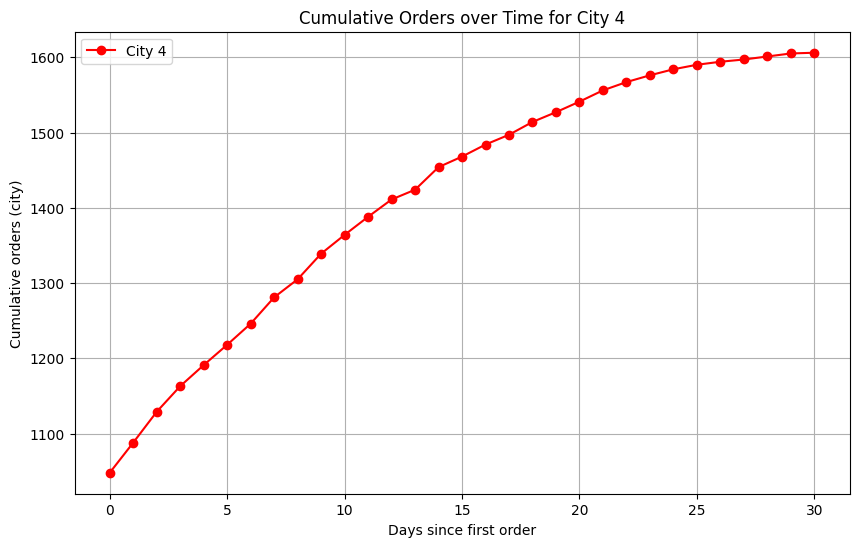

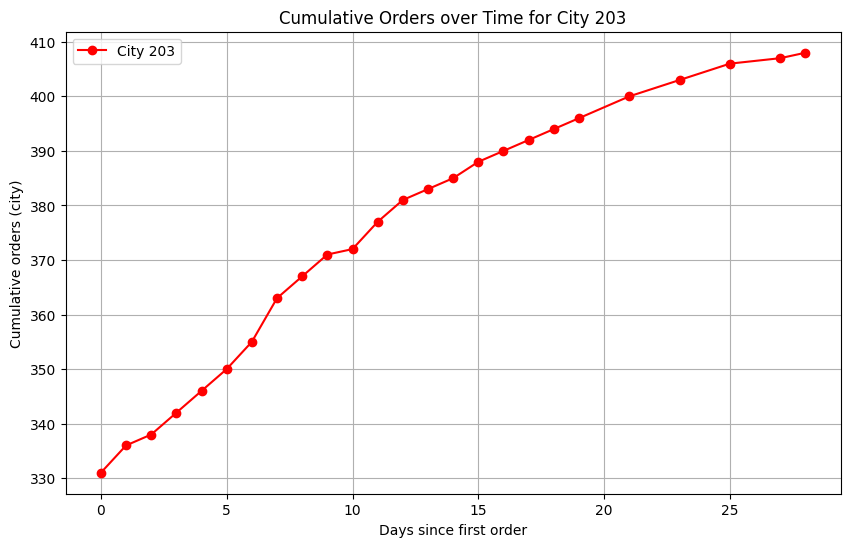

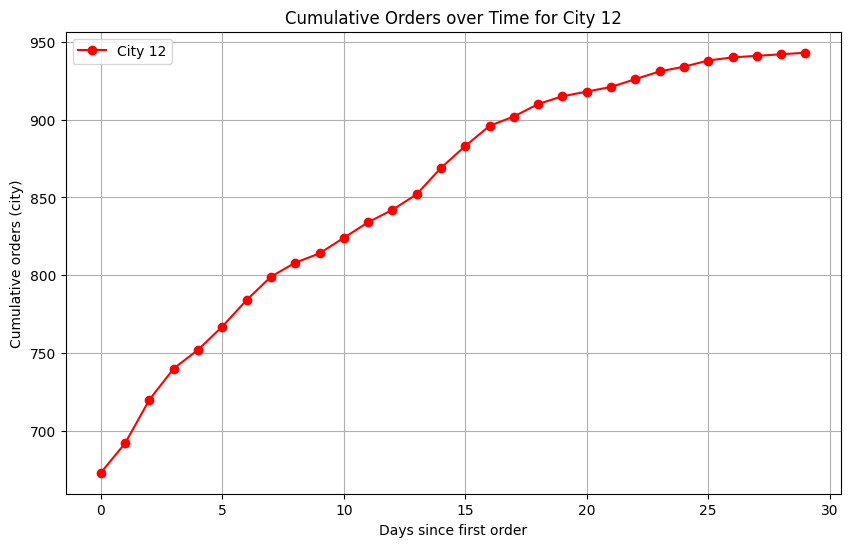

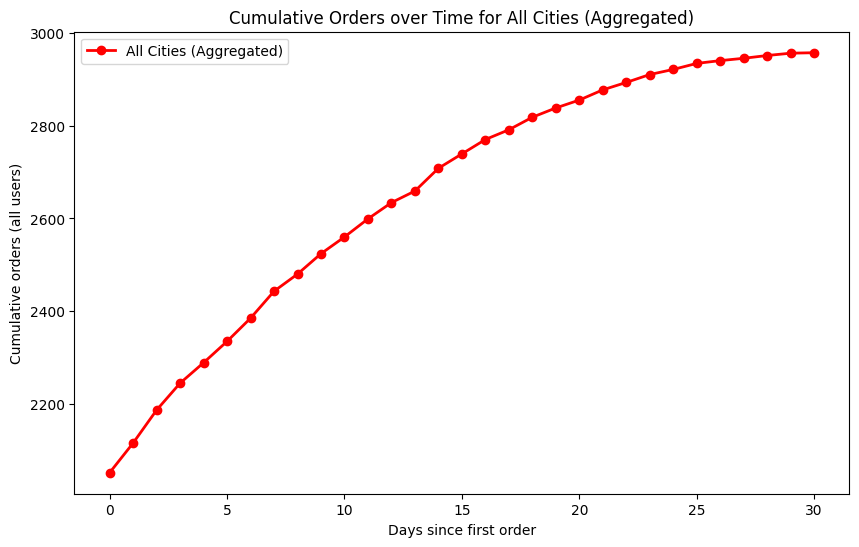

In [1470]:
plot_cumulative_orders_by_city(dps_all)

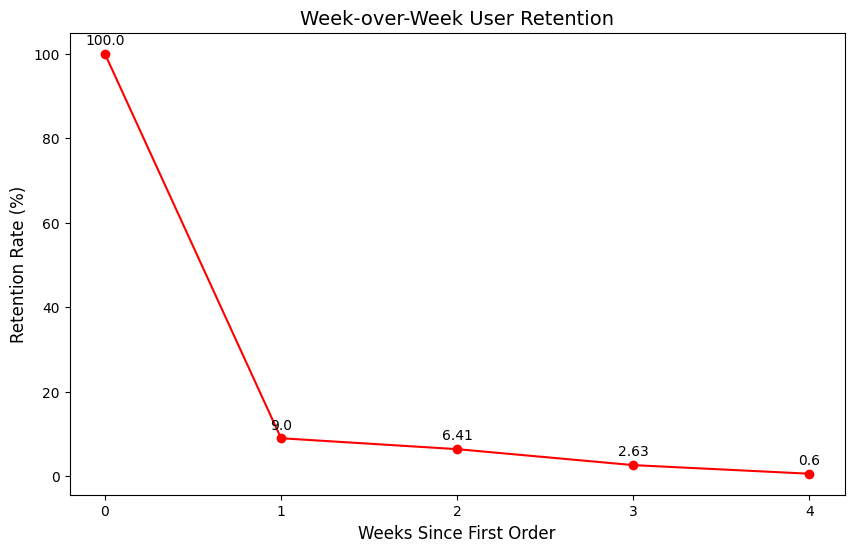

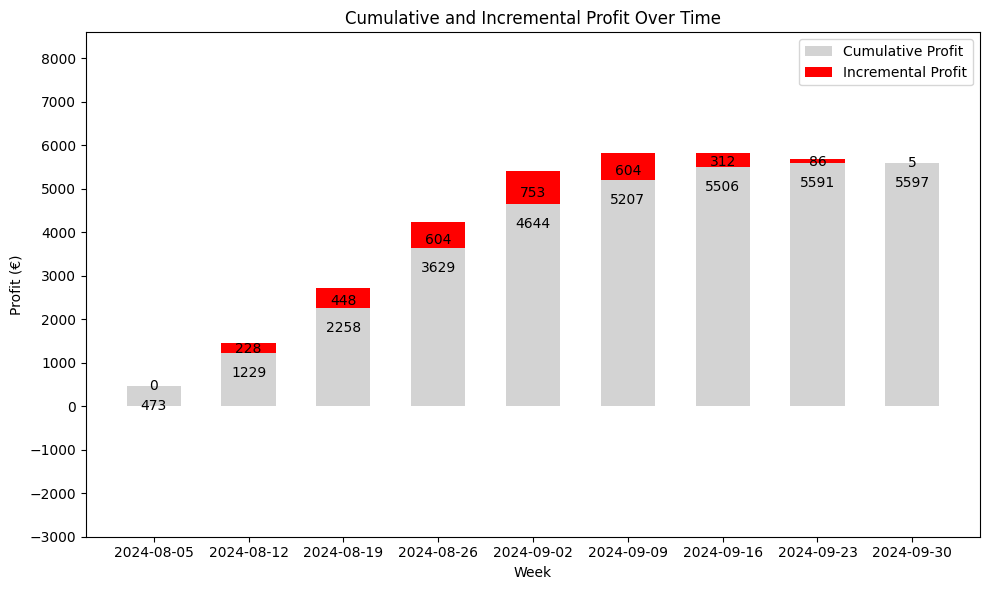

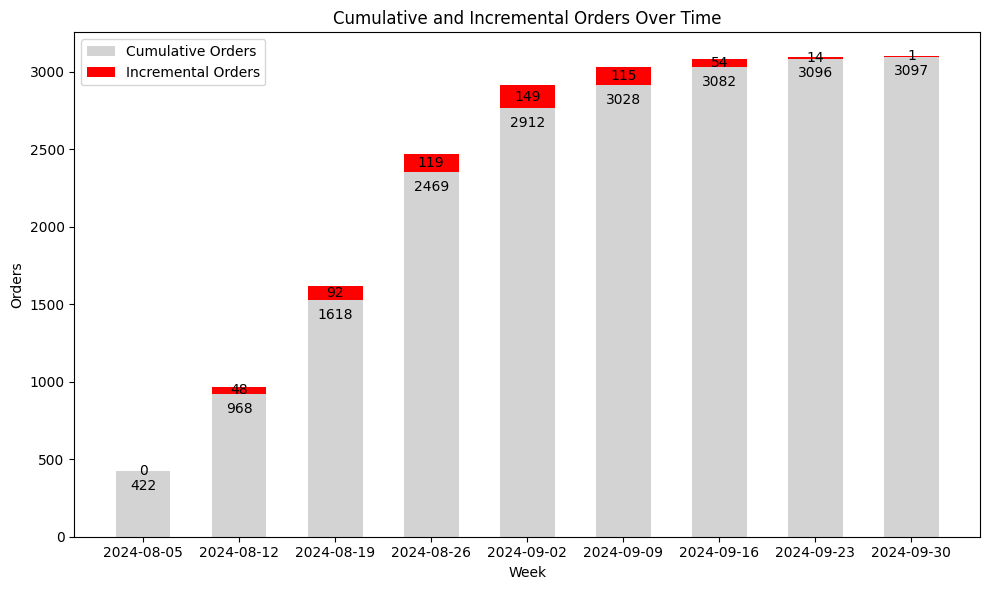

In [1491]:
retention_df = create_retention_d(dps_all)
forecast_retention_df = estimated_retained_customers(dps_all, retention_df)
forecast_df = impact_summary(forecast_retention_df)
forecast_df_final = impact_summary_w_cost(dps_all, forecast_df)

plot_cumulative_incremental_profit(forecast_df_final)
plot_cumulative_incremental_orders(forecast_df_final)


# VOUCHER ANALYSIS

In [1492]:
voucher_new = client.query(voucher_new_v()).to_dataframe()
voucher_all = client.query(voucher_all_v()).to_dataframe()

In [1493]:
tmp = voucher_new[['platform_order_code','voucher_code','voucher_amount_eur']]
tmp2 = voucher_all.drop(columns=['voucher_code', 'voucher_amount_eur'])

voucher_all = pd.merge(tmp2,tmp , on = 'platform_order_code',how = 'left')

In [1494]:
### VOUCHER ANALYSIS NEW CUSTOMERS ###

## missing values ##
missing_value_before = voucher_new.isna().sum()
missing_columns_before = missing_value_before[missing_value_before != 0]

print(missing_columns_before)

columns_to_fill = ['voucher_amount_eur','delivery_costs_eur','delivery_distance']

voucher_new[columns_to_fill] = voucher_new[columns_to_fill].fillna(0)

missing_value_after = voucher_new.isna().sum()
missing_columns_after =  missing_value_after[missing_value_after != 0]

print(missing_columns_after)


## summary of first order data ###

# first order ##

voucher_new = handle_customer_first_order_date(voucher_new)

## DATA CHECKS ##
print(f'Are there any users with orders with 0 DPS delivery fee before the intervention date?', {check_first_order_before_intervention(voucher_new)})
print(f'Are there any users with multiple orders as characterized as new customer first time order?', {check_duplicate_orders(voucher_new)})
print(f'Are there any orders with 0 delivery fee which will be used to assess the cost?',{check_zero_delivery_fee(voucher_new)})
print(F'How many orders had both free delivery and vouchers?',{count_orders_with_vouchers(voucher_new)})


### convert numeric data to float ###

columns_to_convert = ['dps_delivery_fee_eur',
       'delivery_fee_eur', 'delivery_fee_local', 'dps_travel_time_fee_eur',
       'dps_standard_fee_eur', 'vendor_funding_amount_local',
       'dps_last_non_zero_df_eur', 'delivery_fee_vat_eur',
       'delivery_fee_vat_local', 'delivery_fee_option', 'priority_fee_eur',
       'saver_discount_eur', 'gfv_eur', 'gfv_local', 'gmv_eur', 'gmv_local',
       'profit_eur', 'profit_local', 'revenue_eur', 'revenue_local',
       'mov_customer_fee_eur', 'service_fee_eur', 'dps_service_fee_eur',
       'delivery_distance', 'delivery_costs_eur', 'delivery_costs_local',
       'joker_vendor_fee_eur','completed_orders', 'fully_loaded_gross_profit_eur', 'commission_eur',
        'voucher_amount_eur']

voucher_new[columns_to_convert] = voucher_new[columns_to_convert].apply(pd.to_numeric, errors='coerce').astype(float)

analyze_city_orders(voucher_new)

customer_first_order_date      417
dps_standard_fee_eur           284
vendor_funding_amount_local    396
delivery_fee_option              4
saver_discount_eur             426
new_customer_condition_type    416
dtype: int64
customer_first_order_date      417
dps_standard_fee_eur           284
vendor_funding_amount_local    396
delivery_fee_option              4
saver_discount_eur             426
new_customer_condition_type    416
dtype: int64
Are there any users with orders with 0 DPS delivery fee before the intervention date? {'yes'}
Are there any users with multiple orders as characterized as new customer first time order? {0}
Are there any orders with 0 delivery fee which will be used to assess the cost? {0.0}
How many orders had both free delivery and vouchers? {426}


city_name_var,Orebro-pre,Uppsala-pre,Vasteras-pre,Total
total_users,128.0,170.0,128.0,426.0
total_orders,128.0,170.0,128.0,426.0
total_completed_orders,128.0,170.0,128.0,426.0
voucher_based_orders,128.0,170.0,128.0,426.0
orders_per_user,1.0,1.0,1.0,1.0
c_orders_per_user,1.0,1.0,1.0,1.0
actual_delivery_fee_per_order,2.66,2.41,2.77,2.59
forgone_delivery_fee_per_order,1.69,1.15,1.25,1.34
voucher_eur_per_order,12.9,12.9,12.93,12.91
acquistion_cost_per_order,14.59,14.05,14.18,14.25


In [1495]:
### DPS ANALYSIS ALL CUSTOMERS ###

## missing values ##
missing_value_before = voucher_all.isna().sum()
missing_columns_before = missing_value_before[missing_value_before != 0]

print(missing_columns_before)

columns_to_fill = ['voucher_amount_eur','delivery_costs_eur','delivery_distance']

voucher_all[columns_to_fill] = voucher_all[columns_to_fill].fillna(0)

missing_value_after = voucher_all.isna().sum()
missing_columns_after =  missing_value_after[missing_value_after != 0]

print(missing_columns_after)


## summary of first order data ###

# first order ##

voucher_all = handle_customer_first_order_date(voucher_all)

## DATA CHECKS ##
print(f'Are there any users with orders with 0 DPS delivery fee before the intervention date?', {check_first_order_before_intervention(voucher_all)})
print(f'Are there any orders with 0 delivery fee which will be used to assess the cost?',{check_zero_delivery_fee(voucher_all)})
print(F'How many orders had both free delivery and vouchers?',{count_orders_with_vouchers(voucher_all)})


### convert numeric data to float ###

columns_to_convert = ['dps_delivery_fee_eur',
       'delivery_fee_eur', 'delivery_fee_local', 'dps_travel_time_fee_eur',
       'dps_standard_fee_eur', 'vendor_funding_amount_local',
       'dps_last_non_zero_df_eur', 'delivery_fee_vat_eur',
       'delivery_fee_vat_local', 'delivery_fee_option', 'priority_fee_eur',
       'saver_discount_eur', 'gfv_eur', 'gfv_local', 'gmv_eur', 'gmv_local',
       'profit_eur', 'profit_local', 'revenue_eur', 'revenue_local',
       'mov_customer_fee_eur', 'service_fee_eur', 'dps_service_fee_eur',
       'delivery_distance', 'delivery_costs_eur', 'delivery_costs_local',
       'joker_vendor_fee_eur','completed_orders', 'fully_loaded_gross_profit_eur', 'commission_eur',
        'voucher_amount_eur']

voucher_all[columns_to_convert] = voucher_all[columns_to_convert].apply(pd.to_numeric, errors='coerce').astype(float)

voucher_post = voucher_all[voucher_all['voucher_code'].isna()]

analyze_city_orders(voucher_post)

customer_first_order_date      494
dps_standard_fee_eur           341
vendor_funding_amount_local    478
delivery_fee_option              6
saver_discount_eur             512
delivery_distance                4
delivery_costs_eur               3
delivery_costs_local             3
new_customer_condition_type    500
voucher_code                    86
voucher_amount_eur              86
dtype: int64
customer_first_order_date      494
dps_standard_fee_eur           341
vendor_funding_amount_local    478
delivery_fee_option              6
saver_discount_eur             512
delivery_costs_local             3
new_customer_condition_type    500
voucher_code                    86
dtype: int64
Are there any users with orders with 0 DPS delivery fee before the intervention date? {'yes'}
Are there any orders with 0 delivery fee which will be used to assess the cost? {0.0}
How many orders had both free delivery and vouchers? {426}


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_10188/3264276343.py:336: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['foregone_delivery_fee'] = df.apply(


city_name_var,Orebro-pre,Uppsala-pre,Vasteras-pre,Total
total_users,12.0,30.0,17.0,59.0
total_orders,16.0,37.0,33.0,86.0
total_completed_orders,13.0,36.0,32.0,81.0
voucher_based_orders,0.0,0.0,0.0,0.0
orders_per_user,1.33,1.23,1.94,1.46
c_orders_per_user,1.08,1.2,1.88,1.37
actual_delivery_fee_per_order,2.04,2.55,2.71,2.52
forgone_delivery_fee_per_order,1.68,1.23,1.43,1.39
voucher_eur_per_order,0.0,0.0,0.0,0.0
acquistion_cost_per_order,1.68,1.23,1.43,1.39


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_10188/3102447160.py:510: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['created_date_local'] = pd.to_datetime(df['created_date_local'])
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_10188/3102447160.py:512: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['first_order_date'] = df.groupby('customer_account_id')['created_date_local'].transform('min')
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_10188/3102447160.py:514: Se

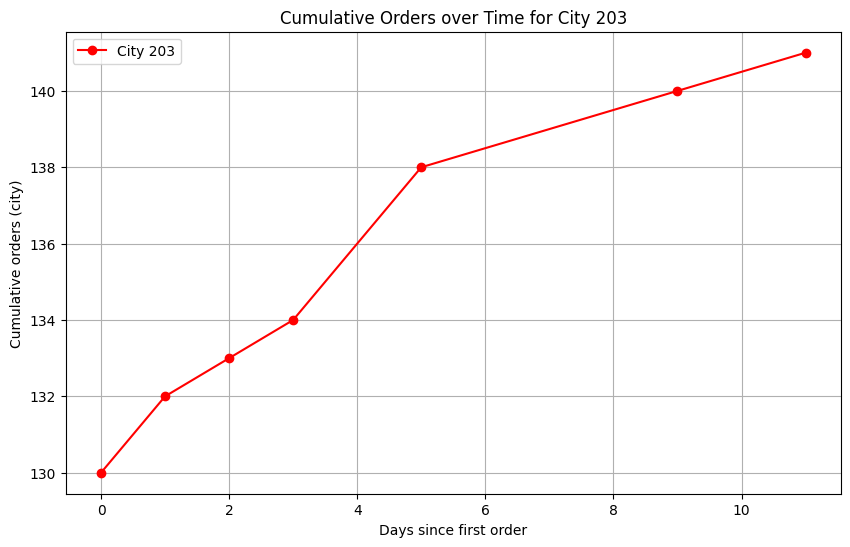

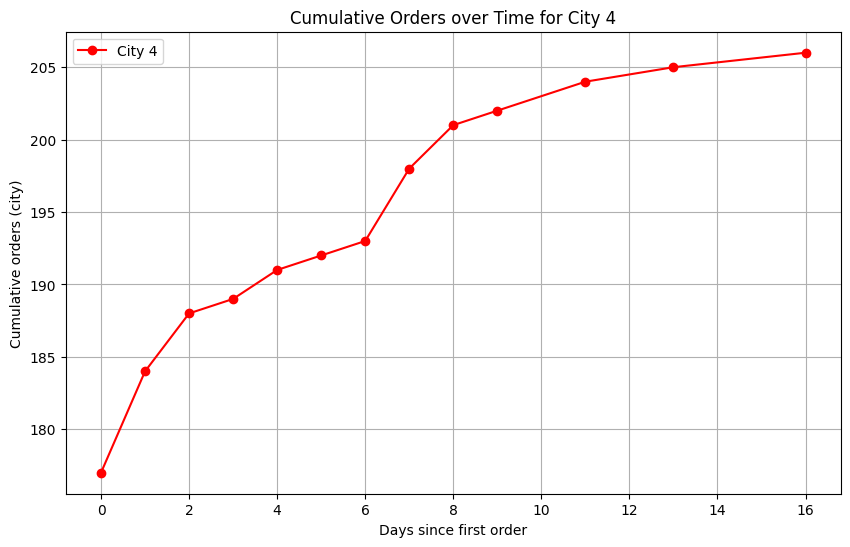

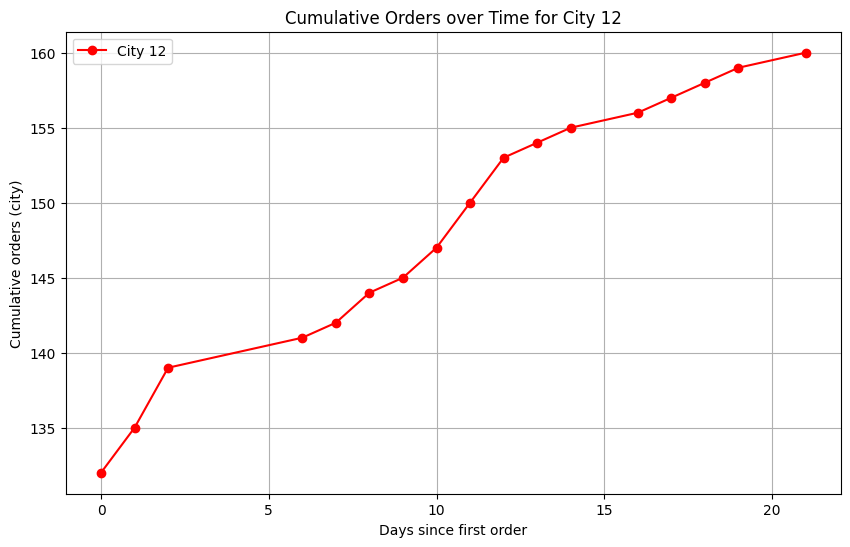

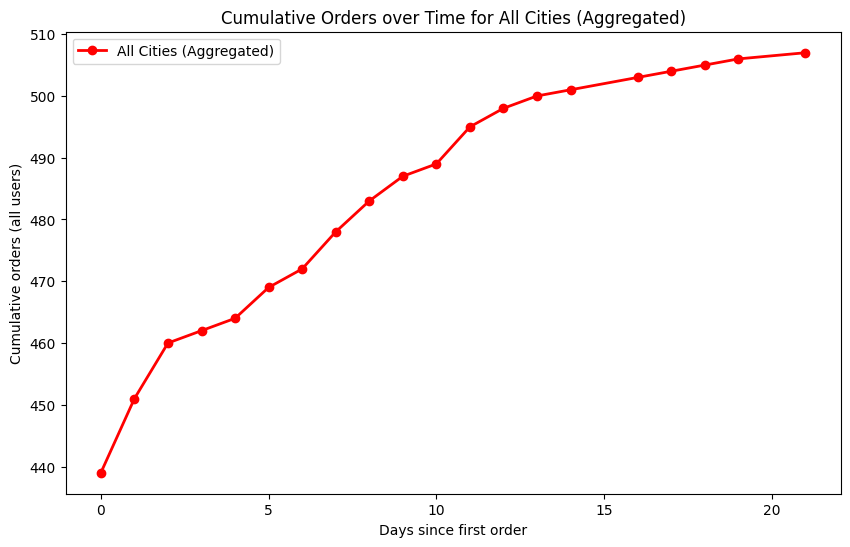

In [1426]:
plot_cumulative_orders_by_city(voucher_all)

In [1496]:
def create_retention_d_v(df):
   
    post_inter_df = df[df['is_sent'] == True].copy()

    post_inter_df['first_order_date'] = post_inter_df.groupby('customer_account_id')['created_date_local'].transform('min')

    post_inter_df['week_diff'] = ((post_inter_df['created_date_local'] - post_inter_df['first_order_date']).dt.days // 7)

    total_users = post_inter_df['customer_account_id'].nunique()

    retention_df = post_inter_df.groupby('week_diff').agg(
        users_retained=('customer_account_id', 'nunique'),
        orders_made=('completed_orders', 'sum'),
        profit_made=('profit_eur', 'sum'),
        flgp=('fully_loaded_gross_profit_eur', 'sum')
    )

    retention_df['retention_rate'] = (retention_df['users_retained'] / total_users) * 100
    retention_df['orders_per_user'] = (retention_df['orders_made'] / retention_df['users_retained'])
    retention_df['profit_per_order'] = (retention_df['profit_made'] / retention_df['orders_made'])
    retention_df['flgpo'] = (retention_df['flgp'] / retention_df['orders_made'])

    x = retention_df.index
    y = retention_df['retention_rate']

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o', color='red', linestyle='-')

    for i in range(len(x)):
        plt.text(i, y[i] + 1.5, round(y[i], 2), ha='center', va='bottom')

    plt.xlabel('Weeks Since First Order', fontsize=12)
    plt.ylabel('Retention Rate (%)', fontsize=12)
    plt.title('Week-over-Week User Retention', fontsize=14)
    plt.grid(False)
    plt.xticks(retention_df.index)
    plt.show()

    retention_df = retention_df.round(2).reset_index()

    return retention_df

def estimated_retained_customers_v(df, r_df, week_diff_range=5):
  
    weekly_new_customers = df.groupby('week').agg(
        new_customers=('customer_account_id', lambda x: np.sum(~df.loc[x.index, 'voucher_code'].isna())
    )).reset_index()

    long_form_retained_customers = pd.DataFrame()

    # Loop over the week_diff range to calculate the retention impact for each week
    for i in range(0, week_diff_range):
        temp_df = weekly_new_customers.copy()
        temp_df['week_diff'] = i
        temp_df['Retained_Customers'] = round(
            temp_df['new_customers'] * ((r_df.loc[r_df['week_diff'] == i, 'retention_rate'].values[0]) / 100), 0
        )
        temp_df['Orders_per_User'] = r_df.loc[r_df['week_diff'] == i, 'orders_per_user'].values[0]
        temp_df['Profit_per_Order'] = r_df.loc[r_df['week_diff'] == i, 'profit_per_order'].values[0]
        temp_df['flgp_per_order'] = r_df.loc[r_df['week_diff'] == i, 'flgpo'].values[0]

        # Calculate total orders, total profit, and FLGP
        temp_df['Total_Orders'] = temp_df['Retained_Customers'] * temp_df['Orders_per_User']
        temp_df['Total_Profit'] = temp_df['Total_Orders'] * temp_df['Profit_per_Order']
        temp_df['FLGP'] = temp_df['Total_Orders'] * temp_df['flgp_per_order']

        # Concatenate results
        long_form_retained_customers = pd.concat([long_form_retained_customers, temp_df], ignore_index=True)

    # Select the relevant columns
    long_form_retained_customers = long_form_retained_customers[['week', 'new_customers', 'week_diff', 'Retained_Customers',
                                                                 'Orders_per_User', 'Profit_per_Order', 'flgp_per_order',
                                                                 'Total_Orders', 'Total_Profit', 'FLGP']]

    # Convert week column to datetime and calculate final week
    long_form_retained_customers['week'] = pd.to_datetime(long_form_retained_customers['week'])
    long_form_retained_customers['final_week'] = long_form_retained_customers['week'] + pd.to_timedelta(long_form_retained_customers['week_diff'] * 7, unit='D')

    return long_form_retained_customers



def impact_summary(df):
    
    # Group by 'final_week' and calculate aggregate and incremental metrics
    total_impact = df.groupby('final_week').agg(
        Total_Orders=('Total_Orders', 'sum'), 
        Total_Profit=('Total_Profit', 'sum'),
        Total_FLGP=('FLGP', 'sum'),
        incremental_orders=('Total_Orders', lambda x: x[df.loc[x.index, 'week_diff'].isin([1, 2, 3, 4, 5])].sum()),
        incremental_profit=('Total_Profit', lambda x: x[df.loc[x.index, 'week_diff'].isin([1, 2, 3, 4, 5])].sum()),
        incremental_flgp=('FLGP', lambda x: x[df.loc[x.index, 'week_diff'].isin([1, 2, 3, 4, 5])].sum())
    ).reset_index()
    
    # Calculate cumulative values
    total_impact['total_orders_cum'] = total_impact['Total_Orders'].cumsum()
    total_impact['total_profit_cum'] = total_impact['Total_Profit'].cumsum()
    total_impact['total_flgp_cum'] = total_impact['Total_FLGP'].cumsum()
    
    return total_impact


def impact_summary_w_cost(df, df1):

    cost_df = df.copy()

    cost_df['foregone_delivery_fee'] = cost_df.apply(
        lambda row: row['dps_standard_fee_eur'] if row['dps_delivery_fee_eur'] == 0 or pd.isnull(row['dps_delivery_fee_eur']) else 0,
        axis=1
    )

    w_cost_df = cost_df.groupby('week').agg({
        'foregone_delivery_fee': 'sum',
        'voucher_amount_eur': 'sum'
    }).reset_index()

    w_cost_df['total_cost'] = w_cost_df['foregone_delivery_fee']

    w_cost_df.rename(columns={'week': 'final_week'}, inplace=True)

    w_cost_df['final_week'] = pd.to_datetime(w_cost_df['final_week'])
    df1['final_week'] = pd.to_datetime(df1['final_week'])

    final_df = pd.merge(df1, w_cost_df, on='final_week', how='left')

    final_df['total_cost'] = final_df['total_cost'].astype(float)
    final_df.fillna(0, inplace=True)

    final_df['total_cost_cum'] = final_df['total_cost'].cumsum()


    return final_df



def plot_cumulative_incremental_profit(df):
    plt.figure(figsize=(10, 6))

    bars1 = plt.bar(df['final_week'], df['total_flgp_cum'], label='Cumulative Profit', width=4, align='center', color='lightgrey')

    bars2 = plt.bar(df['final_week'], df['incremental_profit'], label='Incremental Profit', width=4, align='center',
                    bottom=np.where(df['total_flgp_cum'] >= 0, df['total_flgp_cum'], df['total_flgp_cum']),
                    color='red')

    for i, bar in enumerate(bars1):
        height = bar.get_height()

        if not np.isnan(height):
            if height < 0:
                plt.text(bar.get_x() + bar.get_width() / 2.0, height - 100, f'{int(height)}',
                         ha='center', va='top', color='black')
            else:
                plt.text(bar.get_x() + bar.get_width() / 2.0, height + 100, f'{int(height)}',
                         ha='center', va='top', color='black')

    for i, bar in enumerate(bars2):
        height = bar.get_height()
        bottom = bar.get_y()

        if not np.isnan(height):
            plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2, f'{int(abs(height))}',
                     ha='center', va='center', color='white')

    plt.title('Cumulative and Incremental Profit Over Time')
    plt.xlabel('Week')
    plt.ylabel('Profit (€)')

    plt.xticks(df['final_week'])

    ymin = df[['total_flgp_cum', 'incremental_profit']].min().min() - 3000
    ymax = df[['total_flgp_cum', 'incremental_profit']].max().max() + 3000

    plt.ylim(ymin, ymax)
    plt.yticks(np.arange(np.floor(ymin / 1000) * 1000, np.ceil(ymax / 1000) * 1000, 1000))

    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_cumulative_incremental_orders(df):
    plt.figure(figsize=(10, 6))

    bars1 = plt.bar(df['final_week'], df['total_orders_cum'], width=4, align='center', label='Cumulative Orders', color='lightgrey')

    bars2 = plt.bar(df['final_week'], df['incremental_orders'], width=4, align='center', label='Incremental Orders', 
                    bottom=df['total_orders_cum'] - df['incremental_orders'], color='red')

    for i, bar in enumerate(bars1):
        height = bar.get_height()
        incremental_height = df['incremental_orders'].iloc[i]

        if not np.isnan(height) and not np.isnan(incremental_height):
            plt.text(bar.get_x() + bar.get_width() / 2.0, height - incremental_height - 50,
                     f'{int(height)}', ha='center', va='top', color='black')

    for i, bar in enumerate(bars2):
        height = bar.get_height()
        bottom = bar.get_y()

        if not np.isnan(height):
            plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2, f'{int(height)}', ha='center', va='center', color='white')

    plt.title('Cumulative and Incremental Orders Over Time')
    plt.xlabel('Week')
    plt.ylabel('Orders')

    plt.xticks(df['final_week'])

    plt.legend()
    plt.tight_layout() 
    plt.show()

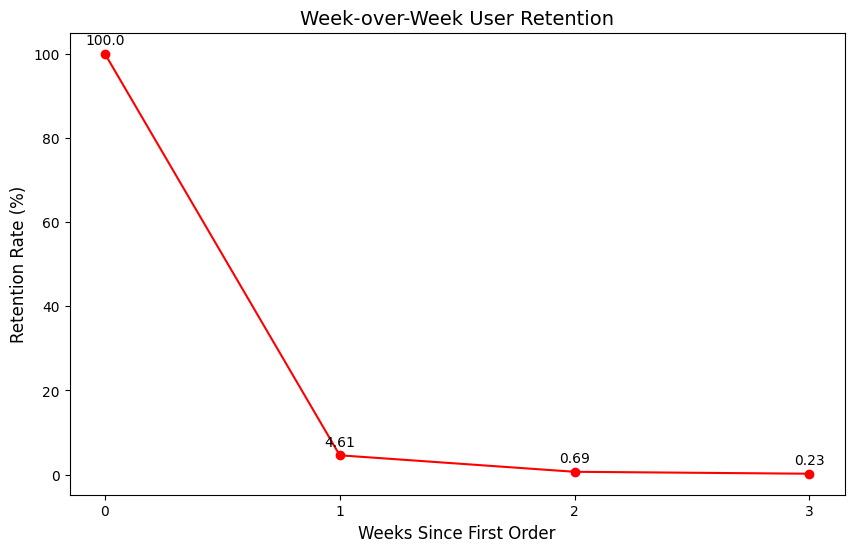

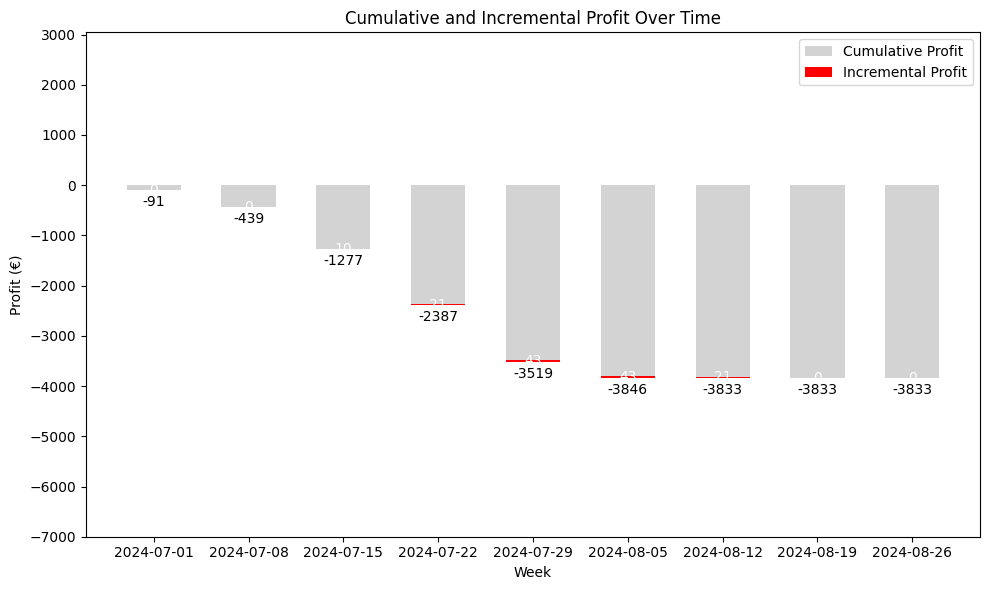

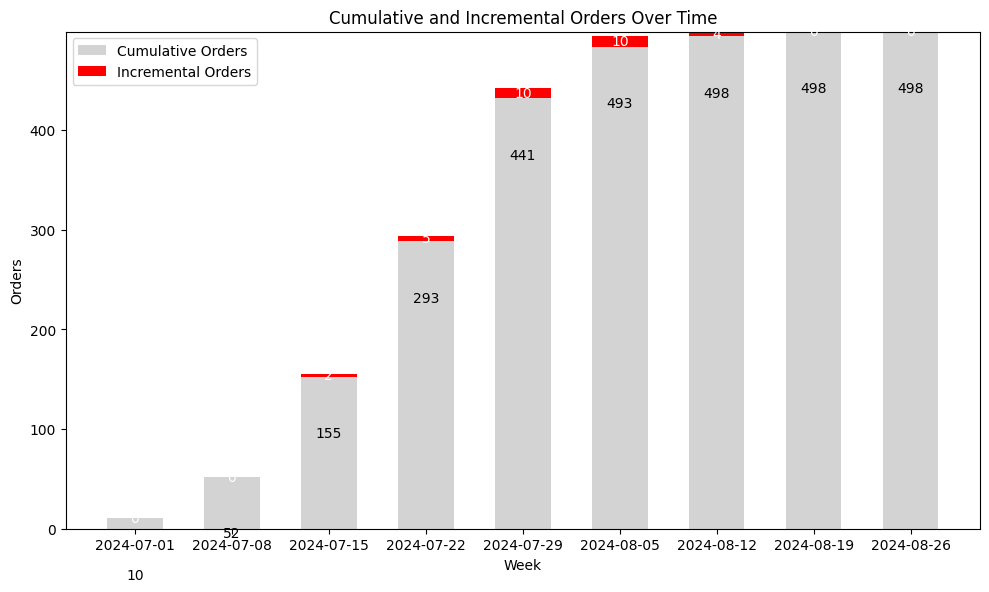

In [1497]:
retention_df = create_retention_d_v(voucher_all)
forecast_retention_df = estimated_retained_customers_v(voucher_all, retention_df,len(retention_df))
forecast_df = impact_summary(forecast_retention_df)
forecast_df_final = impact_summary_w_cost(voucher_all, forecast_df)

plot_cumulative_incremental_profit(forecast_df_final)
plot_cumulative_incremental_orders(forecast_df_final)

In [1343]:
# def summary(start_date, end_date):

#     query = """
#     with pre as (
#     SELECT    
#             smto.city_id
#             ,smto.city_name
#             ,smto.customer_account_id
#             ,count(distinct smto.order_id) orders
#             ,SUM(gfv_eur) AS gfv_eur
#             ,SUM(dps_delivery_fee_eur) delivery_fee_eur
#             ,sum(gmv_eur) gmv_eur
#     FROM
#         `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto 
#     WHERE 
#         smto.country_code = 'se'
#         AND smto.created_date_local BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#         and has_new_customer_condition is true
#         group by 1,2,3
#     """

#     return query


# def data(start_date, end_date):

#     query = """
#     SELECT   smto.city_id
#         ,smto.city_name
#         ,extract(ISOWEEK from smto.created_date_local) week
#         ,created_date_local date
#         ,count(distinct smto.customer_account_id) total_users
#         ,count(distinct smto.order_id) total_orders
#         ,COUNT(DISTINCT smto.order_id) / NULLIF(COUNT(DISTINCT smto.customer_account_id), 0) AS order_per_user
#         ,SUM(gfv_eur) AS gfv_eur
#         ,SUM(gfv_eur) / NULLIF(COUNT(DISTINCT smto.customer_account_id), 0) AS gfv_eur_per_user
#         ,SUM(dps_delivery_fee_eur) / NULLIF(COUNT(DISTINCT smto.order_id), 0) AS delivery_fee_per_order
#         ,sum(gmv_eur) gmv_eur
#     FROM 
#         `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto 
#     WHERE 
#         smto.country_code = 'se'
#         AND smto.created_date_local BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#         and has_new_customer_condition is true
#         group by 1,2,3,4
#     """

#     return query

# def new_customer_pre():

#     query = """
#     select  o.city_name
#         ,date_trunc(created_date_local,ISOWEEK) week
#         ,created_date_local
#         ,o.customer_account_id
#         ,o.order_id
#     from `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` o
#     where o.customer_account_id in (
#     SELECT   smto.customer_account_id
#     FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
#     WHERE smto.country_code = 'se'
#         AND smto.created_date_local BETWEEN DATE_SUB('2024-08-05', INTERVAL 28 DAY) AND '2024-08-05'
#         AND (date(smto.customer_first_order_date) BETWEEN DATE_SUB('2024-08-05', INTERVAL 28 DAY) AND '2024-08-05'
#             OR smto.customer_first_order_date IS NULL)
#         AND city_name IN ('Uppsala', 'Vasteras', 'Helsinborg', 'Orebro')
#     )
#     and o.created_date_local BETWEEN DATE_SUB('2024-08-05', INTERVAL 28 DAY) AND '2024-08-05'
#     and city_name IN ('Uppsala', 'Vasteras', 'Helsinborg', 'Orebro')
#     """

#     return query

# def new_customer_post():

#     query = """
#     select  o.city_name
#         ,date_trunc(created_date_local,ISOWEEK) week
#         ,created_date_local
#         ,o.customer_account_id
#         ,o.order_id
#     from `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` o
#     where o.customer_account_id in (
#     SELECT   smto.customer_account_id
#     FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
#     WHERE smto.country_code = 'se'
#         and has_new_customer_condition is true
#         and new_customer_condition_type = 'TOTAL'
#         AND city_name IN ('Uppsala', 'Vasteras', 'Helsinborg', 'Orebro')
#     )
#     and o.created_date_local BETWEEN '2024-08-06' AND DATE_ADD('2024-08-05', INTERVAL 28 DAY)
#     and city_name IN ('Uppsala', 'Vasteras', 'Helsinborg', 'Orebro')
#     """

#     return query

# def new_customer_post():

#     query = """
#     SELECT   smto.city_id
#             ,smto.city_name
#             ,CONCAT(city_name , "-", "post") city_name_var
#             ,created_date_local
#             ,date_trunc(created_date_local, ISOWEEK) week
#             ,smto.customer_account_id
#             ,smto.customer_first_order_date
#             ,smto.order_id
#             ,dps_delivery_fee_eur
#             ,gfv_eur
#             ,profit_eur
#             ,revenue_eur
#             ,delivery_distance
#             ,delivery_costs_eur
#             ,(case 
#                     when date(customer_first_order_date) BETWEEN '2024-08-06' AND DATE_ADD('2024-08-06', INTERVAL 28 DAY) 
#                     then customer_account_id 
#                     else NULL 
#                 end) AS first_order_date_in_range,

#                 (case 
#                     when date(customer_first_order_date) < '2024-08-06'
#                     then customer_account_id 
#                     else NULL 
#                 end) AS first_order_date_before_range,

#                 (case 
#                     when date(customer_first_order_date) > DATE_ADD('2024-08-06', INTERVAL 28 DAY) 
#                     then customer_account_id 
#                     else NULL 
#                 end) AS first_order_date_after_range,

#                 (case 
#                     when date(customer_first_order_date) is null 
#                     then customer_account_id 
#                     else NULL 
#                 end) AS first_order_date_empty,

#                 (case 
#                     when has_new_customer_condition = TRUE 
#                         and new_customer_condition_type = 'TOTAL' 
#                     then dps_delivery_fee_eur 
#                     else NULL 
#                 end) AS dps_delivery_fee_first_orders
#     FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
#     WHERE customer_account_id in 
#     (   SELECT  o.customer_account_id
#         FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` o
#         WHERE smto.country_code = 'se'
#             AND smto.created_date_local BETWEEN '2024-08-06' AND DATE_ADD('2024-08-06', INTERVAL 28 DAY)
#             and has_new_customer_condition is true
#             and new_customer_condition_type = 'TOTAL'
#             and city_name in ('Uppsala','Vasteras','Helsinborg','Orebro')
#     )
#     AND smto.created_date_local BETWEEN '2024-08-06' AND DATE_ADD('2024-08-06', INTERVAL 28 DAY)
#     AND city_name in ('Uppsala','Vasteras','Helsinborg','Orebro')
#     """

#     return query

    
# def new_customer_pre():

#     query = """
#     select  smto.city_id
#             ,smto.city_name 
#             ,CONCAT(city_name , "-", "pre") city_name_var
#             ,created_date_local
#             ,date_trunc(created_date_local, ISOWEEK) week
#             ,smto.customer_account_id
#             ,smto.customer_first_order_date
#             ,smto.order_id
#             ,dps_delivery_fee_eur
#             ,gfv_eur
#             ,profit_eur
#             ,revenue_eur
#             ,delivery_distance
#             ,delivery_costs_eur
#             ,(case 
#                     when DATE(customer_first_order_date) BETWEEN DATE_SUB('2024-08-06', INTERVAL 28 DAY) AND '2024-08-06' 
#                     then customer_account_id 
#                     else NULL 
#                 end) AS first_order_date_in_range,

#                 (case 
#                     when DATE(customer_first_order_date) < DATE_SUB('2024-08-06', INTERVAL 28 DAY) 
#                     then customer_account_id 
#                     else NULL 
#                 end) AS first_order_date_before_range,

#                 (case 
#                     when DATE(customer_first_order_date) > '2024-08-06' 
#                     then customer_account_id 
#                     else NULL 
#                 end) AS first_order_date_after_range,

#                 (case 
#                     when customer_first_order_date IS NULL 
#                     then customer_account_id 
#                     else NULL 
#                 end) AS first_order_date_empty,

#                 (case 
#                     when customer_first_order_date IS NULL 
#                     then dps_delivery_fee_eur 
#                     else NULL 
#                 end) AS dps_delivery_fee_first_orders
#     from `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
#     where smto.customer_account_id in (
#     SELECT customer_account_id 
#     FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` 
#     WHERE global_entity_id='OP_SE'
#     AND partition_date_local BETWEEN DATE_SUB('2024-08-06', INTERVAL 28 DAY) AND '2024-08-06'
#     AND (vouchers[SAFE_OFFSET(0)].voucher_code in ('nyburgare','mumsigt','sushi','pinktreasure3','pinktreasure1','stepler2024','pinktreasure2','megagott','mums150','flyttpizza','sthlm','söderhamn','norpan','örebro','borås200','bålsta','hejlerum','örebro200','solstan','gynningberg','kinna','lerum')
#     OR (vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2405%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2404%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2406%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'alumni2405%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2402b%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2402a%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2401b%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2311a%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2309b%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2310%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'cc150a%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'pk2001%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'pk300%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'dice2405%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2308%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'pk3001%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'alumni2308%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'pk1001%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'awi2404c%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2309%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'pk200%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'alumni2311%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'sd2307%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'huub2103%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'awi2415c%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'huuf2012%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'cc150ja%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'ggift2312d%'
#         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'gg2404e%'))
#     )
#     AND date(order_placed_at_local) BETWEEN DATE_SUB('2024-08-06', INTERVAL 28 DAY) AND '2024-08-06'
#     AND entity_id ='OP_SE'
#     AND city_name in ('Uppsala','Vasteras','Helsinborg','Orebro')

#     """

#     return query


# def first_order_nc():

#     query = """
#     with dps_data (
#     SELECT  smto.entity_id
#             ,smto.country_code
#             ,smto.city_id
#             ,smto.city_name
#             ,CONCAT(smto.city_name , "-", "post") city_name_var
#             ,smto.created_date_local
#             ,date_trunc(created_date_local, ISOWEEK) week
#             ,date_trunc(created_date_local, MONTH) month
#             ,smto.customer_account_id
#             ,smto.customer_first_order_date
#             ,smto.order_id
#             ,smto.dps_delivery_fee_eur
#             ,smto.delivery_fee_eur
#             ,smto.gfv_eur
#             ,smto.profit_eur
#             ,smto.revenue_eur
#             ,smto.delivery_distance
#             ,smto.delivery_costs_eur
#             ,smto.is_sent
#             ,smto.is_own_delivery
#             ,smto.vertical_type
#             ,(case when is_sent = TRUE and is_own_delivery = TRUE then platform_order_code else null end) completed_orders
#             ,fully_loaded_gross_profit_eur
#             ,smto.commission_eur
#             ,smto.platform_order_code     
#     FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
#     WHERE smto.entity_id = 'OP_SE'
#         AND smto.created_date_local BETWEEN '2024-08-06' AND DATE_ADD('2024-08-06', INTERVAL 28 DAY)
#         and has_new_customer_condition is true
#         and new_customer_condition_type = 'TOTAL'
#         AND city_name in ('Uppsala','Vasteras','Helsinborg','Orebro')
#     ),
#     voucher_data (
#     SELECT  o.global_entity_id
#             ,order_id
#             ,o.customer_account_id
#             ,vouchers[SAFE_OFFSET(0)].voucher_code
#     FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` o
#     where global_entity_id='OP_SE'
#     AND partition_date_local BETWEEN DATE_SUB('2024-08-06', INTERVAL 28 DAY) AND '2024-08-06'
#     AND (vouchers[SAFE_OFFSET(0)].voucher_code in ('nyburgare', 'mumsigt','megagott','mums150')    
#     )
#     select *
#     from dps_data dd
#     left join voucher_data vd on vd.global_entity_id = dd.entity_id and vd.platform_order_code = dd.order_id

#     """

#     return query

In [1344]:
# def plot_cumulative_incremental_profit(df):
#     plt.figure(figsize=(10, 6))

#     bars1 = plt.bar(df['final_week'], df['net_profit_cum'], label='Cumulative Profit', width=4, align='center', color='lightgrey')

#     bars2 = plt.bar(df['final_week'], df['incremental_profit'], label='Incremental Profit', width=4, align='center',
#                     bottom=np.where(df['net_profit_cum'] >= 0, df['net_profit_cum'], df['net_profit_cum']),
#                     color='red')

#     for i, bar in enumerate(bars1):
#         height = bar.get_height()

#         if not np.isnan(height):
#             if height < 0:
#                 plt.text(bar.get_x() + bar.get_width() / 2.0, height - 100, f'{int(height)}',
#                          ha='center', va='top', color='black')
#             else:
#                 plt.text(bar.get_x() + bar.get_width() / 2.0, height + 100, f'{int(height)}',
#                          ha='center', va='top', color='black')

#     for i, bar in enumerate(bars2):
#         height = bar.get_height()
#         bottom = bar.get_y()

#         if not np.isnan(height):
#             plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2, f'{int(abs(height))}',
#                      ha='center', va='center', color='white')

#     plt.title('Cumulative and Incremental Profit Over Time')
#     plt.xlabel('Week')
#     plt.ylabel('Profit (€)')

#     plt.xticks(df['final_week'])

#     ymin = df[['net_profit_cum', 'incremental_profit']].min().min() - 3000
#     ymax = df[['net_profit_cum', 'incremental_profit']].max().max() + 3000

#     plt.ylim(ymin, ymax)
#     plt.yticks(np.arange(np.floor(ymin / 1000) * 1000, np.ceil(ymax / 1000) * 1000, 1000))

#     plt.legend()
#     plt.tight_layout()
#     plt.show()


# def plot_cumulative_incremental_orders(df):
#     plt.figure(figsize=(10, 6))

#     bars1 = plt.bar(df['final_week'], df['total_orders_cum'], width=4, align='center', label='Cumulative Orders', color='lightgrey')

#     bars2 = plt.bar(df['final_week'], df['incremental_orders'], width=4, align='center', label='Incremental Orders', 
#                     bottom=df['total_orders_cum'] - df['incremental_orders'], color='red')

#     for i, bar in enumerate(bars1):
#         height = bar.get_height()
#         incremental_height = df['incremental_orders'].iloc[i]

#         if not np.isnan(height) and not np.isnan(incremental_height):
#             plt.text(bar.get_x() + bar.get_width() / 2.0, height - incremental_height - 50,
#                      f'{int(height)}', ha='center', va='top', color='black')

#     for i, bar in enumerate(bars2):
#         height = bar.get_height()
#         bottom = bar.get_y()

#         if not np.isnan(height):
#             plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2, f'{int(height)}', ha='center', va='center', color='white')

#     plt.title('Cumulative and Incremental Orders Over Time')
#     plt.xlabel('Week')
#     plt.ylabel('Orders')

#     plt.xticks(df['final_week'])

#     plt.legend()
#     plt.tight_layout() 
#     plt.show()


# plot_cumulative_incremental_profit(forecast_df_final)
# plot_cumulative_incremental_orders(forecast_df_final)

In [1345]:


# def impact_summary_w_cost(df, df1):

#     cost_df = df.copy()

#     cost_df['foregone_delivery_fee'] = cost_df.apply(
#         lambda row: row['dps_standard_fee_eur'] if row['dps_delivery_fee_eur'] == 0 or pd.isnull(row['dps_delivery_fee_eur']) else 0,
#         axis=1
#     )

#     w_cost_df = cost_df.groupby('week').agg({
#         'foregone_delivery_fee': 'sum',
#         'voucher_amount_eur': 'sum'
#     }).reset_index()

#     w_cost_df['total_cost'] = w_cost_df['foregone_delivery_fee'] + w_cost_df['voucher_amount_eur']

#     w_cost_df.rename(columns={'week': 'final_week'}, inplace=True)

#     w_cost_df['final_week'] = pd.to_datetime(w_cost_df['final_week'])
#     df1['final_week'] = pd.to_datetime(df1['final_week'])

#     final_df = pd.merge(df1, w_cost_df, on='final_week', how='left')

#     final_df['total_cost'] = final_df['total_cost'].astype(float)
#     final_df.fillna(0, inplace=True)

#     final_df['total_cost_cum'] = final_df['total_cost'].cumsum()

#     final_df['net_profit'] = final_df['Total_FLGP'] - final_df['total_cost']
#     final_df['net_profit_cum'] = final_df['net_profit'].cumsum()

#     return final_df


# impact_summary_w_cost(dps_all, a)


In [1295]:
# ### impact estimation ##

# weekly_new_customers = dps_all.groupby('week').agg(
#     new_customers=('customer_account_id', lambda x: np.sum((dps_all.loc[x.index, 'has_new_customer_condition'] == True) & 
#                                                                 (dps_all.loc[x.index, 'new_customer_condition_type'] == 'TOTAL')))
# ).reset_index()

# retention_rates = retention_df

# long_form_retained_customers = pd.DataFrame()

# for i in range(0, 5):
#     temp_df = weekly_new_customers.copy()
#     temp_df['week_diff'] = i
#     temp_df['Retained_Customers'] = round(
#     temp_df['new_customers'] * ((retention_rates.loc[retention_rates['week_diff'] == i, 'retention_rate'].values[0]) / 100), 0
#     )
#     temp_df['Orders_per_User'] = retention_rates.loc[retention_rates['week_diff'] == i, 'orders_per_user'].values[0]
#     temp_df['Profit_per_Order'] = retention_rates.loc[retention_rates['week_diff'] == i, 'profit_per_order'].values[0]
#     temp_df['flgp_per_order'] = retention_rates.loc[retention_rates['week_diff'] == i, 'flgpo'].values[0]


#     temp_df['Total_Orders'] = temp_df['Retained_Customers'] * temp_df['Orders_per_User']
#     temp_df['Total_Profit'] = temp_df['Total_Orders'] * temp_df['Profit_per_Order']
#     temp_df['FLGP'] = temp_df['Total_Orders'] * temp_df['flgp_per_order']
    
#     long_form_retained_customers = pd.concat([long_form_retained_customers, temp_df], ignore_index=True)

# long_form_retained_customers = long_form_retained_customers[['week', 'new_customers', 'week_diff', 'Retained_Customers', 'Orders_per_User', 'Profit_per_Order','flgp_per_order', 'Total_Orders', 'Total_Profit','FLGP']]

# long_form_retained_customers

# long_form_retained_customers['week'] = pd.to_datetime(long_form_retained_customers['week'])

# long_form_retained_customers['final_week'] = long_form_retained_customers['week'] + pd.to_timedelta(long_form_retained_customers['week_diff'] * 7, unit='D')

In [1296]:
# total_impact = long_form_retained_customers.groupby('final_week').agg({'Total_Orders':'sum','Total_Profit':'sum'}).reset_index()

# total_impact = long_form_retained_customers.groupby('final_week').agg(
#     Total_Orders=('Total_Orders', 'sum'), 
#     Total_Profit=('Total_Profit', 'sum'),
#     Total_FLGP =  ('FLGP', 'sum'),
#     incremental_orders=('Total_Orders', lambda x: x[long_form_retained_customers.loc[x.index, 'week_diff'].isin([1, 2, 3, 4, 5])].sum()),
#     incremental_profit=('Total_Profit', lambda x: x[long_form_retained_customers.loc[x.index, 'week_diff'].isin([1, 2, 3, 4, 5])].sum()),
#     incremental_flgp=('FLGP', lambda x: x[long_form_retained_customers.loc[x.index, 'week_diff'].isin([1, 2, 3, 4, 5])].sum())
# ).reset_index()

# total_impact['total_orders_cum'] = total_impact['Total_Orders'].cumsum()
# total_impact['total_profit_cum'] = total_impact['Total_Profit'].cumsum()
# total_impact['total_flgp_cum'] = total_impact['Total_FLGP'].cumsum()


# total_impact

In [1297]:
# cost_df = dps_all.copy()

# cost_df['foregone_delivery_fee'] = cost_df.apply(
# lambda row: row['dps_standard_fee_eur'] if row['dps_delivery_fee_eur'] == 0 or pd.isnull(row['dps_delivery_fee_eur']) else 0,
# axis=1)

# w_cost_df = cost_df.groupby('week').agg({'foregone_delivery_fee': 'sum','voucher_amount_eur':'sum'}).reset_index()
# w_cost_df['total_cost'] = w_cost_df['foregone_delivery_fee'] + w_cost_df['voucher_amount_eur']

# w_cost_df.rename(columns={'week': 'final_week'}, inplace = True)

# w_cost_df['final_week'] = pd.to_datetime(w_cost_df['final_week'])  

# total_impact['final_week'] = pd.to_datetime(total_impact['final_week']) 

# final_df = pd.merge(total_impact, w_cost_df, on = 'final_week', how = 'left')

# final_df['total_cost'] = final_df['total_cost'].astype(float)
# final_df.fillna(0, inplace= True)
# final_df['total_cost_cum'] = final_df['total_cost'].cumsum()

# final_df['net_profit'] = final_df['Total_FLGP'] - final_df['total_cost']
# final_df['net_profit_cum'] = final_df['net_profit'].cumsum()

# final_df

In [1298]:
# cost_df = dps_all.groupby('week').agg({'dps_standard_fee_eur': 'sum','voucher_amount_eur'}).reset_index()

# cost_df.rename(columns={'week': 'final_week', 'dps_standard_fee_eur':'total_cost'}, inplace = True)

# cost_df['final_week'] = pd.to_datetime(cost_df['final_week'])  
# total_impact['final_week'] = pd.to_datetime(total_impact['final_week']) 

# final_df = pd.merge(total_impact, cost_df, on = 'final_week', how = 'left')

# final_df['total_cost'] = final_df['total_cost'].astype(float)
# final_df.fillna(0, inplace= True)
# final_df['total_cost_cum'] = final_df['total_cost'].cumsum()

# final_df['net_profit'] = final_df['Total_FLGP'] - final_df['total_cost']
# final_df['net_profit_cum'] = final_df['net_profit'].cumsum()

# final_df

In [1299]:
# df = final_df.copy()

# plt.figure(figsize=(10, 6))

# # Plot cumulative profit bars
# bars1 = plt.bar(df['final_week'], df['net_profit_cum'], label='Cumulative Profit', width=4, align='center', color='lightgrey')

# # Plot incremental profit bars, adjusting the 'bottom' to stack correctly with negative cumulative profit
# bars2 = plt.bar(df['final_week'], df['incremental_profit'], label='Incremental Profit', width=4, align='center', 
#                 bottom=np.where(df['net_profit_cum'] >= 0, df['net_profit_cum'], df['net_profit_cum']),
#                 color='red')

# # Annotating the bars for cumulative profit
# for i, bar in enumerate(bars1):
#     height = bar.get_height()
    
#     # Check if cumulative height is NaN
#     if not np.isnan(height):
#         # If cumulative profit is negative, place annotation below the bar; otherwise, above it
#         if height < 0:
#             plt.text(bar.get_x() + bar.get_width() / 2.0, height - 100, f'{int(height)}', 
#                      ha='center', va='top', color='black')
#         else:
#             plt.text(bar.get_x() + bar.get_width() / 2.0, height + 100, f'{int(height)}', 
#                      ha='center', va='top', color='black')

# # Annotating the bars for incremental profit
# for i, bar in enumerate(bars2):
#     height = bar.get_height()
#     bottom = bar.get_y()

#     # Check if height is NaN
#     if not np.isnan(height):
#         # Display positive annotation regardless of direction of bar
#         plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2, f'{int(abs(height))}', 
#                  ha='center', va='center', color='white')

# plt.title('Cumulative and Incremental Profit Over Time')
# plt.xlabel('Week')
# plt.ylabel('Profit (€)')

# # Set x-axis ticks to the exact values in 'final_week'
# plt.xticks(df['final_week'])

# # Set y-limits to cover both negative and positive values
# ymin = df[['net_profit_cum', 'incremental_profit']].min().min() - 3000
# ymax = df[['net_profit_cum', 'incremental_profit']].max().max() + 3000

# # Ensure y-ticks are in increments of 500
# plt.ylim(ymin, ymax)
# plt.yticks(np.arange(np.floor(ymin / 1000) * 1000, np.ceil(ymax / 1000) * 1000, 1000))

# plt.legend()
# plt.tight_layout()  
# plt.show()




# # Plot Cumulative and Incremental Orders
# plt.figure(figsize=(10, 6))

# # Use align='center' to align the bars with the x-axis ticks
# bars1 = plt.bar(df['final_week'], df['total_orders_cum'], width=4, align='center', label='Cumulative Orders', color='lightgrey')

# # Plotting incremental orders
# bars2 = plt.bar(df['final_week'], df['incremental_orders'], width=4, align='center', label='Incremental Orders', bottom=df['total_orders_cum'] - df['incremental_orders'], color='red')

# # Annotating the bars for cumulative orders
# for i, bar in enumerate(bars1):
#     height = bar.get_height()
#     incremental_height = df['incremental_orders'].iloc[i]
    
#     # Check if height and incremental height are NaN
#     if not np.isnan(height) and not np.isnan(incremental_height):
#         plt.text(bar.get_x() + bar.get_width() / 2.0, height - incremental_height - 50, 
#                  f'{int(height)}', ha='center', va='top', color='black')

# # Annotating the bars for incremental orders
# for i, bar in enumerate(bars2):
#     height = bar.get_height()
#     bottom = bar.get_y()
    
#     # Check if height is NaN
#     if not np.isnan(height):
#         plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2, f'{int(height)}', ha='center', va='center', color='white')

# plt.title('Cumulative and Incremental Orders Over Time')
# plt.xlabel('Week')
# plt.ylabel('Orders')

# # Set x-axis ticks to the exact values in 'final_week'
# plt.xticks(df['final_week'])

# plt.legend()
# plt.tight_layout()  # Ensure everything fits nicely
# plt.show()


In [1300]:
# ## Retention ##

# post_inter_df = dps_all.copy()

# post_inter_df = post_inter_df[post_inter_df['is_sent'] == True]

# post_inter_df['first_order_date'] = post_inter_df.groupby('customer_account_id')['created_date_local'].transform('min')

# post_inter_df['week_diff'] = ((post_inter_df['created_date_local'] - post_inter_df['first_order_date']).dt.days // 7)

# total_users = post_inter_df['customer_account_id'].nunique()

# retention_df = post_inter_df.groupby('week_diff').agg(
#     users_retained=('customer_account_id', 'nunique'),
#     orders_made = ('completed_orders', 'sum'),
#     profit_made = ('profit_eur', 'sum'),
#     flgp = ('fully_loaded_gross_profit_eur', 'sum')
# )

# retention_df['retention_rate'] = (retention_df['users_retained'] / total_users) * 100
# retention_df['orders_per_user'] = (retention_df['orders_made'] / retention_df['users_retained'])
# retention_df['profit_per_order'] = (retention_df['profit_made'] / retention_df['orders_made'])
# retention_df['flgpo'] = (retention_df['flgp'] / retention_df['orders_made'])

# x = retention_df.index
# y = retention_df['retention_rate']

# # 6. Plot the retention rate
# plt.figure(figsize=(10, 6))
# plt.plot(x, y, marker='o', color='red', linestyle='-')

# for i in range(len(x)):
#     plt.text(i, y[i] + 1.5, round(y[i], 2), ha='center', va='bottom')

# plt.xlabel('Weeks Since First Order', fontsize=12)
# plt.ylabel('Retention Rate (%)', fontsize=12)
# plt.title('Week-over-Week User Retention', fontsize=14)
# plt.grid(False)
# plt.xticks(retention_df.index)
# plt.show()

# retention_df = retention_df.round(2).reset_index()

# retention_df

In [1301]:
# ## summary of first order data ###

# # first order ##

# dps_df = handle_customer_first_order_date(dps_new)
# dps_fo_bi = check_first_order_before_intervention(dps_new)
# dps_duplicate_user = check_duplicate_orders(dps_new)
# dps_zero_fee = check_zero_delivery_fee(dps_new)
# dps_voucher_orders = count_orders_with_vouchers(dps_new)

# print(dps_fo_bi,dps_duplicate_user, dps_zero_fee, dps_voucher_orders)

# analyze_city_orders(dps_new)

In [1302]:
# voucher_new = client.query(voucher_new()).to_dataframe()
# voucher_all = client.query(voucher_all()).to_dataframe()

In [1303]:
# voucher_new[voucher_new['voucher_code'].isna()]

In [1304]:
# voucher_all[voucher_all['voucher_code'].isna()]

In [1305]:
# analyze_city_orders(voucher_new)

In [1306]:
# ### summary of first order data ###

# ## first order by voucher ##

# post_fo = voucher_all[(voucher_all['voucher_code'].isna())]

# analyze_city_orders(post_fo)

no 49 74.79790775083215 351


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_10188/25553755.py:518: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grouped_data_post = grouped_data_post.merge(voucher_counts, on='city_name_var', how='left').fillna(0)
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_10188/25553755.py:565: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  grouped_data_post = pd.concat([grouped_data_post, total_row], ignore_index=True)


city_name_var,Orebro-post,Uppsala-post,Vasteras-post,Total
total_users,328.0,1036.0,677.0,2041.0
total_orders,331.0,1066.0,706.0,2103.0
completed_orders,325.0,1043.0,683.0,2051.0
voucher_based_orders,61.0,169.0,121.0,351.0
orders_per_user,1.01,1.03,1.04,1.03
c_orders_per_user,0.99,1.01,1.01,1.0
actual_delivery_fee_per_order,0.0,0.0,0.0,NaN
forgone_delivery_fee_per_order,5.26,3.89,4.48,NaN
gfv_eur_per_order,27.48,25.63,25.58,NaN
commission_eur_per_order,6.93,6.11,5.61,NaN


In [1307]:
# ## subsequent order ##

# post_inter_df = handle_customer_first_order_date(post_inter_df)
# post_fo = check_first_order_before_intervention(post_inter_df)
# post_duplicate = check_duplicate_orders(post_inter_df)
# post_zero = check_zero_delivery_fee(post_inter_df)
# post_check_users = check_same_users(dps_df, post_inter_df)

# print(post_fo,post_duplicate, post_zero, post_check_users)

# so = post_inter_df[(post_inter_df['has_new_customer_condition'] == False)]

# analyze_city_orders(so)

In [1308]:
# # Group the data by city
# cities = post_inter_df['city_name'].unique()

# for city in cities:
#     city_orders = post_inter_df[post_inter_df['city_name'] == city]
    
#     # Segregate based on first free delivery orders and subsequent orders
#     first_free_delivery_orders = city_orders[city_orders['has_new_customer_condition'] == True]
#     subsequent_orders = city_orders[city_orders['has_new_customer_condition'] == False]
    
#     num_first_free_delivery = first_free_delivery_orders['customer_account_id'].nunique()
#     num_subsequent_orders = subsequent_orders['customer_account_id'].nunique()
    
#     total_customers = num_first_free_delivery  # assuming total customers are those with the first free delivery
#     percent_first_free_delivery = (num_first_free_delivery / total_customers) * 100 if total_customers > 0 else 0
#     percent_subsequent_orders = (num_subsequent_orders / total_customers) * 100 if total_customers > 0 else 0
    
#     # Plotting the data
#     plt.figure(figsize=(8, 6))
#     bars = ['First Free Delivery Orders', 'Subsequent Orders']
#     percentages = [percent_first_free_delivery, percent_subsequent_orders]
    
#     plt.bar(bars, percentages, color=['grey', 'red'])
    
#     # Adding percentage annotations
#     for i, v in enumerate(percentages):
#         plt.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom')

#     plt.ylabel('Percentage of Customers')
#     plt.title(f'Percentage of Users that made a subsequent order - {city}')
    
#     # Display the plot for each city
#     plt.show()

In [1309]:
# orders_df = post_inter_df.copy()

# first_free_delivery_orders = post_inter_df[(post_inter_df['has_new_customer_condition'] == True)]
# subsequent_orders = post_inter_df[(post_inter_df['has_new_customer_condition'] == False)]

# num_first_free_delivery = first_free_delivery_orders['customer_account_id'].nunique()
# num_subsequent_orders = subsequent_orders['customer_account_id'].nunique()

# total_customers = num_first_free_delivery  # assuming total customers are those with the first free delivery
# percent_first_free_delivery = (num_first_free_delivery / total_customers) * 100 if total_customers > 0 else 0
# percent_subsequent_orders = (num_subsequent_orders / total_customers) * 100 if total_customers > 0 else 0

# # Plotting the data
# plt.figure(figsize=(8, 6))
# bars = ['First Free Delivery Orders', 'Subsequent Orders']
# percentages = [percent_first_free_delivery, percent_subsequent_orders]

# plt.bar(bars, percentages, color=['grey', 'red'])

# # Adding percentage annotations
# for i, v in enumerate(percentages):
#     plt.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom')

# plt.ylabel('Percentage of Customers')
# plt.title(f'Percentage of Users that made a subsequent order - All cities')

# # Display the plot for each city
# plt.show()

In [1310]:
# # Step 1: Filter out first free delivery orders and get the customers who placed first orders
# first_free_delivery_orders = post_inter_df[post_inter_df['has_new_customer_condition'] == True]

# # Step 2: Get customer ids who placed first free delivery orders
# first_free_customers = first_free_delivery_orders['customer_account_id'].unique()

# # Step 3: Group by customer and count the number of orders they placed
# customer_order_counts = post_inter_df.groupby('customer_account_id').agg({'completed_orders':'sum'})

# # Step 4: Calculate how many customers placed 1st, 2nd, 3rd, 4th, and 5th orders
# num_first_free_delivery = len(first_free_customers)  

# second_order_customers = customer_order_counts[customer_order_counts['completed_orders'] == 2].count()[0]
# third_order_customers = customer_order_counts[customer_order_counts['completed_orders'] == 3].count()[0]
# fourth_order_customers = customer_order_counts[customer_order_counts['completed_orders'] == 4].count()[0]
# fifth_order_customers = customer_order_counts[customer_order_counts['completed_orders'] == 5].count()[0]
# sixth_order_customers = customer_order_counts[customer_order_counts['completed_orders'] == 6].count()[0]

# # Calculate percentages
# percent_first_order = 100
# percent_second_order = (second_order_customers / num_first_free_delivery) * 100
# percent_third_order = (third_order_customers / num_first_free_delivery) * 100
# percent_fourth_order = (fourth_order_customers / num_first_free_delivery) * 100
# percent_fifth_order = (fifth_order_customers / num_first_free_delivery) * 100
# percent_sixt_order = (sixth_order_customers / num_first_free_delivery) * 100

# # Data for the bar chart
# bars = ['1st Order', '2nd Order', '3rd Order', '4th Order', '5th Order', '6th Order']
# percentages = [percent_first_order, percent_second_order, percent_third_order, percent_fourth_order, percent_fifth_order, percent_sixt_order]

# # Number of customers at each order stage
# order_counts = [num_first_free_delivery, second_order_customers, third_order_customers, fourth_order_customers, fifth_order_customers, sixth_order_customers]

# # Define the colors: first order is grey, others are red
# colors = ['grey', 'red', 'red', 'red', 'red', 'red']

# # Create the bar chart
# plt.figure(figsize=(10, 6))
# bars_plot = plt.bar(bars, percentages, color=colors)

# # Add annotations with both percentage and number of customers on top of each bar
# for i, bar in enumerate(bars_plot):
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}%\n({order_counts[i]})', ha='center', va='bottom')

# # Labels and title
# plt.ylabel('Percentage of Customers (%)')
# plt.title('Percentage of Customers Making Subsequent Orders')

# # Show the plot
# plt.show()


In [1311]:
# orders_df = post_inter_df.copy()
# orders_df = orders_df[orders_df['is_sent'] == True]
# orders_df['created_date_local'] = pd.to_datetime(orders_df['created_date_local'])

# # Step 1: Find each user's first order date
# orders_df['first_order_date'] = orders_df.groupby('customer_account_id')['created_date_local'].transform('min')

# # Step 2: Normalize the order dates (days since first order)
# orders_df['days_since_first_order'] = (orders_df['created_date_local'] - orders_df['first_order_date']).dt.days

# # Step 3: Plot cumulative orders for each city separately
# for city in orders_df['city_id'].unique():
#     plt.figure(figsize=(10, 6))
#     city_data = orders_df[orders_df['city_id'] == city]
#     agg_city_data = city_data.groupby('days_since_first_order').size().cumsum()
    
#     # Plotting for each city
#     plt.plot(agg_city_data.index, agg_city_data.values, marker='o', label=f'City {city}', color='red')
    
#     # Labels and title for each city's chart
#     plt.xlabel('Days since first order')
#     plt.ylabel('Cumulative orders (city)')
#     plt.title(f'Cumulative Orders over Time for City {city}')
#     plt.grid(True)
#     plt.legend()
    
#     # Show each city's plot
#     plt.show()

# # Step 4: Plot aggregated data for all cities
# plt.figure(figsize=(10, 6))
# agg_data = orders_df.groupby('days_since_first_order').size().cumsum()

# # Plotting aggregated data
# plt.plot(agg_data.index, agg_data.values, marker='o', color='red', linewidth=2, label='All Cities (Aggregated)')

# # Labels and title for aggregated chart
# plt.xlabel('Days since first order')
# plt.ylabel('Cumulative orders (all users)')
# plt.title('Cumulative Orders over Time for All Cities (Aggregated)')
# plt.grid(False)
# plt.legend()

# # Show the aggregated plot
# plt.show()

In [1312]:
# ## Retention ##
# orders_df = orders_df[orders_df['is_sent'] == True]

# post_inter_df['first_order_date'] = post_inter_df.groupby('customer_account_id')['created_date_local'].transform('min')

# post_inter_df['week_diff'] = ((post_inter_df['created_date_local'] - post_inter_df['first_order_date']).dt.days // 7)

# total_users = post_inter_df['customer_account_id'].nunique()

# retention_df = post_inter_df.groupby('week_diff').agg(
#     users_retained=('customer_account_id', 'nunique'),
#     orders_made = ('completed_orders', 'sum'),
#     profit_made = ('profit_eur', 'sum'),
#     flgp = ('fully_loaded_gross_profit_eur', 'sum')
# )

# retention_df['retention_rate'] = (retention_df['users_retained'] / total_users) * 100
# retention_df['orders_per_user'] = (retention_df['orders_made'] / retention_df['users_retained'])
# retention_df['profit_per_order'] = (retention_df['profit_made'] / retention_df['orders_made'])
# retention_df['flgpo'] = (retention_df['flgp'] / retention_df['orders_made'])

# x = retention_df.index
# y = retention_df['retention_rate']

# # 6. Plot the retention rate
# plt.figure(figsize=(10, 6))
# plt.plot(x, y, marker='o', color='red', linestyle='-')

# for i in range(len(x)):
#     plt.text(i, y[i] + 1.5, round(y[i], 2), ha='center', va='bottom')

# plt.xlabel('Weeks Since First Order', fontsize=12)
# plt.ylabel('Retention Rate (%)', fontsize=12)
# plt.title('Week-over-Week User Retention', fontsize=14)
# plt.grid(False)
# plt.xticks(retention_df.index)
# plt.show()

# retention_df = retention_df.round(2).reset_index()

# retention_df


In [1313]:
# ### impact estimation ##

# weekly_new_customers = post_inter_df.groupby('week').agg(
#     new_customers=('customer_account_id', lambda x: np.sum((post_inter_df.loc[x.index, 'has_new_customer_condition'] == True) & 
#                                                                 (post_inter_df.loc[x.index, 'new_customer_condition_type'] == 'TOTAL')))
# ).reset_index()

# retention_rates = retention_df

# long_form_retained_customers = pd.DataFrame()

# for i in range(0, 5):
#     temp_df = weekly_new_customers.copy()
#     temp_df['week_diff'] = i
#     temp_df['Retained_Customers'] = round(
#         temp_df['new_customers'] * ((retention_rates.loc[retention_rates['week_diff'] == i, 'retention_rate'].values[0]) / 100), 0
#     )
#     temp_df['Orders_per_User'] = retention_rates.loc[retention_rates['week_diff'] == i, 'orders_per_user'].values[0]
#     temp_df['Profit_per_Order'] = retention_rates.loc[retention_rates['week_diff'] == i, 'profit_per_order'].values[0]
#     temp_df['flgp_per_order'] = retention_rates.loc[retention_rates['week_diff'] == i, 'flgpo'].values[0]


#     temp_df['Total_Orders'] = temp_df['Retained_Customers'] * temp_df['Orders_per_User']
#     temp_df['Total_Profit'] = temp_df['Total_Orders'] * temp_df['Profit_per_Order']
#     temp_df['FLGP'] = temp_df['Total_Orders'] * temp_df['flgp_per_order']
    
#     long_form_retained_customers = pd.concat([long_form_retained_customers, temp_df], ignore_index=True)

# long_form_retained_customers = long_form_retained_customers[['week', 'new_customers', 'week_diff', 'Retained_Customers', 'Orders_per_User', 'Profit_per_Order','flgp_per_order', 'Total_Orders', 'Total_Profit','FLGP']]

# long_form_retained_customers

# long_form_retained_customers['week'] = pd.to_datetime(long_form_retained_customers['week'])

# long_form_retained_customers['final_week'] = long_form_retained_customers['week'] + pd.to_timedelta(long_form_retained_customers['week_diff'] * 7, unit='D')

In [1314]:
# long_form_retained_customers


In [1315]:
# total_impact = long_form_retained_customers.groupby('final_week').agg({'Total_Orders':'sum','Total_Profit':'sum'}).reset_index()

# total_impact = long_form_retained_customers.groupby('final_week').agg(
#     Total_Orders=('Total_Orders', 'sum'), 
#     Total_Profit=('Total_Profit', 'sum'),
#     Total_FLGP =  ('FLGP', 'sum'),
#     incremental_orders=('Total_Orders', lambda x: x[long_form_retained_customers.loc[x.index, 'week_diff'].isin([1, 2, 3, 4, 5])].sum()),
#     incremental_profit=('Total_Profit', lambda x: x[long_form_retained_customers.loc[x.index, 'week_diff'].isin([1, 2, 3, 4, 5])].sum()),
#     incremental_flgp=('FLGP', lambda x: x[long_form_retained_customers.loc[x.index, 'week_diff'].isin([1, 2, 3, 4, 5])].sum())
# ).reset_index()

# total_impact['total_orders_cum'] = total_impact['Total_Orders'].cumsum()
# total_impact['total_profit_cum'] = total_impact['Total_Profit'].cumsum()
# total_impact['total_flgp_cum'] = total_impact['Total_FLGP'].cumsum()


# total_impact

In [1205]:
444.4245 + 718.6542 + 971.8661 + 1304.7802 + 985.2187

4424.943700000001

In [1316]:
# dps_all.columns

In [1317]:
# dps_all.groupby('week').agg({'fully_loaded_gross_profit_eur':'sum'})

In [1209]:
dps_all['fully_loaded_gross_profit_eur'].sum()

5229.318825540904

In [1318]:
# dps_all['created_date_local'].max()

In [1319]:
# cost_df = dps_df.groupby('week').agg({'dps_standard_fee_eur': 'sum'}).reset_index()

# cost_df.rename(columns={'week': 'final_week', 'dps_standard_fee_eur':'total_cost'}, inplace = True)

# cost_df['final_week'] = pd.to_datetime(cost_df['final_week'])  
# total_impact['final_week'] = pd.to_datetime(total_impact['final_week']) 

# final_df = pd.merge(total_impact, cost_df, on = 'final_week', how = 'left')

# final_df['total_cost'] = final_df['total_cost'].astype(float)
# final_df.fillna(0, inplace= True)
# final_df['total_cost_cum'] = final_df['total_cost'].cumsum()

# final_df['net_profit'] = final_df['Total_FLGP'] - final_df['total_cost']
# final_df['net_profit_cum'] = final_df['net_profit'].cumsum()


# final_df

In [1320]:
# df = final_df.copy()

# plt.figure(figsize=(10, 6))

# # Plot cumulative profit bars
# bars1 = plt.bar(df['final_week'], df['net_profit_cum'], label='Cumulative Profit', width=4, align='center', color='lightgrey')

# # Plot incremental profit bars, adjusting the 'bottom' to stack correctly with negative cumulative profit
# bars2 = plt.bar(df['final_week'], df['incremental_profit'], label='Incremental Profit', width=4, align='center', 
#                 bottom=np.where(df['net_profit_cum'] >= 0, df['net_profit_cum'], df['net_profit_cum']),
#                 color='red')

# # Annotating the bars for cumulative profit
# for i, bar in enumerate(bars1):
#     height = bar.get_height()
    
#     # Check if cumulative height is NaN
#     if not np.isnan(height):
#         # If cumulative profit is negative, place annotation below the bar; otherwise, above it
#         if height < 0:
#             plt.text(bar.get_x() + bar.get_width() / 2.0, height - 100, f'{int(height)}', 
#                      ha='center', va='top', color='black')
#         else:
#             plt.text(bar.get_x() + bar.get_width() / 2.0, height + 100, f'{int(height)}', 
#                      ha='center', va='top', color='black')

# # Annotating the bars for incremental profit
# for i, bar in enumerate(bars2):
#     height = bar.get_height()
#     bottom = bar.get_y()

#     # Check if height is NaN
#     if not np.isnan(height):
#         # Display positive annotation regardless of direction of bar
#         plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2, f'{int(abs(height))}', 
#                  ha='center', va='center', color='white')

# plt.title('Cumulative and Incremental Profit Over Time')
# plt.xlabel('Week')
# plt.ylabel('Profit (€)')

# # Set x-axis ticks to the exact values in 'final_week'
# plt.xticks(df['final_week'])

# # Set y-limits to cover both negative and positive values
# ymin = df[['net_profit_cum', 'incremental_profit']].min().min() - 500
# ymax = df[['net_profit_cum', 'incremental_profit']].max().max() + 3000

# # Ensure y-ticks are in increments of 500
# plt.ylim(ymin, ymax)
# plt.yticks(np.arange(np.floor(ymin / 500) * 500, np.ceil(ymax / 500) * 500, 500))

# plt.legend()
# plt.tight_layout()  
# plt.show()




# # Plot Cumulative and Incremental Orders
# plt.figure(figsize=(10, 6))

# # Use align='center' to align the bars with the x-axis ticks
# bars1 = plt.bar(df['final_week'], df['total_orders_cum'], width=4, align='center', label='Cumulative Orders', color='lightgrey')

# # Plotting incremental orders
# bars2 = plt.bar(df['final_week'], df['incremental_orders'], width=4, align='center', label='Incremental Orders', bottom=df['total_orders_cum'] - df['incremental_orders'], color='red')

# # Annotating the bars for cumulative orders
# for i, bar in enumerate(bars1):
#     height = bar.get_height()
#     incremental_height = df['incremental_orders'].iloc[i]
    
#     # Check if height and incremental height are NaN
#     if not np.isnan(height) and not np.isnan(incremental_height):
#         plt.text(bar.get_x() + bar.get_width() / 2.0, height - incremental_height - 50, 
#                  f'{int(height)}', ha='center', va='top', color='black')

# # Annotating the bars for incremental orders
# for i, bar in enumerate(bars2):
#     height = bar.get_height()
#     bottom = bar.get_y()
    
#     # Check if height is NaN
#     if not np.isnan(height):
#         plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2, f'{int(height)}', ha='center', va='center', color='white')

# plt.title('Cumulative and Incremental Orders Over Time')
# plt.xlabel('Week')
# plt.ylabel('Orders')

# # Set x-axis ticks to the exact values in 'final_week'
# plt.xticks(df['final_week'])

# plt.legend()
# plt.tight_layout()  # Ensure everything fits nicely
# plt.show()


In [1321]:
# dps_df['fully_loaded_gross_profit_eur'].mean()

In [1322]:
# import numpy as np
# import matplotlib.pyplot as plt

# df = total_impact.copy()

# plt.figure(figsize=(14, 7))  # Larger figure size

# # Adjusting the width of the bars to 0.9 for more visibility
# bars1 = plt.bar(df['final_week'], df['total_profit_cum'], width=0.9, label='Cumulative Profit', color='lightgrey')
# bars2 = plt.bar(df['final_week'], df['incremental_profit'], width=0.9, label='Incremental Profit', 
#                 bottom=df['total_profit_cum'] - df['incremental_profit'], color='red')

# # Annotating the bars for cumulative profit
# for i, bar in enumerate(bars1):
#     height = bar.get_height()
#     incremental_height = df['incremental_profit'].iloc[i]
    
#     if not np.isnan(height) and not np.isnan(incremental_height):
#         plt.text(bar.get_x() + bar.get_width() / 2.0, height - incremental_height - 200, 
#                  f'{int(height)}', ha='center', va='top', color='black')

# # Annotating the bars for incremental profit
# for i, bar in enumerate(bars2):
#     height = bar.get_height()
#     bottom = bar.get_y()
    
#     if not np.isnan(height):
#         plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2, f'{int(height)}', ha='center', va='center', color='white')

# plt.title('Cumulative and Incremental Profit Over Time')
# plt.xlabel('Month')
# plt.ylabel('Profit (€)')
# plt.legend()
# plt.show()


In [902]:
# import pandas as pd
# from datetime import timedelta

# # Example DataFrame with a 'date' column
# data = {'date': ['2024-09-11', '2024-09-18', '2024-09-25']}
# df = pd.DataFrame(data)

# # Convert the 'date' column to datetime format
# df['date'] = pd.to_datetime(df['date'])

# # Number of weeks to add (example: adding 2 weeks to each date)
# weeks_to_add = 2

# # Add weeks using timedelta (7 days in a week)
# df['new_date'] = df['date'] + pd.to_timedelta(weeks_to_add * 7, unit='D')

# print(df)


In [903]:
# post_inter_df.groupby('week').agg(
#     new_customer_count=('customer_account_id', lambda x: np.sum((post_inter_df.loc[x.index, 'has_new_customer_condition'] == True) & 
#                                                                 (post_inter_df.loc[x.index, 'new_customer_condition_type'] == 'TOTAL')))
# ).reset_index()

In [904]:
# post_inter_df.groupby('week').agg(
#     new_customer_count=('customer_account_id', lambda x: np.sum((post_inter_df.loc[x.index, 'has_new_customer_condition'] == True) & 
#                                                                 (post_inter_df.loc[x.index, 'new_customer_condition_type'] == 'TOTAL'))),    
    
#     profit_per_order =('profit_eur', lambda x: np.sum(post_inter_df.loc[x.index, 'profit_eur'] * 
#                                                                             ((post_inter_df.loc[x.index, 'has_new_customer_condition'] == True) & 
#                                                                              (post_inter_df.loc[x.index, 'new_customer_condition_type'] == 'TOTAL'))))
# ).reset_index()

In [905]:
# import pandas as pd

# # Sample data for weekly new customers
# weekly_new_customers = post_inter_df.groupby('week').agg(
#     new_customers=('customer_account_id', lambda x: np.sum((post_inter_df.loc[x.index, 'has_new_customer_condition'] == True) & 
#                                                                 (post_inter_df.loc[x.index, 'new_customer_condition_type'] == 'TOTAL')))
# ).reset_index()

# # Sample retention rates for each week after signup
# retention_rates = retention_df

# # Create new columns for the forecasted retained customers
# for i in range(1, 5):
#     weekly_new_customers[f'Week_{i}_Remain'] = round(weekly_new_customers['new_customers'] * ((retention_rates.loc[retention_rates['week_diff'] == i, 'retention_rate'].values[0])/100),0)

# weekly_new_customers


In [906]:
# import pandas as pd

# # Sample data for weekly new customers
# weekly_new_customers = 

# # Sample retention rates for each week after signup
# retention_rates = retention_df

# # Create an empty DataFrame to hold the results
# long_form_retained_customers = pd.DataFrame()

# # For each retention week, calculate the retained customers and append to the long form DataFrame
# for i in range(1, 5):
#     temp_df = weekly_new_customers.copy()
#     temp_df['week_diff'] = i
#     temp_df['Retained_Customers'] = round(temp_df['new_customers'] * ((retention_rates.loc[retention_rates['week_diff'] == i, 'retention_rate'].values[0])/100),0)
#     temp_df['Orders_per_User'] = orders_per_user
#     temp_df['Profit_per_Order'] = profit_per_order
#     temp_df['Total_Orders'] = temp_df['Retained_Customers'] * orders_per_user
#     temp_df['Total_Profit'] = temp_df['Total_Orders'] * profit_per_order
#     long_form_retained_customers = pd.concat([long_form_retained_customers, temp_df], ignore_index=True)

# # Select relevant columns
# #long_form_retained_customers = long_form_retained_customers[['week', 'new_customers', 'week_diff', 'Retained_Customers']]

# long_form_retained_customers

In [907]:
# import pandas as pd

# # Sample data for weekly new customers
# weekly_new_customers = pd.DataFrame({
#     'Week': [1, 2, 3],
#     'New_Customers': [100, 150, 120]
# })

# # Sample retention rates for each week after signup
# retention_rates = pd.DataFrame({
#     'Week_After_Signup': [1, 2, 3, 4],
#     'Retention_Rate': [0.80, 0.70, 0.60, 0.50]
# })

# # Additional data for orders per user and profit per order
# orders_per_user = 2
# profit_per_order = 10

# # Create an empty DataFrame to hold the results
# long_form_retained_customers = pd.DataFrame()

# # For each retention week, calculate the retained customers, orders, and profits
# for i in range(1, 5):
#     temp_df = weekly_new_customers.copy()
#     temp_df['Week_After_Signup'] = i
#     temp_df['Retained_Customers'] = temp_df['New_Customers'] * retention_rates.loc[retention_rates['Week_After_Signup'] == i, 'Retention_Rate'].values[0]
#     temp_df['Orders_per_User'] = orders_per_user
#     temp_df['Profit_per_Order'] = profit_per_order
#     temp_df['Total_Orders'] = temp_df['Retained_Customers'] * orders_per_user
#     temp_df['Total_Profit'] = temp_df['Total_Orders'] * profit_per_order
#     long_form_retained_customers = pd.concat([long_form_retained_customers, temp_df], ignore_index=True)

# # Select relevant columns
# long_form_retained_customers = long_form_retained_customers[['Week', 'New_Customers', 'Week_After_Signup', 'Retained_Customers', 'Orders_per_User', 'Profit_per_Order', 'Total_Orders', 'Total_Profit']]

# # Display the resulting long-form table
# import ace_tools as tools; tools.display_dataframe_to_user(name="Long-Form Forecasted Retained Customers with Orders and Profits", dataframe=long_form_retained_customers)


In [908]:
# post_inter_df.groupby('week').agg(
#     new_customer_count=('customer_account_id', lambda x: np.sum((post_inter_df.loc[x.index, 'has_new_customer_condition'] == True) & 
#                                                                 (post_inter_df.loc[x.index, 'new_customer_condition_type'] == 'TOTAL'))),
    
#     returning_customer_count=('customer_account_id', lambda x: np.sum((post_inter_df.loc[x.index, 'has_new_customer_condition'] == False) & 
#                                                                 (post_inter_df.loc[x.index, 'new_customer_condition_type'] != 'TOTAL'))),
    
    
#     customer_orders=('completed_orders', lambda x: np.sum(post_inter_df.loc[x.index, 'completed_orders'] * 
#                                                                             ((post_inter_df.loc[x.index, 'has_new_customer_condition'] == True) & 
#                                                                              (post_inter_df.loc[x.index, 'new_customer_condition_type'] == 'TOTAL'))))
# ).reset_index()

In [909]:
# # Create mock data for customer orders
# np.random.seed(42)

# # Simulate 100 customers placing their first order on random dates in a month
# num_customers = 100
# start_date = pd.to_datetime("2023-01-01")
# end_date = pd.to_datetime("2023-01-31")
# order_dates = np.random.choice(pd.date_range(start_date, end_date), num_customers)

# # Create a customer ID for each customer
# customer_ids = [f"Cust_{i}" for i in range(1, num_customers + 1)]

# # Combine into a DataFrame
# orders_df = pd.DataFrame({
#     "Customer_ID": customer_ids,
#     "First_Order_Date": order_dates
# })

# # Add a column to indicate the week number when the customer made their first order
# orders_df["Cohort_Week"] = (orders_df["First_Order_Date"] - start_date).dt.days // 7 + 1

# # Sort by the first order date
# orders_df = orders_df.sort_values(by="First_Order_Date").reset_index(drop=True)

# orders_df.head()


In [910]:
# import numpy as np
# import pandas as pd
# from scipy.optimize import curve_fit
# import matplotlib.pyplot as plt

# # Sample data: weekly retention percentages for each cohort (these can be replaced with actual data)
# # Columns represent weeks, rows represent cohorts
# data = {
#     "Week 0": [1.0, 1.0, 1.0, 1.0],
#     "Week 2": [0.09, 0.09, 0.09, 0.09],
#     "Week 3": [0.06, 0.06, 0.06, 0.06],
#     "Week 4": [0.5, 0.4, 0.6, 0.65]
# }

# # Convert data to a DataFrame
# df = pd.DataFrame(data)
# df.index = ["Cohort 1", "Cohort 2", "Cohort 3", "Cohort 4"]

# # Function for an exponential decay model
# def retention_model(week, a, b):
#     return a * np.exp(-b * week)

# # X values (week numbers) and cohort data for fitting the model
# weeks = np.array([1, 2, 3, 4])

# # Fit the model to each cohort
# forecast_weeks = np.arange(1, 9, 1)  # We will forecast retention up to Week 8
# forecast_df = pd.DataFrame(columns=forecast_weeks)

# for cohort in df.index:
#     y_data = df.loc[cohort].values
#     params, _ = curve_fit(retention_model, weeks, y_data, p0=[1, 0.5])
#     forecasted_retention = retention_model(forecast_weeks, *params)
#     forecast_df.loc[cohort] = forecasted_retention

# # Aggregate future retention across cohorts (sum retention of all cohorts for each week)
# total_forecast = forecast_df.sum(axis=0)


# # Plotting the retention forecast
# plt.figure(figsize=(10, 6))
# for cohort in forecast_df.index:
#     plt.plot(forecast_weeks, forecast_df.loc[cohort], label=cohort)

# plt.plot(forecast_weeks, total_forecast, label='Total Forecast', linestyle='--', linewidth=2, color='black')
# plt.xlabel("Weeks")
# plt.ylabel("Retention Rate")
# plt.title("Forecasted Retention by Cohort")
# plt.legend()
# plt.grid(True)
# plt.show()


In [911]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit

# # Sample data: number of new customers for the first four weeks
# # Replace this with your actual customer data
# weeks = np.array([1, 2, 3, 4], dtype=float)
# customers = np.array([200, 300, 500, 800], dtype=float)

# # Logistic growth function
# def logistic_growth(week, K, r, t0):
#     return K / (1 + np.exp(-r * (week - t0)))

# # Initial parameter guesses
# K_guess = max(customers) * 2  # Guessing the carrying capacity as double the max data point
# r_guess = 0.5                 # Initial guess for growth rate
# t0_guess = np.median(weeks)   # Initial guess for inflection point

# p0 = [K_guess, r_guess, t0_guess]

# # Fit the logistic model to the data
# params, covariance = curve_fit(logistic_growth, weeks, customers, p0=p0, maxfev=10000)
# K, r, t0 = params

# print(f"Fitted Parameters:\nCarrying Capacity (K): {K}\nGrowth Rate (r): {r}\nInflection Point (t0): {t0}")

# # Forecast for future weeks
# forecast_weeks = np.arange(1, 12, 0.5)  # Forecast up to Week 12 with finer resolution
# forecast_customers = logistic_growth(forecast_weeks, K, r, t0)

# # Plot the data and the forecast
# plt.figure(figsize=(10, 6))
# plt.scatter(weeks, customers, color='blue', label='Actual Customers')  # Original data points
# plt.plot(forecast_weeks, forecast_customers, color='red', label='Logistic Forecast')  # Forecasted curve

# plt.xlabel("Weeks")
# plt.ylabel("Number of New Customers")
# plt.title("Forecasting New Customers with Logistic Growth Model")
# plt.legend()
# plt.grid(True)

# # Annotate the actual data points
# for i in range(len(weeks)):
#     plt.text(weeks[i], customers[i] + max(customers)*0.02, f"{int(customers[i])}", ha='center', va='bottom')

# plt.show()


In [912]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # Columns represent weeks, rows represent cohorts
# data = {
#     "Week 0": [1.0, 1.0, 1.0, 1.0],
#     "Week 2": [0.09, 0.09, 0.09, 0.09],
#     "Week 3": [0.06, 0.06, 0.06, 0.06],
#     "Week 4": [0.5, 0.4, 0.6, 0.65]
# }

# # Convert data to a DataFrame
# df = pd.DataFrame(data)
# df.index = ["Cohort 1", "Cohort 2", "Cohort 3", "Cohort 4"]

# # X values (week numbers) and cohort data
# weeks = np.array([1, 2, 3, 4])

# # Forecast retention up to Week 8 based on multiplying retention rates week by week
# forecast_weeks = np.arange(1, 9, 1)  # We will forecast retention up to Week 8
# forecast_df = pd.DataFrame(columns=forecast_weeks)

# for cohort in df.index:
#     # Start with retention of 1.0 at Week 0
#     retention = [df.loc[cohort, "Week 0"]]
    
#     # Multiply retention rates week over week
#     for week in weeks:
#         retention.append(retention[-1] * df.loc[cohort, f"Week {week}"])
    
#     # Forecast for remaining weeks assuming constant retention rate
#     for week in range(len(weeks), len(forecast_weeks)):
#         retention.append(retention[-1])  # No further decay, assume retention remains constant
    
#     forecast_df.loc[cohort] = retention

# # Aggregate future retention across cohorts (sum retention of all cohorts for each week)
# total_forecast = forecast_df.sum(axis=0)

# # Plotting the retention forecast
# plt.figure(figsize=(10, 6))
# for cohort in forecast_df.index:
#     plt.plot(forecast_weeks, forecast_df.loc[cohort], label=cohort)

# plt.plot(forecast_weeks, total_forecast, label='Total Forecast', linestyle='--', linewidth=2, color='black')
# plt.xlabel("Weeks")
# plt.ylabel("Retention Rate")
# plt.title("Forecasted Retention by Cohort")
# plt.legend()
# plt.grid(True)
# plt.show()


In [819]:
# import pandas as pd
# import numpy as np

# # Initial data: new customers acquired and their first order values
# new_customers_acquired = 1000  # Number of new customers
# AOV = 50  # Average Order Value
# Cfd = 5  # Cost of free delivery per order
# CM = 0.4  # Contribution margin (40%)

# # Step 1: Total free delivery cost for all customers
# Tfdc = dps_df['delivery_fee_lost'].sum().round()

# # Step 2: Calculate total revenue and profit from the first order
# profit_first_order = dps_df['profit_eur'].sum()
# profit_subsequent_orders = so['profit_eur'].sum()

# total_profit = profit_first_order + profit_subsequent_orders

# # Calculate ROI for free delivery
# ROI_initial = (total_profit / Tfdc) * 100

# # Display initial ROI
# print(ROI_initial, profit_first_order, profit_subsequent_orders, Tfdc)


In [820]:
# def calculate_value(row):
#     if row['delivery_fee_eur'] != 0:
#         return row['delivery_fee_eur']
#     else:
#         return float(row['delivery_fee_vat_eur']) / 0.10736842105263159

# dps_df['delivery_fee_lost'] = dps_df.apply(calculate_value, axis=1)
# dps_df['delivery_fee_lost'] = dps_df['delivery_fee_lost'].astype(float)

# total_delivery_fee_lost = dps_df['delivery_fee_lost'].sum()

# # Assuming dps_df has a 'week' column to match with profit data and delivery fee data
# weekly_fee_lost_sum = dps_df.groupby('week').agg({'delivery_fee_lost': 'sum'})
# weekly_fee_lost_cumsum = np.cumsum(weekly_fee_lost_sum['delivery_fee_lost'])

# # Calculate cumulative profit
# weekly_profit_sum = post_inter_df[post_inter_df['is_sent'] == True].groupby('week').agg({'profit_eur':'sum'})
# weekly_profit_cumsum = np.cumsum(weekly_profit_sum['profit_eur'])

# # Plot cost vs profit (cumulative profit and dynamic cumulative cost)
# plt.figure(figsize=(10, 6))

# # Plot cumulative profit
# plt.plot(weekly_profit_sum.index, weekly_profit_cumsum, label="Cumulative Profit", color="blue", marker="o")

# # Plot cumulative delivery fee lost (dynamic cost)
# plt.plot(weekly_fee_lost_sum.index, weekly_fee_lost_cumsum, label="Dynamic Cumulative Delivery Fee Lost (Cost)", color="red", marker="o")

# # Adding labels and title
# plt.title("Dynamic Cost (Delivery Fee Lost) vs Cumulative Profit")
# plt.xlabel("Weeks")
# plt.ylabel("Amount (€)")
# plt.legend()

# # Show the plot
# plt.grid(True)
# plt.show()

In [821]:
# so['profit_eur'].sum() / so['completed_orders'].sum()

In [822]:
# months_forecast = 6

# cumulative_data = []

# # First month data (actual)
# cumulative_orders = post_inter_df['completed_orders'].sum()
# cumulative_profit = post_inter_df['profit_eur'].sum()

# # Append first month actuals to cumulative data
# cumulative_data.append({
#     'month': 1,
#     'total_orders': cumulative_orders,
#     'total_profit': cumulative_profit
# })

# # Forecast for the second month
# retention_rate = 0.2029
# avg_orders_per_user = 2.12
# profit_per_order = 5.0

# # Calculate cumulative impact for subsequent months based on retention
# for month in range(2, months_forecast + 1):
#     incremental_orders = cumulative_orders * retention_rate * avg_orders_per_user
#     incremental_profit = incremental_orders * profit_per_order
    
#     cumulative_orders += incremental_orders
#     cumulative_profit += incremental_profit
    
#     cumulative_data.append({
#         'month': month,
#         'total_orders': cumulative_orders,
#         'total_profit': cumulative_profit
# })

# # Convert cumulative data to DataFrame
# cumulative_df = pd.DataFrame(cumulative_data)

# # Display the dataframe to the user
# tools.display_dataframe_to_user(name="Cumulative Impact of Orders and Profits", dataframe=cumulative_df)

# cumulative_df

In [913]:
# months_forecast = 6
# retention_rate = so['customer_account_id'].nunique() / dps_df['customer_account_id'].nunique()
# profit_per_order = so['profit_eur'].sum() / so['completed_orders'].sum()
# initial_users = post_inter_df['customer_account_id'].nunique()
# avg_orders_per_user = post_inter_df['completed_orders'].sum() / initial_users


# # First month data (actual)
# cumulative_orders = post_inter_df['completed_orders'].sum()
# cumulative_profit = post_inter_df['profit_eur'].sum()

# cumulative_data = []

# # Append first month actuals to cumulative data
# cumulative_data.append({
#     'month': 1,
#     'total_orders_cum': cumulative_orders,
#     'total_profit_cum': cumulative_profit
# })


# for month in range(2, months_forecast + 1):
    
#     users = initial_users * retention_rate
#     incremental_orders = users * avg_orders_per_user
#     incremental_profit = incremental_orders * profit_per_order
    
#     cumulative_orders = cumulative_orders + incremental_orders
#     cumulative_profit = cumulative_profit + incremental_profit
    
#     cumulative_data.append({
#         'month': month,
#         'total_orders_cum': cumulative_orders,
#         'total_profit_cum': cumulative_profit,
#         'incremental_profit': incremental_profit,
#         'incremental_orders': incremental_orders
#     })

# # Convert corrected cumulative data to DataFrame
# cumulative_data = pd.DataFrame(cumulative_data)

# cumulative_data.round()

In [1323]:
# df = pd.DataFrame(cumulative_data)



# plt.figure(figsize=(10, 6))

# bars1 = plt.bar(df['month'], df['total_profit_cum'], label='Cumulative Profit', color='lightgrey')

# bars2 = plt.bar(df['month'], df['incremental_profit'], label='Incremental Profit', bottom=df['total_profit_cum'] - df['incremental_profit'], color='red')

# # Annotating the bars for cumulative profit
# for i, bar in enumerate(bars1):
#     height = bar.get_height()
#     incremental_height = df['incremental_profit'].iloc[i]
    
#     # Check if height and incremental height are NaN
#     if not np.isnan(height) and not np.isnan(incremental_height):
#         plt.text(bar.get_x() + bar.get_width() / 2.0, height - incremental_height - 200, 
#                  f'{int(height)}', ha='center', va='top', color='black')

# # Annotating the bars for incremental profit
# for i, bar in enumerate(bars2):
#     height = bar.get_height()
#     bottom = bar.get_y()
    
#     # Check if height is NaN
#     if not np.isnan(height):
#         plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2, f'{int(height)}', ha='center', va='center', color='white')

# plt.title('Cumulative and Incremental Profit Over Time')
# plt.xlabel('Month')
# plt.ylabel('Profit (€)')
# plt.legend()
# plt.show()

# # Create stacked bar chart for cumulative and incremental orders with NaN check
# plt.figure(figsize=(10, 6))

# # Plotting cumulative orders
# bars1 = plt.bar(df['month'], df['total_orders_cum'], label='Cumulative Orders', color='lightgrey')

# # Plotting incremental orders
# bars2 = plt.bar(df['month'], df['incremental_orders'], label='Incremental Orders', bottom=df['total_orders_cum'] - df['incremental_orders'], color='red')

# # Annotating the bars for cumulative orders
# for i, bar in enumerate(bars1):
#     height = bar.get_height()
#     incremental_height = df['incremental_orders'].iloc[i]
    
#     # Check if height and incremental height are NaN
#     if not np.isnan(height) and not np.isnan(incremental_height):
#         plt.text(bar.get_x() + bar.get_width() / 2.0, height - incremental_height - 50, 
#                  f'{int(height)}', ha='center', va='top', color='black')

# # Annotating the bars for incremental orders
# for i, bar in enumerate(bars2):
#     height = bar.get_height()
#     bottom = bar.get_y()
    
#     # Check if height is NaN
#     if not np.isnan(height):
#         plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2, f'{int(height)}', ha='center', va='center', color='white')

# plt.title('Cumulative and Incremental Orders Over Time')
# plt.xlabel('Month')
# plt.ylabel('Orders')
# plt.legend()
# plt.show()



In [768]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# from statsmodels.tsa.holtwinters import ExponentialSmoothing

# # Assuming you have weekly data on 'profit_eur' and 'delivery_fee_lost'

# # Step 1: Historical data for weekly profit and delivery fee lost
# weekly_profit_sum = post_inter_df[post_inter_df['is_sent'] == True].groupby('week').agg({'profit_eur':'sum'})
# weekly_fee_lost_sum = dps_df.groupby('week').agg({'delivery_fee_lost': 'sum'})

# # Step 2: Forecast profit for next 26 weeks (6 months) without seasonality
# profit_model = ExponentialSmoothing(weekly_profit_sum['profit_eur'], trend="add", seasonal=None)
# profit_forecast_model = profit_model.fit()
# profit_forecast = profit_forecast_model.forecast(26)

# # Step 3: Forecast delivery fee lost for next 26 weeks (6 months) without seasonality
# fee_lost_model = ExponentialSmoothing(weekly_fee_lost_sum['delivery_fee_lost'], trend="add", seasonal=None)
# fee_lost_forecast_model = fee_lost_model.fit()
# fee_lost_forecast = fee_lost_forecast_model.forecast(26)

# # Step 4: Calculate historical ROI
# historical_roi = (weekly_profit_sum['profit_eur'] - weekly_fee_lost_sum['delivery_fee_lost']) / weekly_fee_lost_sum['delivery_fee_lost'] * 100

# # Step 5: Calculate forecasted ROI
# forecasted_roi = (profit_forecast - fee_lost_forecast) / fee_lost_forecast * 100

# # Step 6: Create forecasted weeks using pd.date_range
# last_week = weekly_profit_sum.index[-1]  # Last date in the data
# forecasted_weeks = pd.date_range(start=last_week + pd.Timedelta(weeks=1), periods=26, freq='W')

# # Step 7: Visualization
# plt.figure(figsize=(10, 6))

# # Plot historical ROI
# plt.plot(weekly_profit_sum.index, historical_roi, label="Historical ROI", color="blue", marker="o")

# # Plot forecasted ROI
# plt.plot(forecasted_weeks, forecasted_roi, label="Forecasted ROI", color="red", marker="o")

# # Add hearts (♥) to mark forecasted ROI points
# for i, roi in zip(forecasted_weeks, forecasted_roi):
#     plt.text(i, roi, '♥', fontsize=12, color='red', ha='center')

# # Adding labels and title
# plt.title("ROI (Historical and Forecasted for 6 Months)")
# plt.xlabel("Weeks")
# plt.ylabel("ROI (%)")
# plt.legend()

# # Show the plot
# plt.grid(True)
# plt.show()


In [825]:
# # def summary(start_date, end_date):

# #     query = """
# #     with pre as (
# #     SELECT    
# #             smto.city_id
# #             ,smto.city_name
# #             ,smto.customer_account_id
# #             ,count(distinct smto.order_id) orders
# #             ,SUM(gfv_eur) AS gfv_eur
# #             ,SUM(dps_delivery_fee_eur) delivery_fee_eur
# #             ,sum(gmv_eur) gmv_eur
# #     FROM
# #         `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto 
# #     WHERE 
# #         smto.country_code = 'se'
# #         AND smto.created_date_local BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
# #         and has_new_customer_condition is true
# #         group by 1,2,3
# #     """

# #     return query


# # def data(start_date, end_date):

# #     query = """
# #     SELECT   smto.city_id
# #         ,smto.city_name
# #         ,extract(ISOWEEK from smto.created_date_local) week
# #         ,created_date_local date
# #         ,count(distinct smto.customer_account_id) total_users
# #         ,count(distinct smto.order_id) total_orders
# #         ,COUNT(DISTINCT smto.order_id) / NULLIF(COUNT(DISTINCT smto.customer_account_id), 0) AS order_per_user
# #         ,SUM(gfv_eur) AS gfv_eur
# #         ,SUM(gfv_eur) / NULLIF(COUNT(DISTINCT smto.customer_account_id), 0) AS gfv_eur_per_user
# #         ,SUM(dps_delivery_fee_eur) / NULLIF(COUNT(DISTINCT smto.order_id), 0) AS delivery_fee_per_order
# #         ,sum(gmv_eur) gmv_eur
# #     FROM 
# #         `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto 
# #     WHERE 
# #         smto.country_code = 'se'
# #         AND smto.created_date_local BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
# #         and has_new_customer_condition is true
# #         group by 1,2,3,4
# #     """

# #     return query

# # def new_customer_pre():

# #     query = """
# #     select  o.city_name
# #         ,date_trunc(created_date_local,ISOWEEK) week
# #         ,created_date_local
# #         ,o.customer_account_id
# #         ,o.order_id
# #     from `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` o
# #     where o.customer_account_id in (
# #     SELECT   smto.customer_account_id
# #     FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
# #     WHERE smto.country_code = 'se'
# #         AND smto.created_date_local BETWEEN DATE_SUB('2024-08-05', INTERVAL 28 DAY) AND '2024-08-05'
# #         AND (date(smto.customer_first_order_date) BETWEEN DATE_SUB('2024-08-05', INTERVAL 28 DAY) AND '2024-08-05'
# #             OR smto.customer_first_order_date IS NULL)
# #         AND city_name IN ('Uppsala', 'Vasteras', 'Helsinborg', 'Orebro')
# #     )
# #     and o.created_date_local BETWEEN DATE_SUB('2024-08-05', INTERVAL 28 DAY) AND '2024-08-05'
# #     and city_name IN ('Uppsala', 'Vasteras', 'Helsinborg', 'Orebro')
# #     """

# #     return query

# # def new_customer_post():

# #     query = """
# #     select  o.city_name
# #         ,date_trunc(created_date_local,ISOWEEK) week
# #         ,created_date_local
# #         ,o.customer_account_id
# #         ,o.order_id
# #     from `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` o
# #     where o.customer_account_id in (
# #     SELECT   smto.customer_account_id
# #     FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
# #     WHERE smto.country_code = 'se'
# #         and has_new_customer_condition is true
# #         and new_customer_condition_type = 'TOTAL'
# #         AND city_name IN ('Uppsala', 'Vasteras', 'Helsinborg', 'Orebro')
# #     )
# #     and o.created_date_local BETWEEN '2024-08-06' AND DATE_ADD('2024-08-05', INTERVAL 28 DAY)
# #     and city_name IN ('Uppsala', 'Vasteras', 'Helsinborg', 'Orebro')
# #     """

# #     return query

# # def new_customer_post():

# #     query = """
# #     SELECT   smto.city_id
# #             ,smto.city_name
# #             ,CONCAT(city_name , "-", "post") city_name_var
# #             ,created_date_local
# #             ,date_trunc(created_date_local, ISOWEEK) week
# #             ,smto.customer_account_id
# #             ,smto.customer_first_order_date
# #             ,smto.order_id
# #             ,dps_delivery_fee_eur
# #             ,gfv_eur
# #             ,profit_eur
# #             ,revenue_eur
# #             ,delivery_distance
# #             ,delivery_costs_eur
# #             ,(case 
# #                     when date(customer_first_order_date) BETWEEN '2024-08-06' AND DATE_ADD('2024-08-06', INTERVAL 28 DAY) 
# #                     then customer_account_id 
# #                     else NULL 
# #                 end) AS first_order_date_in_range,

# #                 (case 
# #                     when date(customer_first_order_date) < '2024-08-06'
# #                     then customer_account_id 
# #                     else NULL 
# #                 end) AS first_order_date_before_range,

# #                 (case 
# #                     when date(customer_first_order_date) > DATE_ADD('2024-08-06', INTERVAL 28 DAY) 
# #                     then customer_account_id 
# #                     else NULL 
# #                 end) AS first_order_date_after_range,

# #                 (case 
# #                     when date(customer_first_order_date) is null 
# #                     then customer_account_id 
# #                     else NULL 
# #                 end) AS first_order_date_empty,

# #                 (case 
# #                     when has_new_customer_condition = TRUE 
# #                         and new_customer_condition_type = 'TOTAL' 
# #                     then dps_delivery_fee_eur 
# #                     else NULL 
# #                 end) AS dps_delivery_fee_first_orders
# #     FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
# #     WHERE customer_account_id in 
# #     (   SELECT  o.customer_account_id
# #         FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` o
# #         WHERE smto.country_code = 'se'
# #             AND smto.created_date_local BETWEEN '2024-08-06' AND DATE_ADD('2024-08-06', INTERVAL 28 DAY)
# #             and has_new_customer_condition is true
# #             and new_customer_condition_type = 'TOTAL'
# #             and city_name in ('Uppsala','Vasteras','Helsinborg','Orebro')
# #     )
# #     AND smto.created_date_local BETWEEN '2024-08-06' AND DATE_ADD('2024-08-06', INTERVAL 28 DAY)
# #     AND city_name in ('Uppsala','Vasteras','Helsinborg','Orebro')
# #     """

# #     return query

    
# # def new_customer_pre():

# #     query = """
# #     select  smto.city_id
# #             ,smto.city_name 
# #             ,CONCAT(city_name , "-", "pre") city_name_var
# #             ,created_date_local
# #             ,date_trunc(created_date_local, ISOWEEK) week
# #             ,smto.customer_account_id
# #             ,smto.customer_first_order_date
# #             ,smto.order_id
# #             ,dps_delivery_fee_eur
# #             ,gfv_eur
# #             ,profit_eur
# #             ,revenue_eur
# #             ,delivery_distance
# #             ,delivery_costs_eur
# #             ,(case 
# #                     when DATE(customer_first_order_date) BETWEEN DATE_SUB('2024-08-06', INTERVAL 28 DAY) AND '2024-08-06' 
# #                     then customer_account_id 
# #                     else NULL 
# #                 end) AS first_order_date_in_range,

# #                 (case 
# #                     when DATE(customer_first_order_date) < DATE_SUB('2024-08-06', INTERVAL 28 DAY) 
# #                     then customer_account_id 
# #                     else NULL 
# #                 end) AS first_order_date_before_range,

# #                 (case 
# #                     when DATE(customer_first_order_date) > '2024-08-06' 
# #                     then customer_account_id 
# #                     else NULL 
# #                 end) AS first_order_date_after_range,

# #                 (case 
# #                     when customer_first_order_date IS NULL 
# #                     then customer_account_id 
# #                     else NULL 
# #                 end) AS first_order_date_empty,

# #                 (case 
# #                     when customer_first_order_date IS NULL 
# #                     then dps_delivery_fee_eur 
# #                     else NULL 
# #                 end) AS dps_delivery_fee_first_orders
# #     from `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
# #     where smto.customer_account_id in (
# #     SELECT customer_account_id 
# #     FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` 
# #     WHERE global_entity_id='OP_SE'
# #     AND partition_date_local BETWEEN DATE_SUB('2024-08-06', INTERVAL 28 DAY) AND '2024-08-06'
# #     AND (vouchers[SAFE_OFFSET(0)].voucher_code in ('nyburgare','mumsigt','sushi','pinktreasure3','pinktreasure1','stepler2024','pinktreasure2','megagott','mums150','flyttpizza','sthlm','söderhamn','norpan','örebro','borås200','bålsta','hejlerum','örebro200','solstan','gynningberg','kinna','lerum')
# #     OR (vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2405%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2404%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2406%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'alumni2405%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2402b%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2402a%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2401b%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2311a%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2309b%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2310%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'cc150a%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'pk2001%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'pk300%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'dice2405%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2308%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'pk3001%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'alumni2308%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'pk1001%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'awi2404c%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'mec2309%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'pk200%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'alumni2311%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'sd2307%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'huub2103%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'awi2415c%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'huuf2012%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'cc150ja%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'ggift2312d%'
# #         OR vouchers[SAFE_OFFSET(0)].voucher_code LIKE 'gg2404e%'))
# #     )
# #     AND date(order_placed_at_local) BETWEEN DATE_SUB('2024-08-06', INTERVAL 28 DAY) AND '2024-08-06'
# #     AND entity_id ='OP_SE'
# #     AND city_name in ('Uppsala','Vasteras','Helsinborg','Orebro')

# #     """

# #     return query



# def post_inter_all():

#     query = """
#     with details as (
#     SELECT  smto.entity_id
#             ,smto.country_code
#             ,smto.city_id
#             ,smto.city_name
#             ,CONCAT(smto.city_name , "-", "post") city_name_var
#             ,smto.created_date_local
#             ,date_trunc(created_date_local, ISOWEEK) week
#             ,date_trunc(created_date_local, MONTH) month
#             ,smto.customer_account_id
#             ,smto.customer_first_order_date
#             ,smto.order_id
#             ,smto.dps_delivery_fee_eur
#             ,smto.delivery_fee_eur
#             ,smto.delivery_fee_local
#             ,dps_travel_time_fee_eur
#             ,vendor_funding_amount_local
#             ,dps_last_non_zero_df_eur
#             ,delivery_fee_vat_eur
#             ,delivery_fee_vat_local
#             ,smto.delivery_fee_option
#             ,smto.priority_fee_eur
#             ,smto.saver_discount_eur
#             ,smto.gfv_eur
#             ,smto.gfv_local
#             ,smto.gmv_eur
#             ,smto.gmv_local
#             ,smto.profit_eur
#             ,smto.profit_local
#             ,smto.revenue_eur
#             ,smto.revenue_local
#             ,smto.mov_customer_fee_eur
#             ,smto.service_fee_eur
#             ,smto.dps_service_fee_eur
#             ,smto.delivery_distance
#             ,smto.delivery_costs_eur
#             ,smto.delivery_costs_local
#             ,smto.joker_vendor_fee_eur
#             ,smto.is_sent
#             ,smto.is_own_delivery
#             ,smto.vertical_type
#             ,(case when is_sent = TRUE then 1 else 0 end) completed_orders
#             ,fully_loaded_gross_profit_eur
#             ,smto.commission_eur
#             ,smto.platform_order_code
#             ,smto.has_new_customer_condition
#             ,smto.new_customer_condition_type
#     FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
#     join
#     (   SELECT  o.customer_account_id
#         FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` o
#         WHERE o.entity_id = 'OP_SE'
#             AND o.created_date_local BETWEEN '2024-08-06' AND DATE_ADD('2024-08-06', INTERVAL 30 DAY)
#             and o.has_new_customer_condition is true
#             and o.new_customer_condition_type = 'TOTAL'
#             AND o.city_name in ('Uppsala','Vasteras','Helsinborg','Orebro')
#             group by 1
#     ) tm on tm.customer_account_id = smto.customer_account_id
#     WHERE smto.created_date_local BETWEEN '2024-08-06' AND DATE_ADD('2024-08-06', INTERVAL 30 DAY)
#     AND city_name in ('Uppsala','Vasteras','Helsinborg','Orebro')
#     ),
#     voucher_data as (
#     SELECT  o.global_entity_id
#             ,order_id
#             ,o.customer_account_id
#             ,vouchers[SAFE_OFFSET(0)].voucher_code
#     FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` o
#     where global_entity_id='OP_SE'
#     AND partition_date_local BETWEEN '2024-08-06' AND DATE_ADD('2024-08-06', INTERVAL 30 DAY)
#     AND (vouchers[SAFE_OFFSET(0)].voucher_code in ('nyburgare', 'mumsigt','megagott','mums150'))
#     )
#     select d.*
#            ,vd.voucher_code
#     from details d 
#     left join voucher_data vd on vd.global_entity_id = d.entity_id and vd.order_id = d.platform_order_code
#     """

#     return query


# # def first_order_nc():

# #     query = """
# #     with dps_data (
# #     SELECT  smto.entity_id
# #             ,smto.country_code
# #             ,smto.city_id
# #             ,smto.city_name
# #             ,CONCAT(smto.city_name , "-", "post") city_name_var
# #             ,smto.created_date_local
# #             ,date_trunc(created_date_local, ISOWEEK) week
# #             ,date_trunc(created_date_local, MONTH) month
# #             ,smto.customer_account_id
# #             ,smto.customer_first_order_date
# #             ,smto.order_id
# #             ,smto.dps_delivery_fee_eur
# #             ,smto.delivery_fee_eur
# #             ,smto.gfv_eur
# #             ,smto.profit_eur
# #             ,smto.revenue_eur
# #             ,smto.delivery_distance
# #             ,smto.delivery_costs_eur
# #             ,smto.is_sent
# #             ,smto.is_own_delivery
# #             ,smto.vertical_type
# #             ,(case when is_sent = TRUE and is_own_delivery = TRUE then platform_order_code else null end) completed_orders
# #             ,fully_loaded_gross_profit_eur
# #             ,smto.commission_eur
# #             ,smto.platform_order_code     
# #     FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
# #     WHERE smto.entity_id = 'OP_SE'
# #         AND smto.created_date_local BETWEEN '2024-08-06' AND DATE_ADD('2024-08-06', INTERVAL 28 DAY)
# #         and has_new_customer_condition is true
# #         and new_customer_condition_type = 'TOTAL'
# #         AND city_name in ('Uppsala','Vasteras','Helsinborg','Orebro')
# #     ),
# #     voucher_data (
# #     SELECT  o.global_entity_id
# #             ,order_id
# #             ,o.customer_account_id
# #             ,vouchers[SAFE_OFFSET(0)].voucher_code
# #     FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` o
# #     where global_entity_id='OP_SE'
# #     AND partition_date_local BETWEEN DATE_SUB('2024-08-06', INTERVAL 28 DAY) AND '2024-08-06'
# #     AND (vouchers[SAFE_OFFSET(0)].voucher_code in ('nyburgare', 'mumsigt','megagott','mums150')    
# #     )
# #     select *
# #     from dps_data dd
# #     left join voucher_data vd on vd.global_entity_id = dd.entity_id and vd.platform_order_code = dd.order_id

# #     """

# #     return query
    
# def fd_dps():

#     query = """

#     with dps_data as (
#     SELECT   smto.entity_id
#             ,smto.country_code
#             ,smto.city_id
#             ,smto.city_name
#             ,CONCAT(smto.city_name , "-", "post") city_name_var
#             ,smto.created_date_local
#             ,date_trunc(created_date_local, ISOWEEK) week
#             ,date_trunc(created_date_local, MONTH) month
#             ,smto.customer_account_id
#             ,smto.customer_first_order_date
#             ,smto.order_id
#             ,smto.dps_delivery_fee_eur
#             ,smto.delivery_fee_eur
#             ,smto.delivery_fee_local
#             ,dps_travel_time_fee_eur
#             ,vendor_funding_amount_local
#             ,dps_last_non_zero_df_eur
#             ,delivery_fee_vat_eur
#             ,delivery_fee_vat_local
#             ,smto.delivery_fee_option
#             ,smto.priority_fee_eur
#             ,smto.saver_discount_eur
#             ,smto.gfv_eur
#             ,smto.gfv_local
#             ,smto.gmv_eur
#             ,smto.gmv_local
#             ,smto.profit_eur
#             ,smto.profit_local
#             ,smto.revenue_eur
#             ,smto.revenue_local
#             ,smto.mov_customer_fee_eur
#             ,smto.service_fee_eur
#             ,smto.dps_service_fee_eur
#             ,smto.delivery_distance
#             ,smto.delivery_costs_eur
#             ,smto.delivery_costs_local
#             ,smto.joker_vendor_fee_eur
#             ,smto.is_sent
#             ,smto.is_own_delivery
#             ,smto.vertical_type
#             ,(case when is_sent = TRUE then 1 else 0 end) completed_orders
#             ,fully_loaded_gross_profit_eur
#             ,smto.commission_eur
#             ,smto.platform_order_code
#             ,smto.has_new_customer_condition
#             ,smto.new_customer_condition_type
#     FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
#     WHERE smto.entity_id = 'OP_SE'
#         AND smto.created_date_local BETWEEN '2024-08-06' AND DATE_ADD('2024-08-06', INTERVAL 30 DAY)
#         and has_new_customer_condition is true
#         and new_customer_condition_type = 'TOTAL'
#         AND city_name in ('Uppsala','Vasteras','Helsinborg','Orebro')
#         AND is_own_delivery = TRUE
#     ),
#     voucher_data as (
#     SELECT  o.global_entity_id
#             ,order_id
#             ,o.customer_account_id
#             ,vouchers[SAFE_OFFSET(0)].voucher_code
#     FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` o
#     where global_entity_id='OP_SE'
#     AND partition_date_local BETWEEN '2024-08-06' AND DATE_ADD('2024-08-06', INTERVAL 30 DAY)
#     AND (vouchers[SAFE_OFFSET(0)].voucher_code in ('nyburgare', 'mumsigt','megagott','mums150'))
#     )
#     select dd.*
#            ,vd.voucher_code
#     from dps_data dd 
#     left join voucher_data vd on vd.global_entity_id = dd.entity_id and vd.order_id = dd.platform_order_code

#     """

#     return query


# def analyze_city_orders(df, order_thresholds=[1, 2, 3, 4]):
    
#     grouped_data_post = df.groupby('city_name_var').agg({
#         'platform_order_code': 'nunique',
#         'customer_account_id': 'nunique',
#         'completed_orders': 'sum',
#         'dps_delivery_fee_eur': 'mean',
#         'delivery_fee_eur': 'mean',
#         'gfv_eur': 'mean',
#         'commission_eur': 'mean',
#         'profit_eur': 'mean',
#         'revenue_eur': 'mean',
#         'fully_loaded_gross_profit_eur': 'mean',
#         'delivery_distance': 'mean',
#         'delivery_costs_eur': 'mean',
#     }).reset_index()

#     grouped_data_post = grouped_data_post.rename(columns={
#         'platform_order_code': 'total_orders',
#         'customer_account_id': 'total_users'
#     })

#     voucher_counts = df[df['voucher_code'].notnull()].groupby('city_name_var')['platform_order_code'].nunique().reset_index()
#     voucher_counts = voucher_counts.rename(columns={'platform_order_code': 'voucher_based_orders'})
    
#     grouped_data_post = grouped_data_post.merge(voucher_counts, on='city_name_var', how='left').fillna(0)

#     grouped_data_post['c_orders_per_user'] = grouped_data_post['completed_orders'] / grouped_data_post['total_users']
#     grouped_data_post['orders_per_user'] = grouped_data_post['total_orders'] / grouped_data_post['total_users']


#     order_counts = df.groupby(['city_name_var', 'customer_account_id']).agg({'platform_order_code': 'nunique'}).reset_index()

#     def calculate_share_by_order_threshold(order_counts, city, threshold):
#         city_data = order_counts[order_counts['city_name_var'] == city]
#         total_customers = city_data['customer_account_id'].nunique()
#         customers_above_threshold = city_data[city_data['platform_order_code'] > threshold]['customer_account_id'].nunique()
#         if total_customers == 0:
#             return 0, 0
#         share_above_threshold = customers_above_threshold / total_customers
#         return round(share_above_threshold, 2), customers_above_threshold

#     for threshold in order_thresholds:
#         grouped_data_post[f'customers_gt_{threshold}_orders_share'] = grouped_data_post['city_name_var'].apply(
#             lambda city: calculate_share_by_order_threshold(order_counts, city, threshold)
#         )

#     grouped_data_post = grouped_data_post[['city_name_var','total_users','total_orders','completed_orders','voucher_based_orders','orders_per_user','c_orders_per_user','dps_delivery_fee_eur','delivery_fee_eur',
#   'gfv_eur','commission_eur','revenue_eur','delivery_costs_eur','profit_eur','fully_loaded_gross_profit_eur','delivery_distance',
#   'customers_gt_1_orders_share','customers_gt_2_orders_share','customers_gt_3_orders_share','customers_gt_4_orders_share']]
    
#     columns_to_sum = ['total_orders', 'total_users', 'completed_orders', 'voucher_based_orders']
#     total_row = grouped_data_post[columns_to_sum].sum()

#     total_row['orders_per_user'] = None
#     total_row['c_orders_per_user'] = None
#     total_row['dps_delivery_fee_eur'] = None  
#     total_row['delivery_fee_eur'] = None
#     total_row['gfv_eur'] = None
#     total_row['commission_eur'] = None
#     total_row['profit_eur'] = None
#     total_row['revenue_eur'] = None
#     total_row['fully_loaded_gross_profit_eur'] = None
#     total_row['delivery_distance'] = None
#     total_row['delivery_costs_eur'] = None
#     total_row['customers_gt_1_orders_share'] = None
#     total_row['customers_gt_2_orders_share'] = None
#     total_row['customers_gt_3_orders_share'] = None
#     total_row['customers_gt_4_orders_share'] = None

#     total_row['city_name_var'] = 'Total'

#     total_row = pd.DataFrame([total_row])

#     grouped_data_post = pd.concat([grouped_data_post, total_row], ignore_index=True)


#     return grouped_data_post.round(2).set_index('city_name_var').T

# def handle_customer_first_order_date(df):
#     df['customer_first_order_date'] = pd.to_datetime(df['customer_first_order_date'], errors='coerce')
#     df['customer_first_order_date'] = df['customer_first_order_date'].replace(pd.Timestamp('0001-01-01 00:00:00+00:00'), pd.NaT)
#     return df

# def check_first_order_before_intervention(df, intervention_date='2024-08-06'):
#     return "yes" if (df['customer_first_order_date'] < intervention_date).any() else "no"

# def check_duplicate_orders(df):
#     duplicate_users = df[df.duplicated(subset='customer_account_id')]['customer_account_id'].nunique()
#     return duplicate_users

# def check_zero_delivery_fee(df):
#     zero_count = (df['delivery_fee_eur'] == 0).sum()
#     total_count = len(df['platform_order_code'])
#     percentage_zeros = (zero_count / total_count) * 100
#     return percentage_zeros

# def check_same_users(df1, df2):
    
#     return df2['customer_account_id'].isin(df1['customer_account_id']).all()

# def count_orders_with_vouchers(df):
    
#     return df[~df['voucher_code'].isna()]['platform_order_code'].nunique()



week
2024-08-05     1713.651103
2024-08-12     3922.752856
2024-08-19     6661.918597
2024-08-26    10233.445937
2024-09-02    11576.420178
Name: profit_eur, dtype: float64

In [1324]:
# # Calculate weekly new and returning customer orders
# weekly_new_customer_orders = weekly_orders * percentage_new_customers
# weekly_returning_customer_orders = weekly_orders * percentage_returning_customers

# # Cumulative profit from new and returning customers on a weekly basis
# weekly_cumulative_profit_new_customers = np.cumsum(weekly_new_customer_orders) * average_profit_per_order
# weekly_cumulative_profit_returning_customers = np.cumsum(weekly_returning_customer_orders) * (average_profit_per_order + delivery_fee_per_returning_customer)

# # Total weekly cumulative profit
# weekly_total_cumulative_profit = weekly_cumulative_profit_new_customers + weekly_cumulative_profit_returning_customers

# # Determine the number of weeks it takes to cover the free delivery cost
# weeks_to_cover_cost_with_returning = np.argmax(weekly_total_cumulative_profit >= total_free_delivery_cost) + 1  # Add 1 to get the actual week

# # Plot cumulative profit on a weekly basis
# plt.figure(figsize=(10, 6))
# plt.plot(np.arange(1, len(weekly_total_cumulative_profit) + 1), weekly_total_cumulative_profit, label="Total Weekly Cumulative Profit", color="blue", marker="o")
# plt.axhline(y=total_free_delivery_cost, color='r', linestyle='--', label="Total Free Delivery Cost")
# plt.axvline(x=weeks_to_cover_cost_with_returning, color='g', linestyle='--', label=f"Cost covered in week {weeks_to_cover_cost_with_returning}")

# # Adding labels and title
# plt.title("Total Weekly Cumulative Profit (New + Returning Customers) vs Free Delivery Cost")
# plt.xlabel("Weeks")
# plt.ylabel("Total Cumulative Profit ($)")
# plt.legend()

# # Show the plot
# plt.grid(True)
# plt.show()


In [575]:
# customer_df_post = dps_df.apply(pd.to_numeric, errors='ignore')

# # Aggregating orders and customers by city
# grouped_data_post = customer_df_post.groupby('city_name_var').agg({
#     'platform_order_code': 'nunique',
#     'customer_account_id': 'nunique',
#     'completed_orders':'sum',
#     'dps_delivery_fee_eur': 'mean',
#     'delivery_fee_eur':'mean',
#     'gfv_eur':'mean',
#     'commission_eur':'mean',
#     'profit_eur':'mean',
#     'revenue_eur':'mean',
#     'fully_loaded_gross_profit_eur':'mean',
#     'delivery_distance':'mean',
#     'delivery_costs_eur':'mean'
# }).reset_index()

# grouped_data_post = grouped_data_post.rename(columns={
#     'platform_order_code': 'total_orders',
#     'customer_account_id': 'total_users'
# })

# grouped_data_post['orders_per_user'] = grouped_data_post['total_orders'] / grouped_data_post['total_users']
# #grouped_data_pre['intervention_period'] = "pre"

# # Counting orders per customer per city
# order_counts = customer_df_post.groupby(['city_name_var', 'customer_account_id']).agg({'platform_order_code': 'nunique'}).reset_index()

# def calculate_share_by_order_threshold(order_counts, city, threshold):
#     city_data = order_counts[order_counts['city_name_var'] == city]
#     total_customers = city_data['customer_account_id'].nunique()
#     customers_above_threshold = city_data[city_data['platform_order_code'] > threshold]['customer_account_id'].nunique()
#     if total_customers == 0:
#         return 0, 0
#     share_above_threshold = customers_above_threshold / total_customers
#     return round(share_above_threshold,2), customers_above_threshold

# # Apply the function to each city for each threshold
# grouped_data_post['customers_gt_1_orders_share'] = grouped_data_post['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 1)
# )

# # Apply the function to each city for each threshold
# grouped_data_post['customers_gt_2_orders_share'] = grouped_data_post['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 2)
# )

# grouped_data_post['customers_gt_3_orders_share'] = grouped_data_post['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 3)
# )

# grouped_data_post['customers_gt_4_orders_share'] = grouped_data_post['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 4)
# )

# grouped_data_post = grouped_data_post.round(2)

# grouped_data_post.set_index('city_name_var').T

In [1]:
# def calculate_value(row):
#     if row['delivery_fee_eur'] != 0:
#         return row['delivery_fee_eur']
#     else:
#         # Convert 'delivery_fee_vat_eur' to float before division
#         return float(row['delivery_fee_vat_eur']) / 0.10736842105263159

# # Apply the function to create the new column
# dps_df['delivery_fee_lost'] = dps_df.apply(calculate_value, axis=1)

In [1325]:
# df_post = post_inter_df.apply(pd.to_numeric, errors='ignore')

# # Aggregating orders and customers by city
# grouped_data_post = df_post.groupby('city_name_var').agg({
#     'platform_order_code': 'nunique',
#     'customer_account_id': 'nunique',
#     'completed_orders':'sum',
#     'dps_delivery_fee_eur': 'mean',
#     'delivery_fee_eur':'mean',
#     'gfv_eur':'mean',
#     'commission_eur':'mean',
#     'profit_eur':'mean',
#     'revenue_eur':'mean',
#     'fully_loaded_gross_profit_eur':'mean',
#     'delivery_distance':'mean',
#     'delivery_costs_eur':'mean'
# }).reset_index()

# grouped_data_post = grouped_data_post.rename(columns={
#     'platform_order_code': 'total_orders',
#     'customer_account_id': 'total_users'
# })

# grouped_data_post['orders_per_user'] = grouped_data_post['total_orders'] / grouped_data_post['total_users']
# #grouped_data_pre['intervention_period'] = "pre"

# # Counting orders per customer per city
# order_counts = df_post.groupby(['city_name_var', 'customer_account_id']).agg({'platform_order_code': 'nunique'}).reset_index()

# def calculate_share_by_order_threshold(order_counts, city, threshold):
#     city_data = order_counts[order_counts['city_name_var'] == city]
#     total_customers = city_data['customer_account_id'].nunique()
#     customers_above_threshold = city_data[city_data['platform_order_code'] > threshold]['customer_account_id'].nunique()
#     if total_customers == 0:
#         return 0, 0
#     share_above_threshold = customers_above_threshold / total_customers
#     return round(share_above_threshold,2), customers_above_threshold

# # Apply the function to each city for each threshold
# grouped_data_post['customers_gt_1_orders_share'] = grouped_data_post['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 1)
# )

# # Apply the function to each city for each threshold
# grouped_data_post['customers_gt_2_orders_share'] = grouped_data_post['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 2)
# )

# grouped_data_post['customers_gt_3_orders_share'] = grouped_data_post['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 3)
# )

# grouped_data_post['customers_gt_4_orders_share'] = grouped_data_post['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 4)
# )

# grouped_data_post = grouped_data_post.round(2)

# grouped_data_post.set_index('city_name_var').T

In [1326]:
# a = post_inter_df[(post_inter_df['has_new_customer_condition'] == False) & (post_inter_df['dps_delivery_fee_eur'] > 0)]

# df_post = a

# # Aggregating orders and customers by city
# grouped_data_post = df_post.groupby('city_name_var').agg({
#     'platform_order_code': 'nunique',
#     'customer_account_id': 'nunique',
#     'completed_orders':'sum',
#     'dps_delivery_fee_eur': 'mean',
#     'delivery_fee_eur':'mean',
#     'gfv_eur':'mean',
#     'commission_eur':'mean',
#     'profit_eur':'mean',
#     'revenue_eur':'mean',
#     'fully_loaded_gross_profit_eur':'mean',
#     'delivery_distance':'mean',
#     'delivery_costs_eur':'mean'
# }).reset_index()

# grouped_data_post = grouped_data_post.rename(columns={
#     'platform_order_code': 'total_orders',
#     'customer_account_id': 'total_users'
# })

# grouped_data_post['orders_per_user'] = grouped_data_post['total_orders'] / grouped_data_post['total_users']
# #grouped_data_pre['intervention_period'] = "pre"

# # Counting orders per customer per city
# order_counts = df_post.groupby(['city_name_var', 'customer_account_id']).agg({'platform_order_code': 'nunique'}).reset_index()

# def calculate_share_by_order_threshold(order_counts, city, threshold):
#     city_data = order_counts[order_counts['city_name_var'] == city]
#     total_customers = city_data['customer_account_id'].nunique()
#     customers_above_threshold = city_data[city_data['platform_order_code'] > threshold]['customer_account_id'].nunique()
#     if total_customers == 0:
#         return 0, 0
#     share_above_threshold = customers_above_threshold / total_customers
#     return round(share_above_threshold,2), customers_above_threshold

# # Apply the function to each city for each threshold
# grouped_data_post['customers_gt_1_orders_share'] = grouped_data_post['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 1)
# )

# # Apply the function to each city for each threshold
# grouped_data_post['customers_gt_2_orders_share'] = grouped_data_post['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 2)
# )

# grouped_data_post['customers_gt_3_orders_share'] = grouped_data_post['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 3)
# )

# grouped_data_post['customers_gt_4_orders_share'] = grouped_data_post['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 4)
# )

# grouped_data_post = grouped_data_post.round(2)

# grouped_data_post.set_index('city_name_var').T

In [1327]:
# post_inter_df['dps_delivery_fee_eur'] = post_inter_df['dps_delivery_fee_eur'].astype(float)

In [1328]:
# post_inter_df.dtypes

In [1329]:
# orders_df = post_inter_df.copy()

# # Step 3: Filter out the first free delivery orders and subsequent orders
# first_free_delivery_orders = post_inter_df[(post_inter_df['has_new_customer_condition'] == True)]
# subsequent_orders = post_inter_df[(post_inter_df['has_new_customer_condition'] == False) & (post_inter_df['dps_delivery_fee_eur'] > 0)]

# # Step 4: Count how many unique users made a first order with free delivery and returned for more orders
# num_first_free_delivery = first_free_delivery_orders['customer_account_id'].nunique()
# num_subsequent_orders = subsequent_orders['customer_account_id'].nunique()

# # Step 5: Plot the data in a bar chart
# plt.figure(figsize=(8, 6))
# bars = ['First Free Delivery Orders', 'Subsequent Orders']
# counts = [num_first_free_delivery, num_subsequent_orders]

# plt.bar(bars, counts, color=['blue', 'green'])

# # Labels and title
# plt.ylabel('Number of Customers')
# plt.title('Comparison of First Free Delivery Orders vs Subsequent Orders')

# # Show the plot
# plt.show()

In [430]:
# 2.040000000	 / 19.000000000

In [431]:
# customer_df_post = customer_first_order.apply(pd.to_numeric, errors='ignore')

# # Aggregating orders and customers by city
# grouped_data_pre = customer_df_post.groupby('city_name_var').agg({
#     'platform_order_code': 'nunique',
#     'customer_account_id': 'nunique',
#     'completed_orders':'nunique',
#     'dps_delivery_fee_eur': 'mean',
#     'delivery_fee_eur':'mean',
#     'gfv_eur':'mean',
#     'commission_eur':'mean',
#     'profit_eur':'mean',
#     'revenue_eur':'mean',
#     'fully_loaded_gross_profit_eur':'mean',
#     'delivery_distance':'mean',
#     'delivery_costs_eur':'mean'
# }).reset_index()

# grouped_data_pre = grouped_data_pre.rename(columns={
#     'platform_code': 'total_orders',
#     'customer_account_id': 'total_users'
# })

# grouped_data_pre['order_per_user'] = grouped_data_pre['completed_orders'] / grouped_data_pre['total_users']
# #grouped_data_pre['intervention_period'] = "pre"

# # Counting orders per customer per city
# order_counts = customer_df_post.groupby(['city_name_var', 'customer_account_id']).agg({'completed_orders': 'nunique'}).reset_index()

# def calculate_share_by_order_threshold(order_counts, city, threshold):
#     city_data = order_counts[order_counts['city_name_var'] == city]
#     total_customers = city_data['customer_account_id'].nunique()
#     customers_above_threshold = city_data[city_data['completed_orders'] > threshold]['customer_account_id'].nunique()
#     if total_customers == 0:
#         return 0, 0
#     share_above_threshold = customers_above_threshold / total_customers
#     return round(share_above_threshold,2), customers_above_threshold

# # Apply the function to each city for each threshold
# grouped_data_pre['customers_gt_1_orders_share'] = grouped_data_pre['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 1)
# )

# # Apply the function to each city for each threshold
# grouped_data_pre['customers_gt_2_orders_share'] = grouped_data_pre['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 2)
# )

# grouped_data_pre['customers_gt_3_orders_share'] = grouped_data_pre['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 3)
# )

# grouped_data_pre['customers_gt_4_orders_share'] = grouped_data_pre['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 4)
# )

# grouped_data_pre = grouped_data_pre.round(2)

# grouped_data_pre.set_index('city_name_var').T

In [432]:
# dps_df['customer_account_id'].nunique()

In [433]:
# 46 / 1907

In [434]:
# dps_df[]

In [435]:
# a = dps_df[dps_df.duplicated(subset='customer_account_id')].sort_values(by = 'customer_account_id')
# a['customer_account_id'].nunique()

In [436]:
# b = dps_df.groupby('customer_account_id').agg({'platform_order_code':'nunique'}).reset_index()

# b[b['platform_order_code'] > 1]['customer_account_id'].count()


In [437]:
# customer_df_post['customer_account_id'].nunique()

In [438]:
# 310	+ 970 + 628

In [439]:
# customer_first_order.groupby(['city_name','week']).agg({'delivery_fee_eur':'sum','completed_orders':'nunique','customer_account_id':'nunique'}).reset_index()

In [440]:
# customer_first_order['gfv_eur'].mean()

In [441]:
# customer_first_order['dps_delivery_fee_eur'].mean()

In [442]:
# customer_df_post = customer_post.apply(pd.to_numeric, errors='ignore')

# # Aggregating orders and customers by city
# grouped_data_pre = customer_df_post.groupby('city_name_var').agg({
#     'order_id': 'nunique',
#     'customer_account_id': 'nunique',
#     'completed_orders':'nunique',
#     'dps_delivery_fee_eur': 'mean',
#     'gfv_eur':'mean',
#     'profit_eur':'mean',
#     'revenue_eur':'mean',
#     'delivery_distance':'mean',
#     'delivery_costs_eur':'mean'
# }).reset_index()

# grouped_data_pre = grouped_data_pre.rename(columns={
#     'order_id': 'total_orders',
#     'customer_account_id': 'total_users'
# })

# grouped_data_pre['order_per_user'] = grouped_data_pre['total_orders'] / grouped_data_pre['total_users']
# #grouped_data_pre['intervention_period'] = "pre"

# # Counting orders per customer per city
# order_counts = customer_df_post.groupby(['city_name_var', 'customer_account_id']).agg({'order_id': 'nunique'}).reset_index()

# def calculate_share_by_order_threshold(order_counts, city, threshold):
#     city_data = order_counts[order_counts['city_name_var'] == city]
#     total_customers = city_data['customer_account_id'].nunique()
#     customers_above_threshold = city_data[city_data['order_id'] > threshold]['customer_account_id'].nunique()
#     if total_customers == 0:
#         return 0, 0
#     share_above_threshold = customers_above_threshold / total_customers
#     return round(share_above_threshold,2), customers_above_threshold

# # Apply the function to each city for each threshold
# grouped_data_pre['customers_gt_1_orders_share'] = grouped_data_pre['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 1)
# )

# # Apply the function to each city for each threshold
# grouped_data_pre['customers_gt_2_orders_share'] = grouped_data_pre['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 2)
# )

# grouped_data_pre['customers_gt_3_orders_share'] = grouped_data_pre['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 3)
# )

# grouped_data_pre['customers_gt_4_orders_share'] = grouped_data_pre['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 4)
# )

# grouped_data_pre = grouped_data_pre.round(2)

# grouped_data_pre.set_index('city_name_var').T

In [443]:
# customer_df_pre = customer_df_pre.apply(pd.to_numeric, errors='ignore')

# # Aggregating orders and customers by city
# grouped_data_pre = customer_df_pre.groupby('city_name_var').agg({
#     'order_id': 'nunique',
#     'customer_account_id': 'nunique',
#     'first_order_date_in_range': 'count',
#     'first_order_date_before_range': 'count',
#     'first_order_date_after_range': 'count',
#     'first_order_date_empty': 'count',
#     'dps_delivery_fee_eur': 'mean',
#     'dps_delivery_fee_first_orders': 'mean',
#     'gfv_eur':'mean',
#     'profit_eur':'mean',
#     'revenue_eur':'mean',
#     'delivery_distance':'mean',
#     'delivery_costs_eur':'mean'
# }).reset_index()

# grouped_data_pre = grouped_data_pre.rename(columns={
#     'order_id': 'total_orders',
#     'customer_account_id': 'total_users'
# })

# grouped_data_pre['order_per_user'] = grouped_data_pre['total_orders'] / grouped_data_pre['total_users']
# #grouped_data_pre['intervention_period'] = "pre"

# # Counting orders per customer per city
# order_counts = customer_df_pre.groupby(['city_name_var', 'customer_account_id']).agg({'order_id': 'nunique'}).reset_index()

# # Now calculating for each city separately the share of customers with > 2, > 3, and > 4 orders
# def calculate_share_by_order_threshold(order_counts, city, threshold):
#     city_data = order_counts[order_counts['city_name_var'] == city]
#     total_customers = city_data['customer_account_id'].nunique()
#     customers_above_threshold = city_data[city_data['order_id'] > threshold]['customer_account_id'].nunique()
#     if total_customers == 0:
#         return 0
#     return customers_above_threshold / total_customers

# # Apply the function to each city for each threshold
# grouped_data_pre['customers_gt_2_orders_share'] = grouped_data_pre['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 1)
# )

# # Apply the function to each city for each threshold
# grouped_data_pre['customers_gt_2_orders_share'] = grouped_data_pre['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 2)
# )

# grouped_data_pre['customers_gt_3_orders_share'] = grouped_data_pre['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 3)
# )

# grouped_data_pre['customers_gt_4_orders_share'] = grouped_data_pre['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 4)
# )

# grouped_data_pre = grouped_data_pre.round(2)

In [444]:
# grouped_data_pre

In [445]:
# customer_df_post = customer_df_post.apply(pd.to_numeric, errors='ignore')

# # Aggregating orders and customers by city
# grouped_data_post = customer_df_post.groupby('city_name_var').agg({
#     'order_id': 'nunique',
#     'customer_account_id': 'nunique',
#     'first_order_date_in_range': 'count',
#     'first_order_date_before_range': 'count',
#     'first_order_date_after_range': 'count',
#     'first_order_date_empty': 'count',
#     'dps_delivery_fee_eur': 'mean',
#     'dps_delivery_fee_first_orders': 'mean',
#     'gfv_eur':'mean',
#     'profit_eur':'mean',
#     'revenue_eur':'mean',
#     'delivery_distance':'mean',
#     'delivery_costs_eur':'mean'
# }).reset_index()

# grouped_data_post = grouped_data_post.rename(columns={
#     'order_id': 'total_orders',
#     'customer_account_id': 'total_users'
# })

# grouped_data_post['order_per_user'] = grouped_data_post['total_orders'] / grouped_data_post['total_users']
# #grouped_data_post['intervention_period'] = "post"


# # Counting orders per customer per city
# order_counts = customer_df_post.groupby(['city_name_var', 'customer_account_id']).agg({'order_id': 'nunique'}).reset_index()

# # Now calculating for each city separately the share of customers with > 2, > 3, and > 4 orders
# def calculate_share_by_order_threshold(order_counts, city, threshold):
#     city_data = order_counts[order_counts['city_name_var'] == city]
#     total_customers = city_data['customer_account_id'].nunique()
#     customers_above_threshold = city_data[city_data['order_id'] > threshold]['customer_account_id'].nunique()
#     if total_customers == 0:
#         return 0
#     return customers_above_threshold / total_customers

# # Apply the function to each city for each threshold
# grouped_data_post['customers_gt_2_orders_share'] = grouped_data_post['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 1)
# )

# # Apply the function to each city for each threshold
# grouped_data_post['customers_gt_2_orders_share'] = grouped_data_post['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 2)
# )

# grouped_data_post['customers_gt_3_orders_share'] = grouped_data_post['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 3)
# )

# grouped_data_post['customers_gt_4_orders_share'] = grouped_data_post['city_name_var'].apply(
#     lambda city: calculate_share_by_order_threshold(order_counts, city, 4)
# )

# grouped_data_post = grouped_data_post.round(2)

In [446]:
# combined_df = pd.concat([grouped_data_pre, grouped_data_post], ignore_index=True)

# pivoted_df = combined_df.set_index('city_name_var').T

# pivoted_df['Orebro_chng']  = (( pivoted_df['Orebro-post'] - pivoted_df['Orebro-pre'] ) / pivoted_df['Orebro-pre'] ) * 100
# pivoted_df['Uppsala_chng']  = (( pivoted_df['Uppsala-post'] - pivoted_df['Uppsala-pre'] ) / pivoted_df['Uppsala-pre'] ) * 100
# pivoted_df['Vasteras_chng']  = (( pivoted_df['Vasteras-post'] - pivoted_df['Vasteras-pre'] ) / pivoted_df['Vasteras-pre'] ) * 100

# cols = ['Orebro-pre', 'Orebro-post', 'Orebro_chng', 'Uppsala-pre', 'Uppsala-post','Uppsala_chng', 'Vasteras-pre', 'Vasteras-post','Vasteras_chng']

# pivoted_df = pivoted_df[cols]

# pivoted_df.round(2)

In [123]:
# pivoted_df['Orebro_chng']  = (( pivoted_df['Orebro-post'] - pivoted_df['Orebro-pre'] ) / pivoted_df['Orebro-pre'] ) * 100
# pivoted_df['Uppsala_chng']  = (( pivoted_df['Uppsala-post'] - pivoted_df['Uppsala-pre'] ) / pivoted_df['Uppsala-pre'] ) * 100
# pivoted_df['Vasteras_chng']  = (( pivoted_df['Vasteras-post'] - pivoted_df['Vasteras-pre'] ) / pivoted_df['Vasteras-pre'] ) * 100

# pivoted_df.round(2)

# cols = ['Orebro-pre', 'Orebro-post', 'Orebro_chng', 'Uppsala-pre', 'Uppsala-post','Uppsala_chng', 'Vasteras-pre', 'Vasteras-post','Vasteras_chng']

# pivoted_df = pivoted_df[cols]

# pivoted_df

In [447]:
# # Define the metrics to be plotted
# metric = ['total_users','total_orders','gfv_eur','gmv_eur']

# # Define the intervention date
# intervention_date = pd.to_datetime('2024-08-06')

# # Loop over each city
# for city in filtered_df['city_name'].unique():
    
#     # Filter the data for the specific city
#     data = filtered_df[(filtered_df['city_name'] == city)].copy()

#     # Ensure that the 'date' column is in datetime format
#     data['date'] = pd.to_datetime(data['date'])

#     # Calculate the number of days relative to the intervention date
#     data['days_from_intervention'] = (data['date'] - intervention_date).dt.days

#     # Convert all metrics to float to avoid TypeError
#     for m in metric:
#         data[m] = data[m].astype(float)

#         # Ensure data is sorted by the new 'days_from_intervention' column
#         data = data.sort_values('days_from_intervention').reset_index(drop=True)

#         # Set plot style
#         sns.set_style('whitegrid')

#         # Create a figure and axis
#         plt.figure(figsize=(20, 7))

#         # Plot the scatter plot using days_from_intervention as the x-axis
#         sns.scatterplot(data=data, x='days_from_intervention', y=m, hue='period', palette=['blue', 'orange'])

#         # Fit and plot a regression line for the pre-intervention period
#         pre_intervention_data = data[data['days_from_intervention'] < 0]
#         sns.regplot(data=pre_intervention_data, x='days_from_intervention', y=m, scatter=False, color='blue', line_kws={'label': 'Pre-Intervention Fit'})

#         # Fit and plot a regression line for the post-intervention period
#         post_intervention_data = data[data['days_from_intervention'] >= 0]
#         sns.regplot(data=post_intervention_data, x='days_from_intervention', y=m, scatter=False, color='orange', line_kws={'label': 'Post-Intervention Fit'})

#         # Add a vertical line at day 0 (the intervention date)
#         plt.axvline(x=0, color='green', linestyle='--', label='Intervention Date')

#         # Set titles and labels
#         plt.title(f"{m} Before and After Free Delivery Introduction in {city}", fontsize=16)
#         plt.xlabel('Days Relative to Intervention', fontsize=14)
#         plt.ylabel(m.replace('_', ' ').title(), fontsize=14)

#         # Customize legend
#         plt.legend(title='Period', fontsize=12, title_fontsize=12)

#         # Rotate x-axis labels for better readability
#         plt.xticks(rotation=45)

#         # Remove gridlines
#         plt.grid(False)
        
#         # Show plot
#         plt.tight_layout()
#         plt.show()


In [7]:
# customer_df.groupby(['city_name','intervention_period']).agg({'order_id':'nunique','customer_account_id':'nunique','dps_delivery_fee_eur':'mean'}).reset_index()

# grouped_df = customer_df.groupby(['city_name','week', 'intervention_period']).agg(
#     {'order_id':'nunique', 'customer_account_id':'nunique', 'dps_delivery_fee_eur':'mean'}
# ).reset_index()

# grouped_df['order_per_customer'] = grouped_df['order_id'] / grouped_df['customer_account_id']

# pivot_df = grouped_df.pivot(index=['city_name','week'], columns='intervention_period', values='order_per_customer')

# pivot_df

In [448]:
# intervention_date = pd.to_datetime('2024-08-06')
# match_details_df['period'] = np.where(match_details_df['date'] < intervention_date, 'Pre', 'Post')
# filtered_df = match_details_df[match_details_df['city_name'].isin(['Uppsala','Vasteras' ,'Helsinborg','Orebro'])]
# filtered_df

# # intervention = {'Uppsala':'2024-08-06', 'Vasteras','Helsinborg','Orebro'}

In [449]:
# customers that we got

In [450]:
# customers got me to 

# customers got me 

In [451]:
# # Define the metrics to be plotted
# metric = ['total_users','total_orders','gfv_eur','gmv_eur']

# # Define the intervention date
# intervention_date = pd.to_datetime('2024-08-06')

# # Loop over each city
# for city in filtered_df['city_name'].unique():
    
#     # Filter the data for the specific city
#     data = filtered_df[(filtered_df['city_name'] == city)].copy()

#     # Ensure that the 'date' column is in datetime format
#     data['date'] = pd.to_datetime(data['date'])

#     # Calculate the number of days relative to the intervention date
#     data['days_from_intervention'] = (data['date'] - intervention_date).dt.days

#     # Convert all metrics to float to avoid TypeError
#     for m in metric:
#         data[m] = data[m].astype(float)

#         # Ensure data is sorted by the new 'days_from_intervention' column
#         data = data.sort_values('days_from_intervention').reset_index(drop=True)

#         # Set plot style
#         sns.set_style('whitegrid')

#         # Create a figure and axis
#         plt.figure(figsize=(20, 7))

#         # Plot the scatter plot using days_from_intervention as the x-axis
#         sns.scatterplot(data=data, x='days_from_intervention', y=m, hue='period', palette=['blue', 'orange'])

#         # Fit and plot a regression line for the pre-intervention period
#         pre_intervention_data = data[data['days_from_intervention'] < 0]
#         sns.regplot(data=pre_intervention_data, x='days_from_intervention', y=m, scatter=False, color='blue', line_kws={'label': 'Pre-Intervention Fit'})

#         # Fit and plot a regression line for the post-intervention period
#         post_intervention_data = data[data['days_from_intervention'] >= 0]
#         sns.regplot(data=post_intervention_data, x='days_from_intervention', y=m, scatter=False, color='orange', line_kws={'label': 'Post-Intervention Fit'})

#         # Add a vertical line at day 0 (the intervention date)
#         plt.axvline(x=0, color='green', linestyle='--', label='Intervention Date')

#         # Set titles and labels
#         plt.title(f"{m} Before and After Free Delivery Introduction in {city}", fontsize=16)
#         plt.xlabel('Days Relative to Intervention', fontsize=14)
#         plt.ylabel(m.replace('_', ' ').title(), fontsize=14)

#         # Customize legend
#         plt.legend(title='Period', fontsize=12, title_fontsize=12)

#         # Rotate x-axis labels for better readability
#         plt.xticks(rotation=45)

#         # Remove gridlines
#         plt.grid(False)
        
#         # Show plot
#         plt.tight_layout()
#         plt.show()


In [452]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# metric = ['total_users','total_orders','gfv_eur','delivery_fee_per_order']

# for city in filtered_df['city_name'].unique():

#     data = filtered_df[(filtered_df['city_name'] == city)]

#     for m in metric:

#         # Ensure data is sorted by date
#         data = data.sort_values('date').reset_index(drop=True)

#         # Set plot style
#         sns.set_style('whitegrid')

#         # Create a figure and axis
#         plt.figure(figsize=(14, 7))

#         # Plot the line chart
#         sns.lineplot(data=data, x='date', y=m, hue='period', palette=['blue', 'orange'])

#         # Add vertical line at intervention point
#         plt.axvline(x=intervention_date, color='green', linestyle='--', label='Intervention Date')

#         # Set titles and labels
#         plt.title(m + " Before and After Free Delivery Introduction for " + city, fontsize=16)
#         plt.xlabel('Date', fontsize=14)
#         plt.ylabel(m, fontsize=14)

#         # Customize legend
#         plt.legend(title='Period', fontsize=12, title_fontsize=12)

#         # Rotate x-axis labels for better readability
#         plt.xticks(rotation=45)

#         # Show plot
#         plt.tight_layout()
#         plt.show()


In [453]:
# import statsmodels.api as sm

# def its_analysis(data, intervention_date, metric):
#     # Convert date to ordinal to use in regression
#     data['date_ordinal'] = pd.to_datetime(data['date']).apply(lambda x: x.toordinal())
    
#     # Create time variable (days since start)
#     data['time'] = data['date_ordinal'] - data['date_ordinal'].min()
    
#     # Create intervention dummy
#     data['intervention'] = (data['date'] >= intervention_date).astype(int)
    
#     # Create interaction term
#     data['time_after_intervention'] = data['time'] * data['intervention']
    
#     # Ensure that metric column is numeric
#     data[metric] = pd.to_numeric(data[metric], errors='coerce')
    
#     # Drop rows with any NaN values
#     data = data.dropna(subset=['time', 'intervention', 'time_after_intervention', metric])
    
#     # Independent variables
#     X = data[['time', 'intervention', 'time_after_intervention']]
#     X = sm.add_constant(X)  # Add a constant for the intercept
    
#     # Dependent variable
#     y = data[metric]
    
#     # Fit the OLS model
#     model = sm.OLS(y, X).fit()
    
#     return model


# # List to store results
# results = {}

# # Perform ITS for each city and each metric
# for city in filtered_df['city_name'].unique():
#     city_data = filtered_df[filtered_df['city_name'] == city].copy()
#     city_results = {}
    
#     for m in metric:
#         model = its_analysis(city_data, intervention_date, m)
#         city_results[m] = model.summary()
    
#     results[city] = city_results

In [454]:
# def visualize_its(city_data, intervention_date, metric, model):
#     # Convert date to ordinal to use in regression
#     city_data['date_ordinal'] = pd.to_datetime(city_data['date']).apply(lambda x: x.toordinal())
    
#     # Create time variable (days since start)
#     city_data['time'] = city_data['date_ordinal'] - city_data['date_ordinal'].min()
    
#     # Create a DataFrame with predictions
#     city_data['fitted'] = model.predict(sm.add_constant(city_data[['time', 'intervention', 'time_after_intervention']]))
    
#     # Plot the data and the fitted values
#     plt.figure(figsize=(14, 7))
    
#     # Plot actual data
#     sns.lineplot(x='date', y=metric, data=city_data, label='Observed', color='blue')
    
#     # Plot fitted values
#     sns.lineplot(x='date', y='fitted', data=city_data, label='Fitted', color='red', linestyle='--')
    
#     # Add vertical line at intervention point
#     plt.axvline(x=intervention_date, color='green', linestyle='--', label='Intervention Date')
    
#     # Set titles and labels
#     plt.title(f"{metric} Before and After Free Delivery Introduction for {city_data['city_name'].iloc[0]}", fontsize=16)
#     plt.xlabel('Date', fontsize=14)
#     plt.ylabel(metric, fontsize=14)
    
#     # Customize legend
#     plt.legend(title='Legend', fontsize=12, title_fontsize=12)
    
#     # Rotate x-axis labels for better readability
#     plt.xticks(rotation=45)
    
#     # Show plot
#     plt.tight_layout()
#     plt.show()

# # Visualize ITS for each city and each metric
# for city in filtered_df['city_name'].unique():
#     city_data = filtered_df[filtered_df['city_name'] == city].copy()
    
#     for m in metric:
#         model = its_analysis(city_data, intervention_date, m)
#         visualize_its(city_data, intervention_date, m, model)


In [455]:
# import statsmodels.formula.api as smf
# import pandas as pd
# import numpy as np

# def rdit_analysis(data, intervention_date, metric):
#     # Convert date to ordinal
#     data['date_ordinal'] = pd.to_datetime(data['date']).apply(lambda x: x.toordinal())
    
#     # Create time variable centered around the intervention date
#     data['time_centered'] = data['date_ordinal'] - pd.to_datetime(intervention_date).toordinal()
    
#     # Create a binary variable for the post-intervention period
#     data['post_intervention'] = (data['time_centered'] >= 0).astype(int)
    
#     # Create interaction term
#     data['time_post_intervention'] = data['time_centered'] * data['post_intervention']
    
#     # Ensure the metric column is numeric
#     data[metric] = pd.to_numeric(data[metric], errors='coerce')
    
#     # Drop rows with missing values in relevant columns
#     data = data.dropna(subset=[metric, 'time_centered', 'post_intervention', 'time_post_intervention'])
    
#     # Fit the RDiT model using OLS
#     formula = f'{metric} ~ time_centered + post_intervention + time_post_intervention'
#     model = smf.ols(formula, data=data).fit()
    
#     return model

# # Perform RDiT analysis for each city and each metric
# rdit_results = {}

# for city in filtered_df['city_name'].unique():
#     city_data = filtered_df[filtered_df['city_name'] == city].copy()
#     city_results = {}
    
#     for m in metric:
#         model = rdit_analysis(city_data, intervention_date, m)
#         city_results[m] = model.summary()
    
#     rdit_results[city] = city_results


In [128]:
rdit_results

{}

In [456]:
# def compare_30_days_pre_post(data, intervention_date, metric):
#     # Convert date column to datetime if it's not already
#     data['date'] = pd.to_datetime(data['date'])
    
#     # Define the date ranges
#     pre_period_end = pd.to_datetime(intervention_date) - pd.Timedelta(days=1)
#     pre_period_start = pre_period_end - pd.Timedelta(days=29)
    
#     post_period_start = pd.to_datetime(intervention_date)
#     post_period_end = post_period_start + pd.Timedelta(days=29)
    
#     # Filter data for the pre and post periods
#     pre_treatment_data = data[(data['date'] >= pre_period_start) & (data['date'] <= pre_period_end)]
#     post_treatment_data = data[(data['date'] >= post_period_start) & (data['date'] <= post_period_end)]
    
#     # Calculate the average for each period
#     pre_treatment_avg = pre_treatment_data[metric].sum()
#     post_treatment_avg = post_treatment_data[metric].sum()
    
#     # Calculate the difference
#     effect = post_treatment_avg - pre_treatment_avg
    
#     return pre_treatment_avg, post_treatment_avg, effect

# # Example usage for one city and one metric
# city = 'Uppsala'
# metric = 'total_orders'
# intervention_date = '2024-08-06'

# city_data = filtered_df[filtered_df['city_name'] == city].copy()

# pre_avg, post_avg, effect = compare_30_days_pre_post(city_data, intervention_date, metric)

# print(f"Pre-Treatment Average ({metric}): {pre_avg}")
# print(f"Post-Treatment Average ({metric}): {post_avg}")
# print(f"Effect (Post - Pre): {effect}")

In [457]:
# def visualize_rdit(city_data, intervention_date, metric, model):
#     # Convert date to ordinal
#     city_data['date_ordinal'] = pd.to_datetime(city_data['date']).apply(lambda x: x.toordinal())
    
#     # Plot the observed data
#     plt.figure(figsize=(14, 7))
#     sns.lineplot(x='date', y=metric, data=city_data, label='Observed', color='blue')
    
#     # Generate predictions for visualization
#     city_data['fitted'] = model.predict(city_data)
    
#     # Plot fitted values
#     sns.lineplot(x='date', y='fitted', data=city_data, label='Fitted', color='red', linestyle='--')
    
#     # Add vertical line at intervention point
#     plt.axvline(x=intervention_date, color='green', linestyle='--', label='Intervention Date')
    
#     # Set titles and labels
#     plt.title(f"RDiT Analysis of {metric} for {city_data['city_name'].iloc[0]}", fontsize=16)
#     plt.xlabel('Date', fontsize=14)
#     plt.ylabel(metric, fontsize=14)
    
#     # Customize legend
#     plt.legend(title='Legend', fontsize=12, title_fontsize=12)
    
#     # Rotate x-axis labels for better readability
#     plt.xticks(rotation=45)
    
#     # Show plot
#     plt.tight_layout()
#     plt.show()

# # Visualize RDiT for each city and each metric
# for city in filtered_df['city_name'].unique():
#     city_data = filtered_df[filtered_df['city_name'] == city].copy()
    
#     for m in metric:
#         model = rdit_analysis(city_data, intervention_date, m)
#         visualize_rdit(city_data, intervention_date, m, model)


In [458]:
# import pandas as pd
# from prophet import Prophet

# # Assuming `a` is already filtered as described
# cc = a[['date', 'total_orders']]

# # Convert the 'date' column to datetime format
# cc['date'] = pd.to_datetime(cc['date'])

# # Rename the columns to match what Prophet expects
# cc.rename(columns={'date': 'ds', 'total_orders': 'y'}, inplace=True)

# # Check the data types to ensure everything is correct
# cc.dtypes

# # Fit the model
# m = Prophet()
# m.fit(cc)

In [459]:
# # Python
# future = m.make_future_dataframe(periods=30)
# future.tail()

# # Python
# forecast = m.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# # Python
# fig1 = m.plot(forecast)



In [460]:
# fig2 = m.plot_components(forecast)


In [461]:
# # Python
# from prophet.plot import plot_plotly, plot_components_plotly

# plot_plotly(m, forecast)